# import packages

In [3]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(ChIPpeakAnno)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(kableExtra)
library(tidyverse)
library(readxl)
library(umap)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


In [4]:
geneID = fread('~/workspace/human_to_mouse.csv')
setnames(geneID, 1, 'ensg')
setnames(geneID, 2, 'symbol')
setkey(geneID, 'ensg')
head(geneID)


ensg            symbol Mouse gene name Mouse gene stable ID
1 ENSG00000000003 TSPAN6 Tspan6          ENSMUSG00000067377  
2 ENSG00000000005 TNMD   Tnmd            ENSMUSG00000031250  
3 ENSG00000000419 DPM1   Dpm1            ENSMUSG00000078919  
4 ENSG00000000457 SCYL3  Scyl3           ENSMUSG00000026584  
5 ENSG00000000460 FIRRM  Firrm           ENSMUSG00000041406  
6 ENSG00000000938 FGR    Fgr             ENSMUSG00000028874  
  Mouse homology type Mouse orthology confidence [0 low, 1 high]
1 ortholog_one2one    1                                         
2 ortholog_one2one    1                                         
3 ortholog_one2one    1                                         
4 ortholog_one2one    1                                         
5 ortholog_one2one    1                                         
6 ortholog_one2one    1                                         
  Mouse Gene-order conservation score
1 100                                
2 100                                
3 100                                
4 100                                
5   0                                
6 100

In [5]:
source('~/script/utils.r')
setwd('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_BisiMiao/')


# import data

## import TARGET data

In [77]:
mnx_ids = c('TARGET-20-PARUNX',  'TARGET-20-PASIBG',  'TARGET-20-PAWUTL',  'TARGET-20-PAVXZL',  'TARGET-20-PAXMPG',  'TARGET-20-PAXHGR',  'TARGET-20-PAUYCA', 
            'TARGET-20-PAWNHH',  'TARGET-20-PAVCJB',  'TARGET-20-PAXEWS',  'TARGET-20-PAVXPB',  'TARGET-20-PAWBTJ',  'TARGET-20-PAVFDW',  'TARGET-20-PAVAAM', 
            'TARGET-20-PAWNYK',  'TARGET-20-PAVNGY',  'TARGET-20-PAWYKA',  'TARGET-20-PAVDGM',  'TARGET-20-PAWMLK',  'TARGET-20-PAUYZY',  'TARGET-21-PASVJS',  'TARGET-20-PAUSBP',  'TARGET-20-PAXKAL',
            'TARGET-20-PAWMLK',  'TARGET-20-PAUYZY',  'TARGET-21-PASVJS',  'TARGET-20-PAUSBP',  'TARGET-20-PAXKAL') 
length(mnx_ids)
length(unique(mnx_ids))
# TARGET-20-PAWUTL TARGET-20-PAXMPG TARGET-20-PAUYCA TARGET-20-PAVFDW TARGET-20-PAVAAM
mnx_ids[duplicated(mnx_ids)]
#TARGET-20-PAWJDM
#TARGET-20-PAWMDY
mnx_ids_2 = unique(c(mnx_ids, 'TARGET-20-PAWJDM'))

[1] 28

[1] 23

[1] "TARGET-20-PAWMLK" "TARGET-20-PAUYZY" "TARGET-21-PASVJS" "TARGET-20-PAUSBP"
[5] "TARGET-20-PAXKAL"

In [78]:
fname = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/TARGET/flist'
dsn = fread(fname, header = F) 
dim(dsn)
dsn[, id := sub('.*(TARGET..........).*', '\\1', V1)]
dsn = dsn[grep('BCCA', V1), ]
dsn = dsn[grep('gene.qu', V1), ]
dsn = dsn[!duplicated(id), ]
dsn[, fname := paste0('/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/RNA_seq/TARGET/', V1)] 
dsn[, fileName := fname]
dsn[, condition := 'Others']
dsn[id %in% mnx_ids, condition := 'MNX1']


[1] 5038    1

In [79]:
mtx_list = lapply(dsn$fname, function(xx){
    mtx = fread(xx)
    mtx[, .(gene, raw_counts)]
})
names(mtx_list) = dsn$id


In [80]:
mtx_dt = rbindlist(mtx_list, idcol = T)
mtx = dcast(gene ~ .id, value.var = 'raw_counts', data = mtx_dt)
mtx_2 = merge(geneID[, .(ensg, symbol)], mtx, by.x = 'ensg', by.y = 'gene')
mtx_2 = mtx_2[!is.na(symbol) & !duplicated(symbol), ]


In [81]:
mtx = setDF(mtx_2[, 3:ncol(mtx_2)], rownames = mtx_2$symbol)
mtx[1:10, 1:10]


TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
TSPAN6    62               43               33               20           
TNMD       0                0                0                0           
DPM1     903              896              736              673           
SCYL3   1359             1497              891             1134           
FIRRM   1042             1152              868             1063           
FGR    24113            20619            16328            14920           
CFH      296              251              166              446           
FUCA2   2457             1982             1291             1109           
GCLC    6041             5410             5021             5139           
NFYA    5265             4899             2936             3804           
       TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
TSPAN6    26               64               26               81           
TNMD       0                0                0                0           
DPM1     711              761              662              514           
SCYL3    519              782              540              574           
FIRRM    872             1252              567              895           
FGR    17074            13544            12834            12673           
CFH      192              163              349              283           
FUCA2   1522             1723             1073             1351           
GCLC    4367             7493             5607             5652           
NFYA    3616             3878             2820             3369           
       TARGET-00-BM5682 TARGET-00-BM5751
TSPAN6    29               51           
TNMD       0                0           
DPM1     539              664           
SCYL3   1391              971           
FIRRM    884              929           
FGR    14134            15274           
CFH      253              349           
FUCA2    828             1422           
GCLC    3421             5531           
NFYA    3710             3561

In [82]:
mtx_target = copy(mtx)
dsn_target = dsn[, .(id, condition)]
setnames(dsn_target, c('sample_name', 'subtype'))


## import pAML

In [83]:
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/projects/klco_xu/common/pAML_n887/'
fname = paste0(base_dir, 'pAML887_5CD34_RNAseq_HTseq_rawCount_jma_20MAR24.txt')
mtx_orig = fread(fname)
mtx_jude = setDF(mtx_orig[, 8:ncol(mtx_orig)], rownames = mtx_orig$Gene)


In [84]:
fname = paste0(base_dir, 'PanAML_n887_BAMinfo_TARGET-AMLNKD-blank_18MAR24.xlsx')
mtx_clin = as.data.table(read_xlsx(fname))
mtx_clin[, sample_name := `CompBio sampleID` ]
mtx_clin[, subtype := `Molecular-class` ]
setkey(mtx_clin, 'sample_name')


In [85]:
# add sample info for CD34 samples 
tmp = data.table(sample_name = setdiff(colnames(mtx_jude), mtx_clin$sample_name))
tmp[, subtype := 'CD34']
setkey(tmp, 'sample_name')
tmp


sample_name    subtype
1 SJAML062379_G1 CD34   
2 SJAML062380_G1 CD34   
3 SJAML062381_G1 CD34   
4 SJAML062382_G1 CD34   
5 SJAML062383_G1 CD34

In [86]:
mtx_clin_892 = rbindlist(list(mtx_clin, tmp), fill = T)
dim(mtx_clin_892)


[1] 892  21

In [87]:
dim(mtx_jude)
dim(mtx_clin)
dim(mtx_clin_892)


[1] 33572   892

[1] 887  21

[1] 892  21

In [88]:
# change the colnames to target id if possible
mtx_clin_892[, sample_name2 := sample_name]
mtx_clin_892[grep('TARGET', TBID), sample_name2 := substring(TBID, 1, 16)]
head(mtx_clin_892[grep('TARGET', TBID), ])

mtx_jude = mtx_jude[, mtx_clin_892$sample_name]
colnames(mtx_jude) = mtx_clin_892$sample_name2
head(mtx_jude)


CompBio sampleID CompBio PatientID TBID                 sample source
1 SJAML040498_D1   SJ040498          TARGET-20-PABLDZ-09A Not Available
2 SJAML040499_D1   SJ040499          TARGET-20-PADYIR-09A Not Available
3 SJAML040500_D1   SJ040500          TARGET-20-PADZCG-09A Not Available
4 SJAML040501_D1   SJ040501          TARGET-20-PAEAKL-09A Not Available
5 SJAML040502_D1   SJ040502          TARGET-20-PAECCE-09A Not Available
6 SJAML040504_D1   SJ040504          TARGET-20-PAEERJ-09A Not Available
  SJUID       Subject SJUID Molecular-class Defining alteration BAM location
1 SJHBBBKT2XG SJHBKQYK3     BCL11B          NCBP2-AS2-BCL11B    NA          
2 SJHBBBKT24N SJHBKQYP6     NUP98r          NUP98-NSD1          NA          
3 SJHBBBKT28S SJHBKQYS9     UBTF            UBTF-TD             NA          
4 SJHBBBKT2CW SJHBKQZXD     KMT2Ar          KMT2A-MLLT1         NA          
5 SJHBBBKT3ZH SJHBKQZ2H     KMT2Ar          KMT2A-MLLT10        NA          
6 SJHBBBKT2R9 SJHBKQZ4K     NPM1            NPM1-MLF1           NA          
  RNA-seqStrandedness ⋯ EGA link for WES Cloud link for RNAseq
1 Stranded-Reverse    ⋯ no WES           TARGET               
2 Stranded-Reverse    ⋯ no WES           TARGET               
3 Stranded-Reverse    ⋯ no WES           TARGET               
4 Stranded-Reverse    ⋯ no WES           TARGET               
5 Stranded-Reverse    ⋯ no WES           TARGET               
6 Stranded-Reverse    ⋯ no WES           TARGET               
  Cloud link for WGS Cloud link for WES
1 TARGET             no WES            
2 TARGET             no WES            
3 TARGET             no WES            
4 TARGET             no WES            
5 TARGET             no WES            
6 TARGET             no WES            
  Paper_source_RNAseq                                        
1 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
2 TARGET; Bolouri, H. et al. Nat Med., 2018                  
3 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
4 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
5 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
6 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
  Paper_source_WGS                                            Paper_source_WES
1 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
2 TARGET; Bolouri, H. et al. Nat Med., 2018                   no WES          
3 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
4 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
5 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
6 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
  sample_name    subtype sample_name2    
1 SJAML040498_D1 BCL11B  TARGET-20-PABLDZ
2 SJAML040499_D1 NUP98r  TARGET-20-PADYIR
3 SJAML040500_D1 UBTF    TARGET-20-PADZCG
4 SJAML040501_D1 KMT2Ar  TARGET-20-PAEAKL
5 SJAML040502_D1 KMT2Ar  TARGET-20-PAECCE
6 SJAML040504_D1 NPM1    TARGET-20-PAEERJ

SJAEL011880_D1 SJAEL011881_D1 SJAEL011882_D1 SJAEL011883_D1
5S_rRNA    0             0             1               0            
7SK        0             1             0               0            
A1BG       5             4             1               3            
A1BG-AS1  12             3             6               8            
A1CF       0             0             4               0            
A2M      233            47             8              92            
         SJAEL011884_D1 SJAEL015024_D1 SJAEL015026_R1 SJAEL015027_D1
5S_rRNA  0                0              0              0           
7SK      0                0              0              1           
A1BG     1               18              3              7           
A1BG-AS1 2              119             52             90           
A1CF     0                0              0              0           
A2M      3                7            361            150           
         SJAEL018170_D1 SJAEL018172_D1 ⋯ SJMLL014_D SJMLL018_D SJMLL019_D
5S_rRNA    0             0             ⋯   0         0          0        
7SK        0             0             ⋯   0         1          1        
A1BG       2             4             ⋯  16         4          8        
A1BG-AS1  47            37             ⋯ 172        15         47        
A1CF       0             0             ⋯   1         0          1        
A2M      175            84             ⋯   0        81         24        
         SJMLL030007_D1 SJPML030005_D1 SJAML062379_G1 SJAML062380_G1
5S_rRNA    0              0             13             10           
7SK        0              0              6              6           
A1BG      16             62             54             36           
A1BG-AS1 108            415            174            105           
A1CF       0              0             20             25           
A2M        2             35            945             94           
         SJAML062381_G1 SJAML062382_G1 SJAML062383_G1
5S_rRNA   10            17              13           
7SK        4             8               9           
A1BG      32            27             101           
A1BG-AS1 117            97             325           
A1CF      20            18              47           
A2M       63            63             206

In [89]:
head(mtx_clin_892[grep('TARGET', sample_name2), ])

CompBio sampleID CompBio PatientID TBID                 sample source
1 SJAML040498_D1   SJ040498          TARGET-20-PABLDZ-09A Not Available
2 SJAML040499_D1   SJ040499          TARGET-20-PADYIR-09A Not Available
3 SJAML040500_D1   SJ040500          TARGET-20-PADZCG-09A Not Available
4 SJAML040501_D1   SJ040501          TARGET-20-PAEAKL-09A Not Available
5 SJAML040502_D1   SJ040502          TARGET-20-PAECCE-09A Not Available
6 SJAML040504_D1   SJ040504          TARGET-20-PAEERJ-09A Not Available
  SJUID       Subject SJUID Molecular-class Defining alteration BAM location
1 SJHBBBKT2XG SJHBKQYK3     BCL11B          NCBP2-AS2-BCL11B    NA          
2 SJHBBBKT24N SJHBKQYP6     NUP98r          NUP98-NSD1          NA          
3 SJHBBBKT28S SJHBKQYS9     UBTF            UBTF-TD             NA          
4 SJHBBBKT2CW SJHBKQZXD     KMT2Ar          KMT2A-MLLT1         NA          
5 SJHBBBKT3ZH SJHBKQZ2H     KMT2Ar          KMT2A-MLLT10        NA          
6 SJHBBBKT2R9 SJHBKQZ4K     NPM1            NPM1-MLF1           NA          
  RNA-seqStrandedness ⋯ EGA link for WES Cloud link for RNAseq
1 Stranded-Reverse    ⋯ no WES           TARGET               
2 Stranded-Reverse    ⋯ no WES           TARGET               
3 Stranded-Reverse    ⋯ no WES           TARGET               
4 Stranded-Reverse    ⋯ no WES           TARGET               
5 Stranded-Reverse    ⋯ no WES           TARGET               
6 Stranded-Reverse    ⋯ no WES           TARGET               
  Cloud link for WGS Cloud link for WES
1 TARGET             no WES            
2 TARGET             no WES            
3 TARGET             no WES            
4 TARGET             no WES            
5 TARGET             no WES            
6 TARGET             no WES            
  Paper_source_RNAseq                                        
1 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
2 TARGET; Bolouri, H. et al. Nat Med., 2018                  
3 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
4 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
5 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
6 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218
  Paper_source_WGS                                            Paper_source_WES
1 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
2 TARGET; Bolouri, H. et al. Nat Med., 2018                   no WES          
3 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
4 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
5 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
6 TARGET; Bolouri, H. et al. Nat Med., 2018; dbGaP: phs000218 no WES          
  sample_name    subtype sample_name2    
1 SJAML040498_D1 BCL11B  TARGET-20-PABLDZ
2 SJAML040499_D1 NUP98r  TARGET-20-PADYIR
3 SJAML040500_D1 UBTF    TARGET-20-PADZCG
4 SJAML040501_D1 KMT2Ar  TARGET-20-PAEAKL
5 SJAML040502_D1 KMT2Ar  TARGET-20-PAECCE
6 SJAML040504_D1 NPM1    TARGET-20-PAEERJ

In [90]:
table(mtx_clin_892$subtype)


               APL             BCL11B           BCR-ABL1          CBFB-GDXY 
                 4                 13                  1                  4 
        CBFB-MYH11               CD34              CEBPA         DEK-NUP214 
                96                  5                 49                 16 
         ETSfamily              GATA1              GLISr               HOXr 
                16                 23                 28                 17 
            KAT6Ar          KMT2A-PTD             KMT2Ar       MECOM/PRDM16 
                 7                 14                180                 10 
              MNX1               NPM1             NUP98r              Other 
                 5                 76                 71                 76 
     PICALM-MLLT10         RBM15-MKL1      RUNX1-RUNX1T1 RUNX1-RUNX1T1-like 
                 8                 10                110                  3 
              UBTF 
                50 

## merge two datasets

In [91]:
mtx_target[1:3, 1:10]
mtx_jude[1:3, 1:10]
dim(mtx_target) 
dim(mtx_jude)


TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
TSPAN6  62               43               33               20             
TNMD     0                0                0                0             
DPM1   903              896              736              673             
       TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
TSPAN6  26               64               26               81             
TNMD     0                0                0                0             
DPM1   711              761              662              514             
       TARGET-00-BM5682 TARGET-00-BM5751
TSPAN6  29               51             
TNMD     0                0             
DPM1   539              664

SJAEL011880_D1 SJAEL011881_D1 SJAEL011882_D1 SJAEL011883_D1
5S_rRNA 0              0              1              0             
7SK     0              1              0              0             
A1BG    5              4              1              3             
        SJAEL011884_D1 SJAEL015024_D1 SJAEL015026_R1 SJAEL015027_D1
5S_rRNA 0               0             0              0             
7SK     0               0             0              1             
A1BG    1              18             3              7             
        SJAEL018170_D1 SJAEL018172_D1
5S_rRNA 0              0             
7SK     0              0             
A1BG    2              4

[1] 37912  1393

[1] 33572   892

In [92]:
ov = intersect(rownames(mtx_target), rownames(mtx_jude))
mtx_both = cbind(mtx_target[ov, ], mtx_jude[ov, ])
mtx = mtx_both[, !duplicated(colnames(mtx_both))]
dim(mtx)
mtx[1:10, 1:10]


[1] 18976  2098

TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
TSPAN6    62               43               33               20           
TNMD       0                0                0                0           
DPM1     903              896              736              673           
SCYL3   1359             1497              891             1134           
FGR    24113            20619            16328            14920           
CFH      296              251              166              446           
FUCA2   2457             1982             1291             1109           
GCLC    6041             5410             5021             5139           
NFYA    5265             4899             2936             3804           
STPG1    351              314              268              306           
       TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
TSPAN6    26               64               26               81           
TNMD       0                0                0                0           
DPM1     711              761              662              514           
SCYL3    519              782              540              574           
FGR    17074            13544            12834            12673           
CFH      192              163              349              283           
FUCA2   1522             1723             1073             1351           
GCLC    4367             7493             5607             5652           
NFYA    3616             3878             2820             3369           
STPG1    109              243              164              206           
       TARGET-00-BM5682 TARGET-00-BM5751
TSPAN6    29               51           
TNMD       0                0           
DPM1     539              664           
SCYL3   1391              971           
FGR    14134            15274           
CFH      253              349           
FUCA2    828             1422           
GCLC    3421             5531           
NFYA    3710             3561           
STPG1    274              243

In [93]:
dsn = data.table(sample_name = colnames(mtx))
dsn[, subtype := 'Others']
dsn[sample_name %in% dsn_target[subtype == 'MNX1', sample_name], subtype := 'MNX1'] 
dsn[sample_name %in% mtx_clin_892[subtype == 'MNX1', sample_name2], subtype := 'MNX1'] 
dsn[sample_name %in% mtx_clin_892[subtype == 'CD34', sample_name2], subtype := 'CD34'] 
table(dsn$subtype)



  CD34   MNX1 Others 
     5     26   2067 

In [94]:
dsn$cohort = 'Jude'
dsn$cohort[grepl('TARGET', dsn$sample_name)] = 'TARGET'


In [95]:
mnx1_subtype_id = dsn[dsn$subtype == 'MNX1', sample_name]
mnx1_subtype_id


[1] "TARGET-20-PARUNX" "TARGET-20-PASIBG" "TARGET-20-PAUSBP" "TARGET-20-PAUYCA"
 [5] "TARGET-20-PAUYZY" "TARGET-20-PAVAAM" "TARGET-20-PAVCJB" "TARGET-20-PAVDGM"
 [9] "TARGET-20-PAVFDW" "TARGET-20-PAVNGY" "TARGET-20-PAVXPB" "TARGET-20-PAVXZL"
[13] "TARGET-20-PAWBTJ" "TARGET-20-PAWMLK" "TARGET-20-PAWNHH" "TARGET-20-PAWNYK"
[17] "TARGET-20-PAWUTL" "TARGET-20-PAWYKA" "TARGET-20-PAXEWS" "TARGET-20-PAXHGR"
[21] "TARGET-20-PAXKAL" "TARGET-20-PAXMPG" "TARGET-21-PASVJS" "SJAML044827_D1"  
[25] "SJAML060291_D1"   "SJAMLM7010950_D1"

In [96]:
head(dsn)

sample_name      subtype cohort
1 TARGET-00-BM3897 Others  TARGET
2 TARGET-00-BM3969 Others  TARGET
3 TARGET-00-BM4203 Others  TARGET
4 TARGET-00-BM4404 Others  TARGET
5 TARGET-00-BM4473 Others  TARGET
6 TARGET-00-BM4508 Others  TARGET

## add some more columns for design table

In [97]:
dsn[, JUDE_TARGET := NULL] 
dsn[, TBID := NULL] 


Warning message in `[.data.table`(dsn, , `:=`(JUDE_TARGET, NULL)):
"Column 'JUDE_TARGET' does not exist to remove"
Warning message in `[.data.table`(dsn, , `:=`(TBID, NULL)):
"Column 'TBID' does not exist to remove"


In [98]:
tmp2 = merge(dsn, mtx_clin_892[, .(`sample_name2`, TBID)], by.x = 'sample_name', by.y = 'sample_name2', all.x = T) 
head(tmp2)


sample_name    subtype cohort TBID      
1 SJAEL011880_D1 Others  Jude   TB-05-0438
2 SJAEL011881_D1 Others  Jude   TB-12-0111
3 SJAEL011882_D1 Others  Jude   TB-97-0772
4 SJAEL011883_D1 Others  Jude   TB-94-0594
5 SJAEL011884_D1 Others  Jude   TB-14-1465
6 SJAEL015024_D1 Others  Jude   M811

In [99]:
tmp2[grep('TARGET',sample_name), JUDE_TARGET := 'TARGET']
tmp2[grep('^SJ', sample_name), JUDE_TARGET := 'JUDE']
tmp2[grep('TARGET', TBID), JUDE_TARGET := 'JUDE_TARGET']
tmp2[grep('TARGET', TBID), TARGET_ID := TBID]
tmp2[, TBID := NULL ]
head(tmp2)

sample_name    subtype cohort JUDE_TARGET TARGET_ID
1 SJAEL011880_D1 Others  Jude   JUDE        NA       
2 SJAEL011881_D1 Others  Jude   JUDE        NA       
3 SJAEL011882_D1 Others  Jude   JUDE        NA       
4 SJAEL011883_D1 Others  Jude   JUDE        NA       
5 SJAEL011884_D1 Others  Jude   JUDE        NA       
6 SJAEL015024_D1 Others  Jude   JUDE        NA

In [100]:
dsn = copy(tmp2)
fwrite(dsn, file = 'data/design_clinical_combined.xls', sep = '\t')
tmp3 = dsn[subtype != 'CD34', ]
tmp3[, subtype := NULL]
fwrite(tmp3, file = 'data/design_clinical_combined_for_clinical_information.xls', sep = '\t')


In [101]:
dim(tmp3)
table(tmp3$JUDE_TARGET)


[1] 2093    4


       JUDE JUDE_TARGET      TARGET 
        700         187        1206 

In [102]:
head(dsn)

sample_name    subtype cohort JUDE_TARGET TARGET_ID
1 SJAEL011880_D1 Others  Jude   JUDE        NA       
2 SJAEL011881_D1 Others  Jude   JUDE        NA       
3 SJAEL011882_D1 Others  Jude   JUDE        NA       
4 SJAEL011883_D1 Others  Jude   JUDE        NA       
5 SJAEL011884_D1 Others  Jude   JUDE        NA       
6 SJAEL015024_D1 Others  Jude   JUDE        NA

In [40]:
table(dsn$cohort)
table(dsn$subtype)

< table of extent 0 >


  CD34   MNX1 Others 
     5     26   2067 

In [68]:
head(mtx)

TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
TSPAN6    62               43               33               20           
TNMD       0                0                0                0           
DPM1     903              896              736              673           
SCYL3   1359             1497              891             1134           
FGR    24113            20619            16328            14920           
CFH      296              251              166              446           
       TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
TSPAN6    26               64               26               81           
TNMD       0                0                0                0           
DPM1     711              761              662              514           
SCYL3    519              782              540              574           
FGR    17074            13544            12834            12673           
CFH      192              163              349              283           
       TARGET-00-BM5682 TARGET-00-BM5751 ⋯ SJMLL014_D SJMLL018_D SJMLL019_D
TSPAN6    29               51            ⋯    0          1          1      
TNMD       0                0            ⋯    0          0          0      
DPM1     539              664            ⋯  148        548        237      
SCYL3   1391              971            ⋯  587       1050        359      
FGR    14134            15274            ⋯ 1525       6583       3644      
CFH      253              349            ⋯    1         10          8      
       SJMLL030007_D1 SJPML030005_D1 SJAML062379_G1 SJAML062380_G1
TSPAN6    3              0             94            200          
TNMD      0              0              5              6          
DPM1    502           1537            976           2611          
SCYL3   548            729           1303            645          
FGR     429             83            935            801          
CFH    1214           4488           1906           1725          
       SJAML062381_G1 SJAML062382_G1 SJAML062383_G1
TSPAN6  168             65             83          
TNMD      1              4             11          
DPM1   1820           1047           1332          
SCYL3   749            468           1841          
FGR     216            911            613          
CFH    2284           1733           2558

In [103]:
saveRDS(mtx, file = 'data/nb_rnaseq_combined_2098.rds')
saveRDS(dsn, file = 'data/nb_rnaseq_combined_2098_dsn.rds')


# batch correction

In [104]:
head(mtx[, dsn$sample_name])

SJAEL011880_D1 SJAEL011881_D1 SJAEL011882_D1 SJAEL011883_D1
TSPAN6  14            1102            740            670          
TNMD     0             109              0              2          
DPM1   891            2245           2291            878          
SCYL3  303             433            692            314          
FGR    218             808           1437           1715          
CFH     54            2092             18           2497          
       SJAEL011884_D1 SJAEL015024_D1 SJAEL015026_R1 SJAEL015027_D1
TSPAN6   13             24            20             40           
TNMD      0              0             0              0           
DPM1    827            355           333            561           
SCYL3   409            328           112            347           
FGR      89           1550           767            896           
CFH    3764             25           161             98           
       SJAEL018170_D1 SJAEL018172_D1 ⋯ TARGET-21-PASVJS TARGET-21-PASYEJ
TSPAN6  46             981           ⋯    4                47           
TNMD     0               1           ⋯    0                 0           
DPM1   660            1030           ⋯ 1265              1798           
SCYL3  200             502           ⋯  632               631           
FGR    179            2082           ⋯ 6620             10637           
CFH    113            6656           ⋯  139                30           
       TARGET-21-PASYWA TARGET-21-PATAIJ TARGET-21-PATHIU TARGET-21-PATISD
TSPAN6   0                 33              32               50            
TNMD     0                  0               0                0            
DPM1   482               1468            1911             2319            
SCYL3  604                268             538              845            
FGR    200              18096            1898             2284            
CFH      2                  0             292              163            
       TARGET-21-PATJMY TARGET-21-PATKBK TARGET-21-PATKKJ TARGET-21-PATKWH
TSPAN6   67             1457                0              148            
TNMD      0                0                0                0            
DPM1   2090             1290             3312             1073            
SCYL3   400              474             1198              766            
FGR     845             5401             3458             1840            
CFH     480             2732               30               37

In [105]:
subtype = factor(dsn$subtype)
subtype = relevel(subtype, ref = 'MNX1')
cohort = factor(dsn$cohort)

mtx_batch = ComBat_seq(mtx[, dsn$sample_name], batch = cohort)

Found 2 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [107]:
saveRDS(mtx_batch, file = 'data/mtx_batch.rds')

In [11]:
mtx_batch = readRDS('data/mtx_batch.rds') 

# normalize data for ETV6 and MNX1 gene expression, create two_gene design table

In [110]:
subtype = factor(dsn$subtype)
subtype = relevel(subtype, ref = 'MNX1')
cohort = factor(dsn$cohort)
design = model.matrix( ~ 0 + subtype)


In [111]:
head(dsn)
table(dsn$subtype)

sample_name    subtype cohort JUDE_TARGET TARGET_ID
1 SJAEL011880_D1 Others  Jude   JUDE        NA       
2 SJAEL011881_D1 Others  Jude   JUDE        NA       
3 SJAEL011882_D1 Others  Jude   JUDE        NA       
4 SJAEL011883_D1 Others  Jude   JUDE        NA       
5 SJAEL011884_D1 Others  Jude   JUDE        NA       
6 SJAEL015024_D1 Others  Jude   JUDE        NA


  CD34   MNX1 Others 
     5     26   2067 

In [113]:
dge = DGEList(counts = mtx_batch[, dsn$sample_name], group = dsn$subtype)
dge <- calcNormFactors(dge)
keep = filterByExpr(dge, )
keep['MNX1'] = T
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
dge = estimateDisp(dge)
saveRDS(logcpm, file = 'data/paml_2098_combat.rds')


Using classic mode.



In [54]:
logcpm = cpm(dge, log=TRUE, normalized.lib.sizes = T)
head(logcpm) 


ERROR: Error in cpm.default(dge, log = TRUE, normalized.lib.sizes = T): library sizes should be finite and non-negative


In [52]:
dge = readRDS('data/paml_2098_combat.rds')
logcpm = cpm(dge, log=TRUE, normalized.lib.sizes = T)


ERROR: Error in cpm.default(dge, log = TRUE, normalized.lib.sizes = T): library sizes should be finite and non-negative


In [ ]:
# this one had the batch correction through edgeR itself
# saveRDS(logcpm, file = 'data/paml_2098_batchCorrected.rds')


In [140]:
two_gene = as.data.table(t(logcpm[c('MNX1', 'ETV6'), ]), keep.rownames = T)
two_gene = merge(two_gene, dsn, by.x = 'rn', by.y = 'sample_name')
head(two_gene) 


rn             MNX1 ETV6     subtype JUDE_TARGET TARGET_ID
1 SJAEL011880_D1 NaN  7.253086 Others  JUDE        NA       
2 SJAEL011881_D1 NaN  6.961197 Others  JUDE        NA       
3 SJAEL011882_D1 NaN  6.303849 Others  JUDE        NA       
4 SJAEL011883_D1 NaN  7.084431 Others  JUDE        NA       
5 SJAEL011884_D1 NaN  7.374560 Others  JUDE        NA       
6 SJAEL015024_D1 NaN  7.678030 Others  JUDE        NA

In [138]:
two_gene[ETV6 > quantile(two_gene$ETV6)[4], etv := 'hi']
two_gene[ETV6 < quantile(two_gene$ETV6)[2], etv := 'lo']
two_gene[ETV6 > quantile(two_gene$ETV6)[2] & ETV6 < quantile(two_gene$ETV6)[4], etv := 'int']

two_gene[MNX1 > quantile(two_gene$MNX1)[4], mnx := 'hi']
two_gene[MNX1 <= quantile(two_gene$MNX1)[2], mnx := 'lo']
two_gene[MNX1 > quantile(two_gene$MNX1)[2] & MNX1 < quantile(two_gene$MNX1)[4], mnx := 'int']

two_gene[MNX1 > min(two_gene[subtype == 'MNX1', MNX1]) & subtype == 'Others', other_mnx_hi := T]


ERROR: Error: missing values and NaN's not allowed if 'na.rm' is FALSE


In [66]:
table(two_gene$subtype)


  CD34   MNX1 Others 
     5     26   2067 

# PCA analysis 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1060  0.4884  0.8255  1.6261  2.0171 35.2495 

[1] 3631

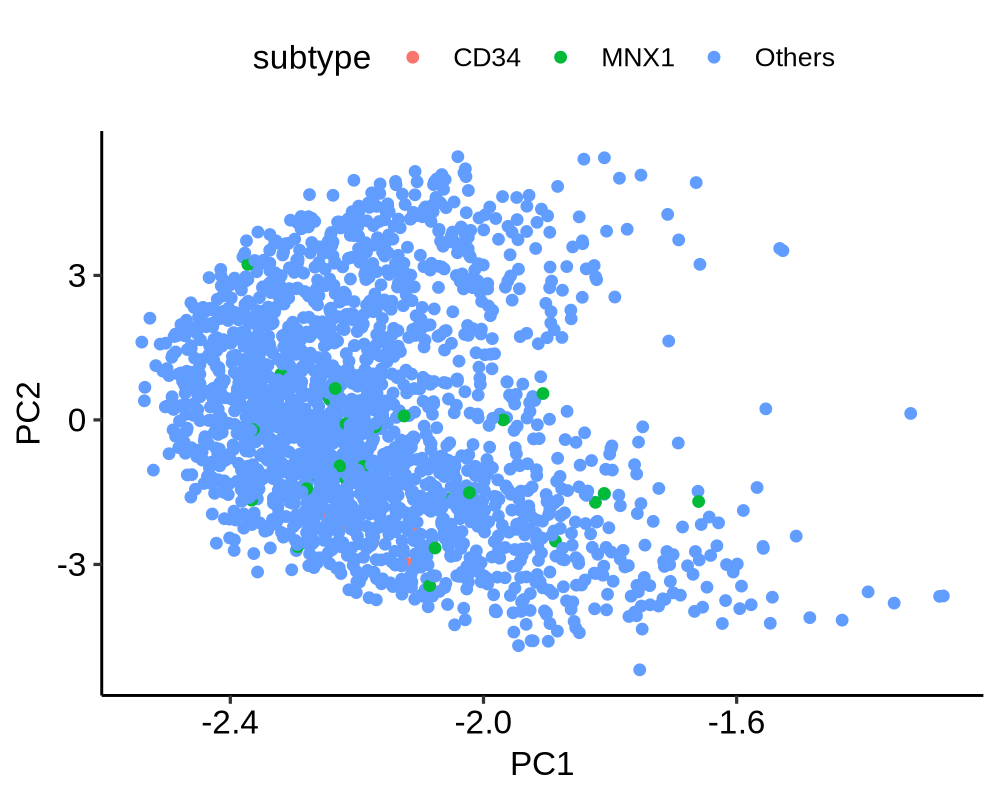

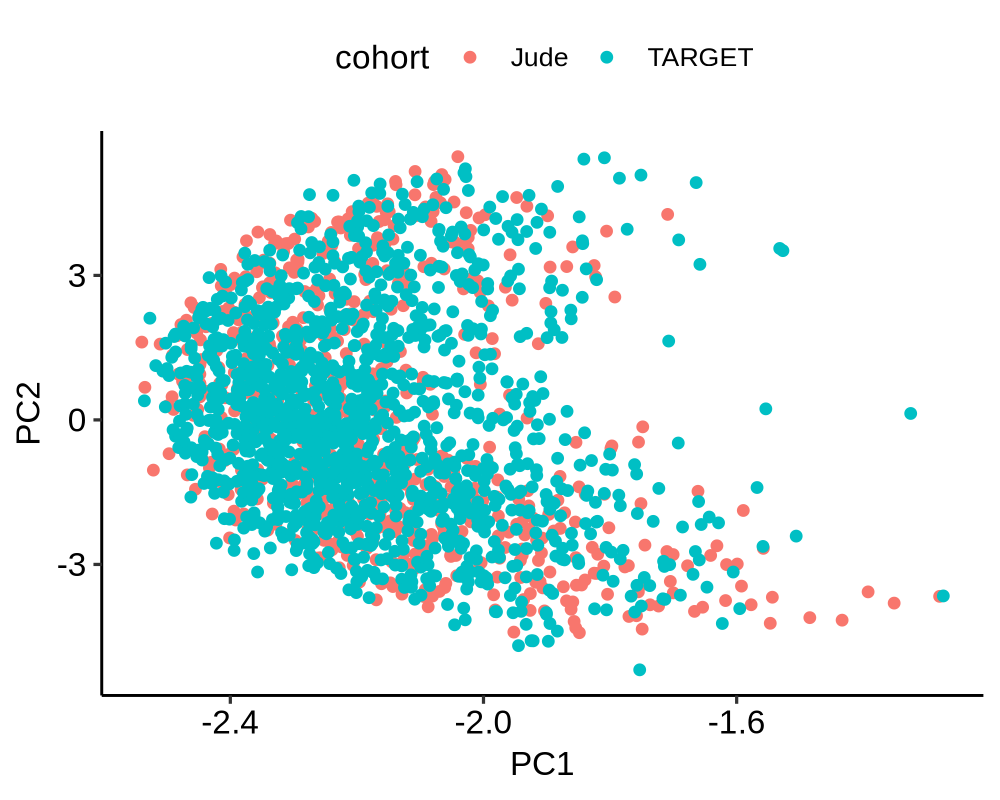

In [35]:
smallestGroupSize <- 15
keep <- rowSums(logcpm >= log2(10)) >= smallestGroupSize
plotdat = logcpm[keep, ]
keep = rowVars(plotdat) 
summary(keep)
# filter low variance
keep = keep[keep > 1.5]
keep = keep[!is.na(keep)]
keep = names(keep) 
length(keep)

plotdat = plotdat[keep, ]
pca_res <- prcomp(plotdat, scale = TRUE)

pca_res_dt = as.data.table(pca_res$rotation, keep.rownames = T)
dsn_dt = as.data.table(dsn, keep.rownames = T)
pca_res_dt = merge(pca_res_dt, dsn_dt, by.x = 'rn', by.y = 'sample_name')
pca_res_dt[, cohort := 'Jude']
pca_res_dt[grep('TARGET', rn), cohort := 'TARGET']

pca_res_dt[, PC1 := 100 * PC1]
pca_res_dt[, PC2 := 100 * PC2]

options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
ggplot(pca_res_dt, aes(PC1, PC2, color = subtype)) + geom_point() + theme_pubr()
ggplot(pca_res_dt, aes(PC1, PC2, color = cohort)) + geom_point() + theme_pubr()


# DEG: 

## MNX1 subtype vs all others

In [143]:
subtype = factor(dsn$subtype)
subtype = relevel(subtype, ref = 'MNX1')
cohort = factor(dsn$cohort)

dge = DGEList(counts=mtx_batch[, dsn$sample_name], group = subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ 0 + subtype)
dge = estimateDisp(dge, design)
saveRDS(dge, file = 'data/dge.rds')
fit = glmQLFit(dge, design, robust = T)
saveRDS(fit, file = 'data/fit_apr9.rds')


In [39]:
colnames(design) = c('MNX1', 'CD34', 'Others')
head(design)

MNX1 CD34 Others
1 0    0    1     
2 0    0    1     
3 0    0    1     
4 0    0    1     
5 0    0    1     
6 0    0    1

In [51]:
my.contrasts = makeContrasts(MNX1vsCD34=MNX1 - CD34, MNX1vsAML=MNX1 - Others, AMLvsCD34 = Others - CD34, levels=design)
MNX1vsCD34 = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsCD34"])
MNX1vsCD34 = topTags(MNX1vsCD34, n=nrow(MNX1vsCD34$table), adjust.method="fdr")

MNX1vsAML = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsAML"])
MNX1vsAML = topTags(MNX1vsAML, n=nrow(MNX1vsAML$table), adjust.method="fdr")

AMLvsCD34 = glmQLFTest(fit, contrast=my.contrasts[,"AMLvsCD34"])
AMLvsCD34 = topTags(AMLvsCD34, n=nrow(AMLvsCD34$table), adjust.method="fdr")


In [52]:
saveRDS(MNX1vsCD34, file = 'data/MNX1vsCD34.rds')
saveRDS(MNX1vsAML, file = 'data/MNX1vsAML.rds')
saveRDS(AMLvsCD34, file = 'data/AMLvsCD34.rds')


In [53]:
res_mnx1_vs_cd34 = as.data.table(MNX1vsCD34$table, keep.rownames = T)[order(PValue), ]
res_mnx1_vs_pAML = as.data.table(MNX1vsAML$table, keep.rownames = T)[order(PValue), ]


In [54]:
head(res_mnx1_vs_cd34)
head(res_mnx1_vs_pAML)


rn       logFC      logCPM    F        PValue       FDR         
1 GAGE12G  -10.050388 -4.061863 72.15116 3.742829e-17 6.948187e-13
2 GAGE12C   -8.379799 -4.214863 59.52258 1.863991e-14 1.730157e-10
3 GAGE12E   -7.676218 -4.303621 57.69542 4.577276e-14 2.832418e-10
4 GAGE12F   -7.446835 -4.288521 54.93552 1.803687e-13 8.370910e-10
5 FAM197Y7  -6.258892 -4.371402 50.71989 1.462679e-12 5.175067e-09
6 USP17L5   -5.902738 -4.379480 50.28954 1.811833e-12 5.175067e-09

rn       logFC    logCPM     F         PValue        FDR          
1 MNX1     9.287120  0.8118216 1636.0104 5.423836e-265 1.006881e-260
2 MNX1-AS2 7.664348 -3.3866226 1413.1852 6.108962e-237 5.670338e-233
3 MNX1-AS1 6.054171 -3.7139311  563.3157 1.639298e-110 1.014398e-106
4 CTTNBP2  6.225580 -1.0117729  510.9932 1.901368e-101  8.824249e-98
5 CXCL5    6.356697  1.6137162  498.9006  2.533699e-99  9.407118e-96
6 KRT72    5.194924  0.8418574  484.5988  8.346359e-97  2.582363e-93

pathway                          pval         padj       log2err   ES        
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 0.0001486048 0.00743024 0.5188481  0.9229760
2 HALLMARK_IL6_JAK_STAT3_SIGNALING 0.0037657879 0.09414470 0.4317077  0.9127203
3 HALLMARK_IL2_STAT5_SIGNALING     0.0204763785 0.34127298 0.3524879  0.8027985
4 HALLMARK_INFLAMMATORY_RESPONSE   0.0489100350 0.60203991 0.3217759  0.7744450
5 HALLMARK_ESTROGEN_RESPONSE_LATE  0.0713286713 0.60203991 0.1978220 -0.6136469
6 HALLMARK_APICAL_SURFACE          0.0722447894 0.60203991 0.2878051  0.8552083
  NES       size leadingEdge  logFDR    updn
1  1.729344 192  CSF2, CX.... 12.716232 UP  
2  1.661069  87  CSF2, CX....  8.052833 UP  
3  1.499204 193  CSF2, CO....  5.609896 UP  
4  1.447291 196  CCL7, ME....  4.353726 UP  
5 -1.247934 194  IGSF1, C....  3.809374 DN  
6  1.449946  43  RHCG, SH....  3.790963 UP

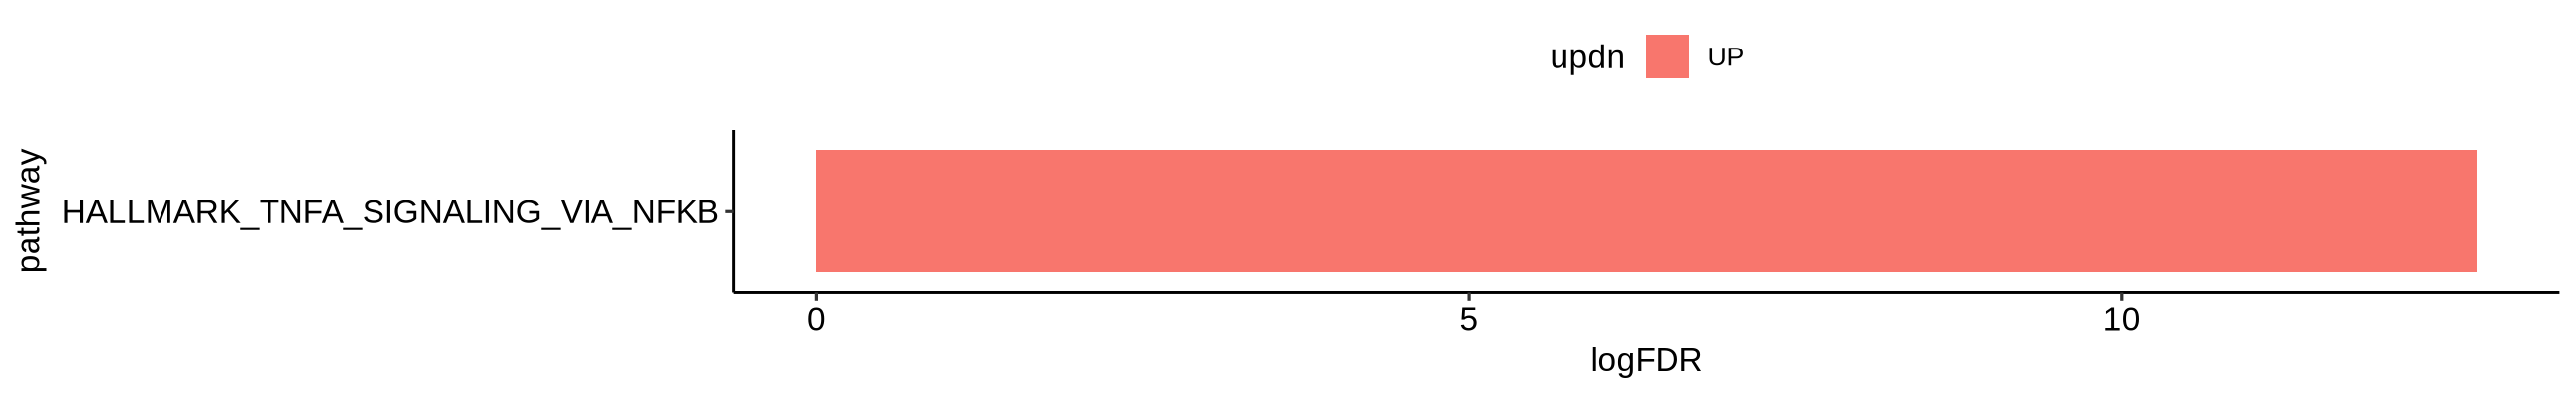

In [325]:
res_mnx1_vs_pAML[, ranking := -logFC*log10(PValue)]
res_mnx1_vs_pAML[1, ranking := 400]
tmp = res_mnx1_vs_pAML[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ] 
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 2, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr() + geom_vline(xintercept = -log2(0.05), color = 'grey') 


In [333]:
pathway_sel = c('HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_IL2_STAT5_SIGNALING') 
lapply(pathway_sel, function(xx){plotdat[pathway == xx, leadingEdge]})


[[1]]
[[1]][[1]]
 [1] "CSF2"     "CXCL1"    "CXCL3"    "MSC"      "SERPINB2" "CXCL2"   
 [7] "CCL20"    "F3"       "IL6"      "F2RL1"    "JAG1"     "TNFAIP6" 
[13] "HES1"     "TNFRSF9"  "IL1B"     "PLAUR"    "CCL2"     "LDLR"    
[19] "SPSB1"    "CXCL6"    "CD80"     "EDN1"     "ABCA1"    "KYNU"    
[25] "TNFSF9"   "EGR3"     "ICAM1"    "IL1A"     "SERPINE1" "LAMB3"   
[31] "IL12B"   


[[2]]
list()

[[3]]
list()

[[4]]
list()

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


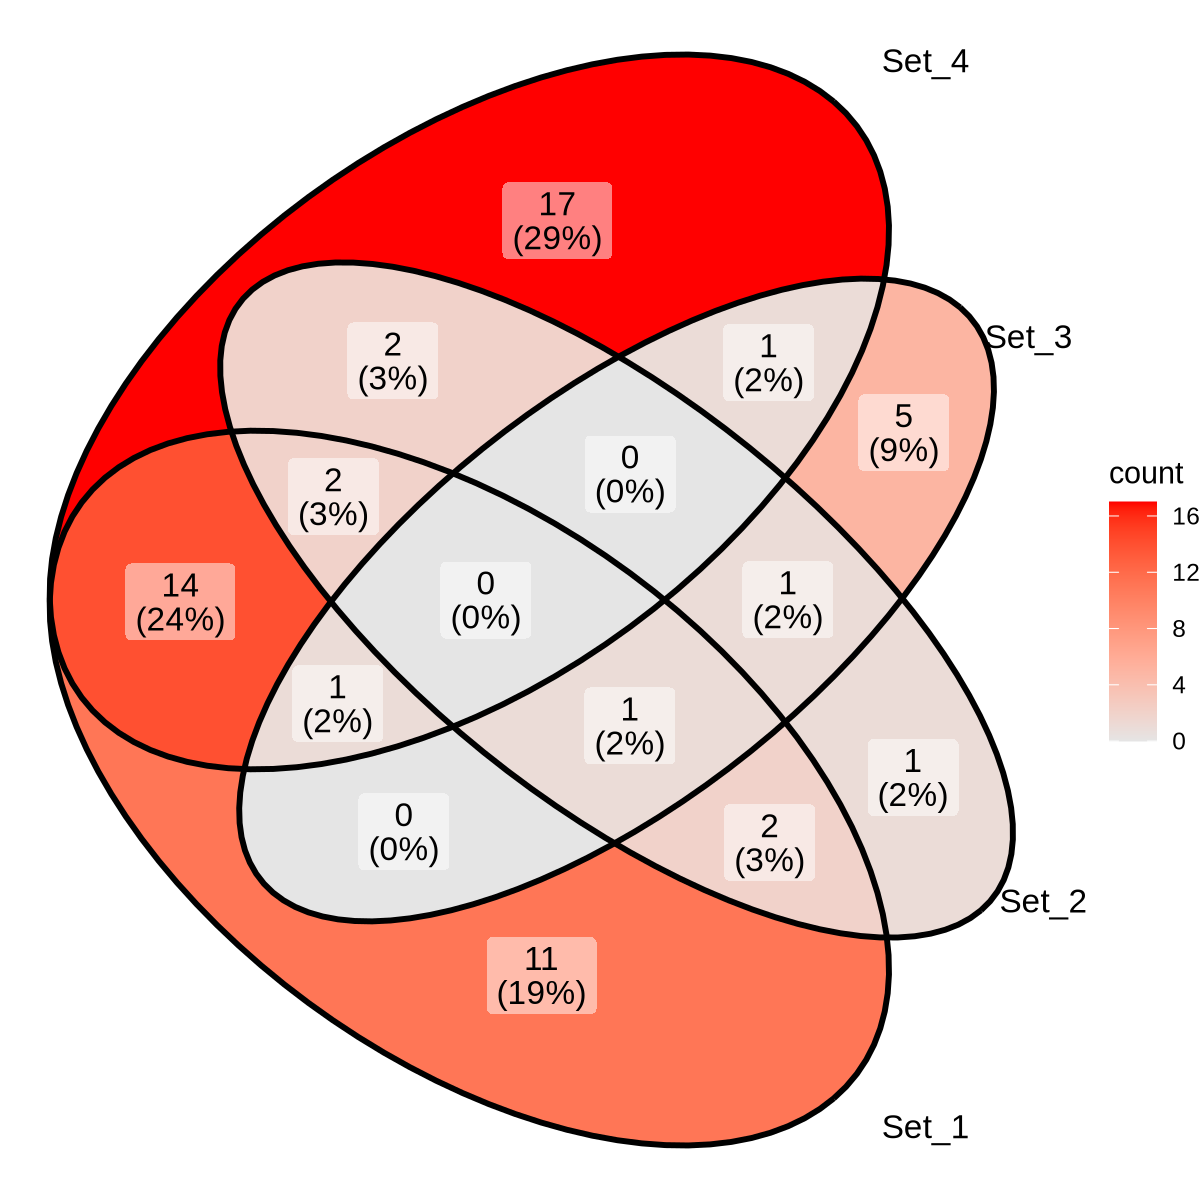

In [339]:
xx = list(unlist(fgseaRes[1, leadingEdge]),  unlist(fgseaRes[2, leadingEdge]),  unlist(fgseaRes[3, leadingEdge]),  unlist(fgseaRes[4, leadingEdge]))
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 200)
ggVennDiagram(xx) + scale_fill_gradient(low="grey90",high = "red") + coord_flip()



In [353]:
res_mnx1_vs_pAML[rn %in% edge_genes, edge := T]
saveRDS(res_mnx1_vs_pAML, file = 'data/res_mnx1_vs_pAML.rds')


pathway                          pval         padj         log2err  
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 1.273372e-17 6.366862e-16 1.0864405
2 HALLMARK_E2F_TARGETS             3.144895e-15 7.862236e-14 1.0073180
3 HALLMARK_G2M_CHECKPOINT          1.897373e-13 3.162289e-12 0.9436322
4 HALLMARK_APOPTOSIS               3.392475e-11 4.240594e-10 0.8513391
5 HALLMARK_MITOTIC_SPINDLE         6.137284e-11 6.137284e-10 0.8390889
6 HALLMARK_HEME_METABOLISM         1.077067e-10 8.975558e-10 0.8390889
  ES        NES      size leadingEdge  logFDR   updn
1 0.8169803 2.252644 192  JAG1, KY.... 56.12412 UP  
2 0.7828578 2.196319 195  RRM2, MK.... 48.17591 UP  
3 0.7714133 2.095057 188  MKI67, K.... 42.26106 UP  
4 0.7649086 2.091006 157  PRF1, TO.... 34.77887 UP  
5 0.7169589 2.011438 195  KIF23, A.... 33.92361 UP  
6 0.7176839 1.965257 190  HBB, SLC.... 33.11217 UP

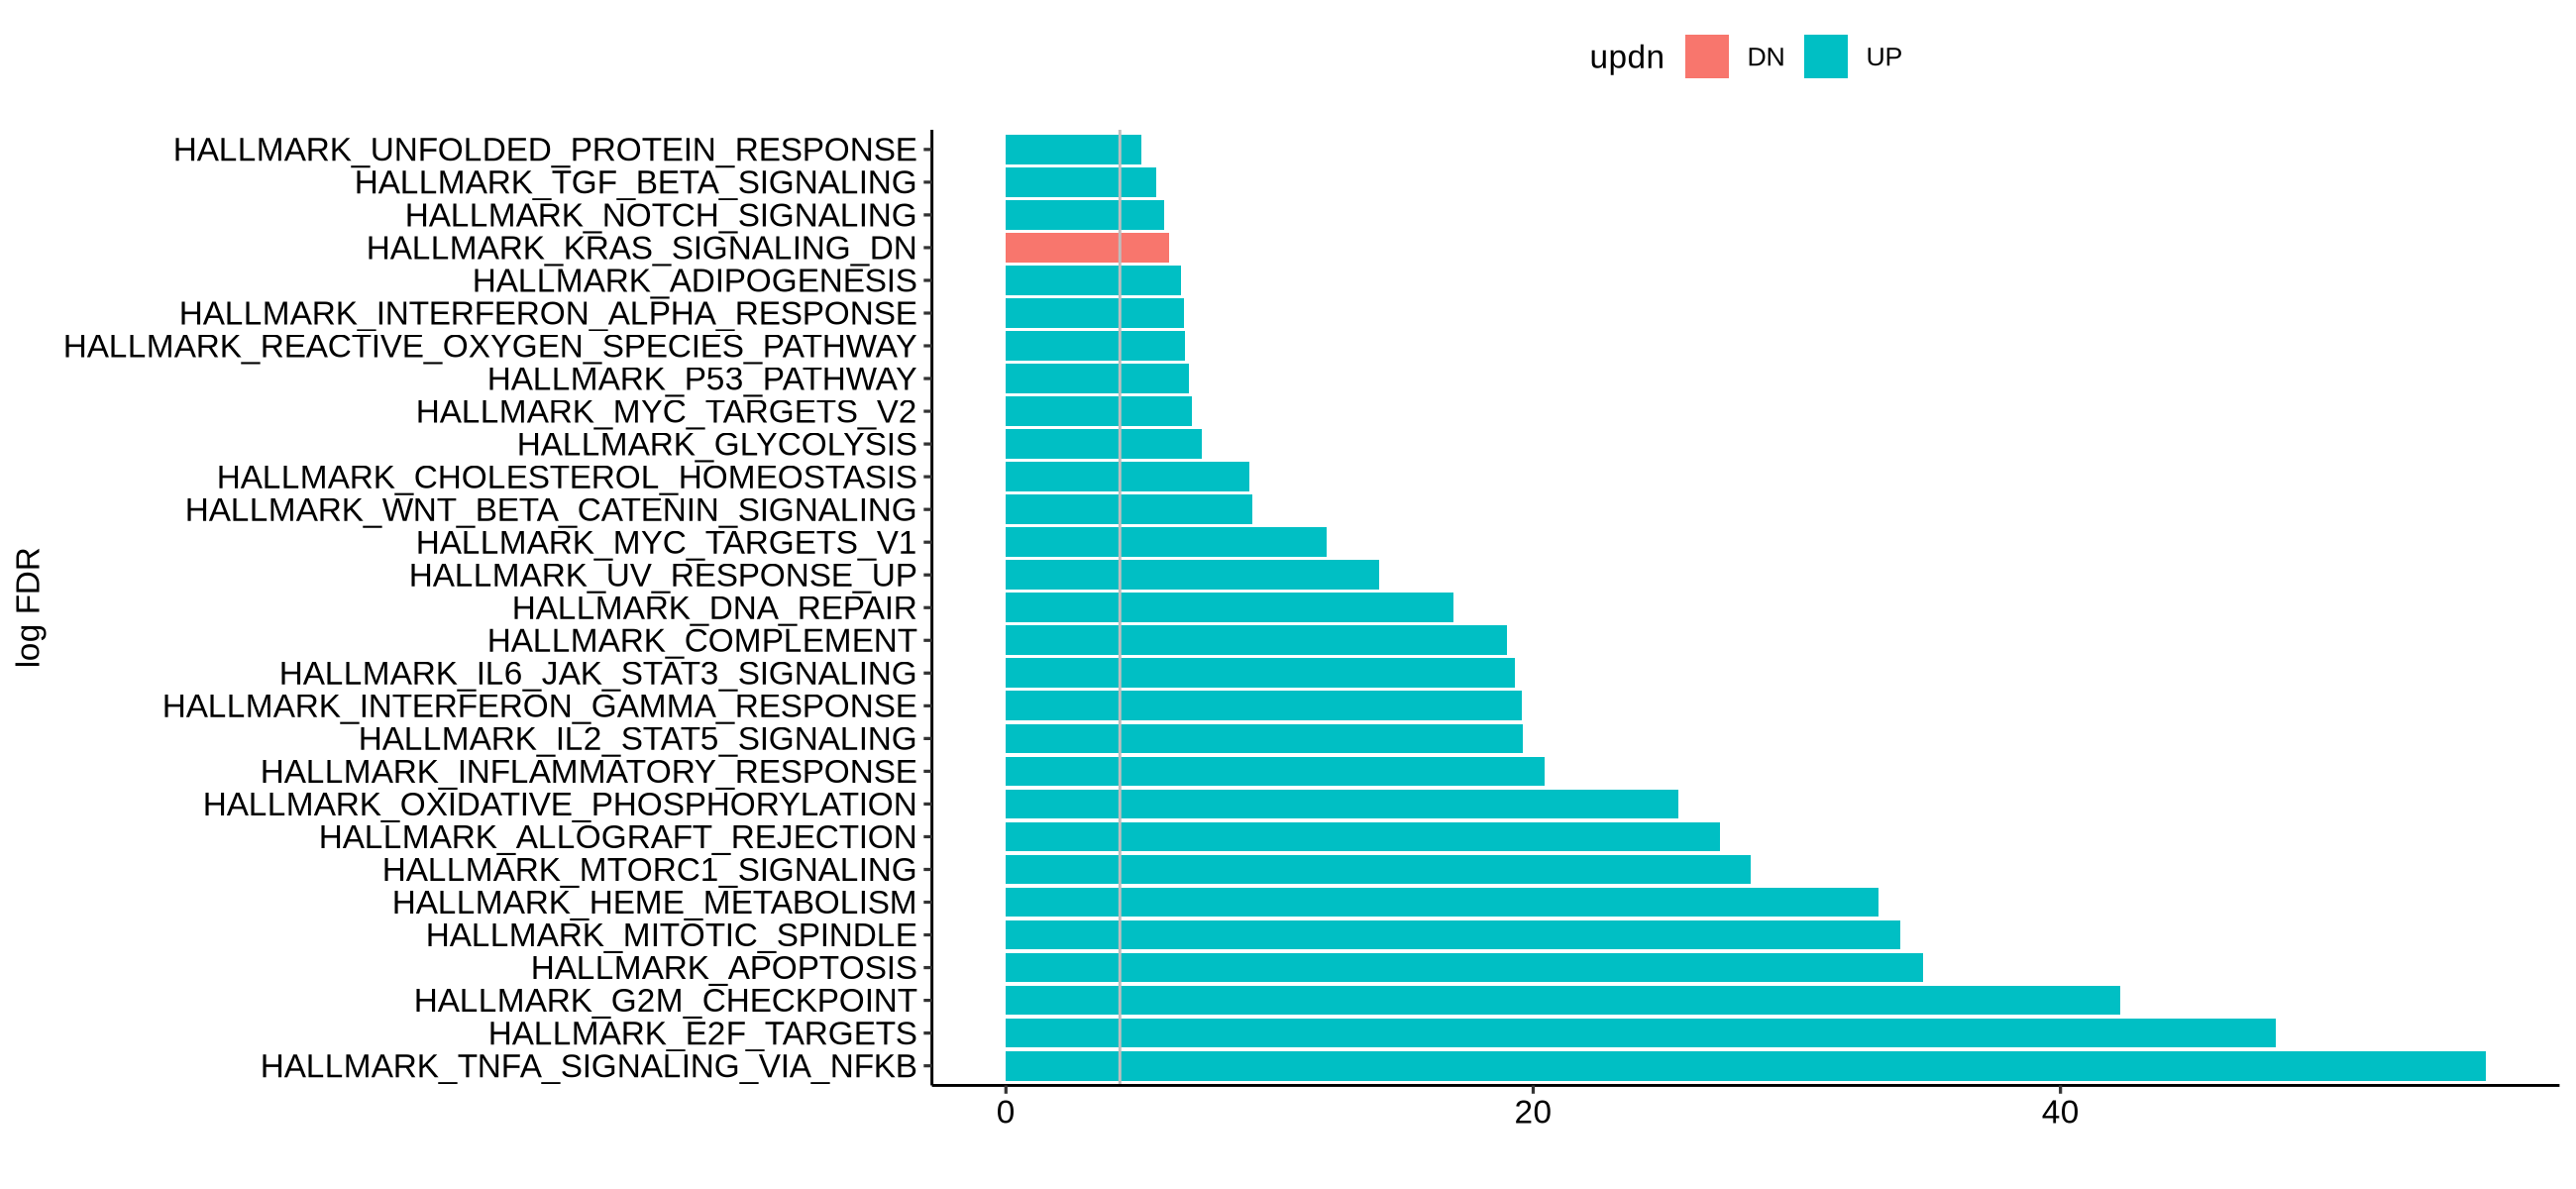

In [56]:
res_mnx1_vs_cd34[, ranking := -logFC*log10(PValue)]
tmp = res_mnx1_vs_cd34[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
fgseaRes[, pathway := factor(pathway, levels = fgseaRes$pathway)] 
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 6, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr() + geom_hline(yintercept = -log2(0.05), color = 'grey') + ylab('') + xlab('log FDR')


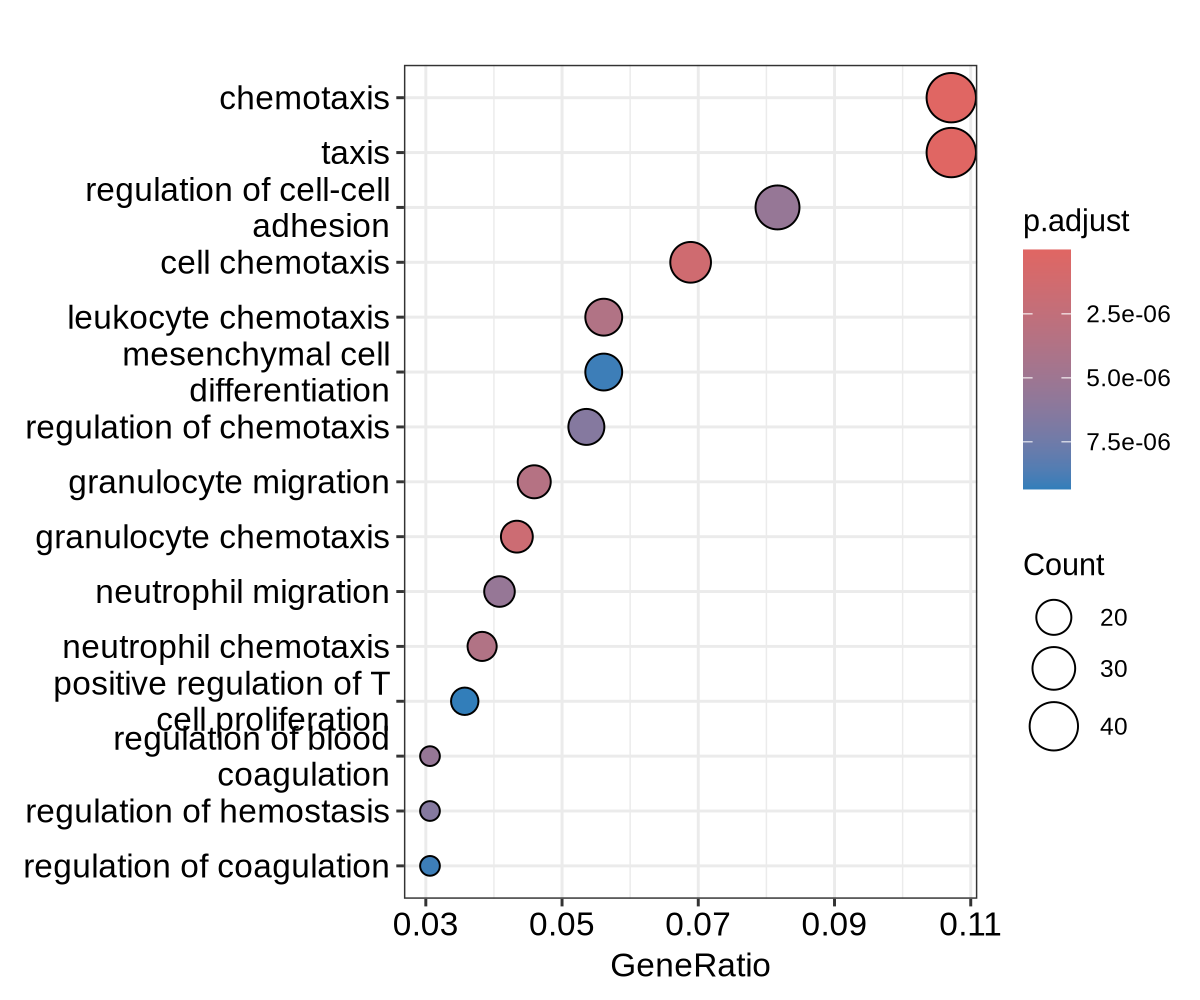

In [285]:
test_gene = res_mnx1_vs_pAML[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy, showCategory = 15) 

## MNX1 subtype vs others, but not the ones with high MNX1 

In [62]:
setkey(dsn, 'sample_name')

In [287]:
mnx1_id = two_gene[subtype == 'MNX1', rn]
rest_id = two_gene[subtype == 'Others' & is.na(other_mnx_hi), rn]

tmp = dsn[c(mnx1_id, rest_id), ] 
mtx2 = mtx_batch[, tmp$sample_name]

condition = factor(c(rep('MNX1', length(mnx1_id)), rep('Others', length(rest_id))), levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


rn       logFC     logCPM     LR        PValue        FDR          
1 MNX1     10.594494  0.7378033 1652.1244  0.000000e+00  0.000000e+00
2 KRT72     5.292754  0.8017487  649.1583 3.405357e-143 2.991777e-139
3 MNX1-AS2  7.802997 -3.4092145  603.0826 3.575206e-133 2.093998e-129
4 KRT73     4.866424  0.5108849  539.7373 2.150742e-119 9.447673e-116
5 CXCL5     6.347932  1.5869044  510.5611 4.787812e-113 1.682533e-109
6 CTTNBP2   6.304675 -1.0250106  425.5930  1.479368e-94  4.332330e-91

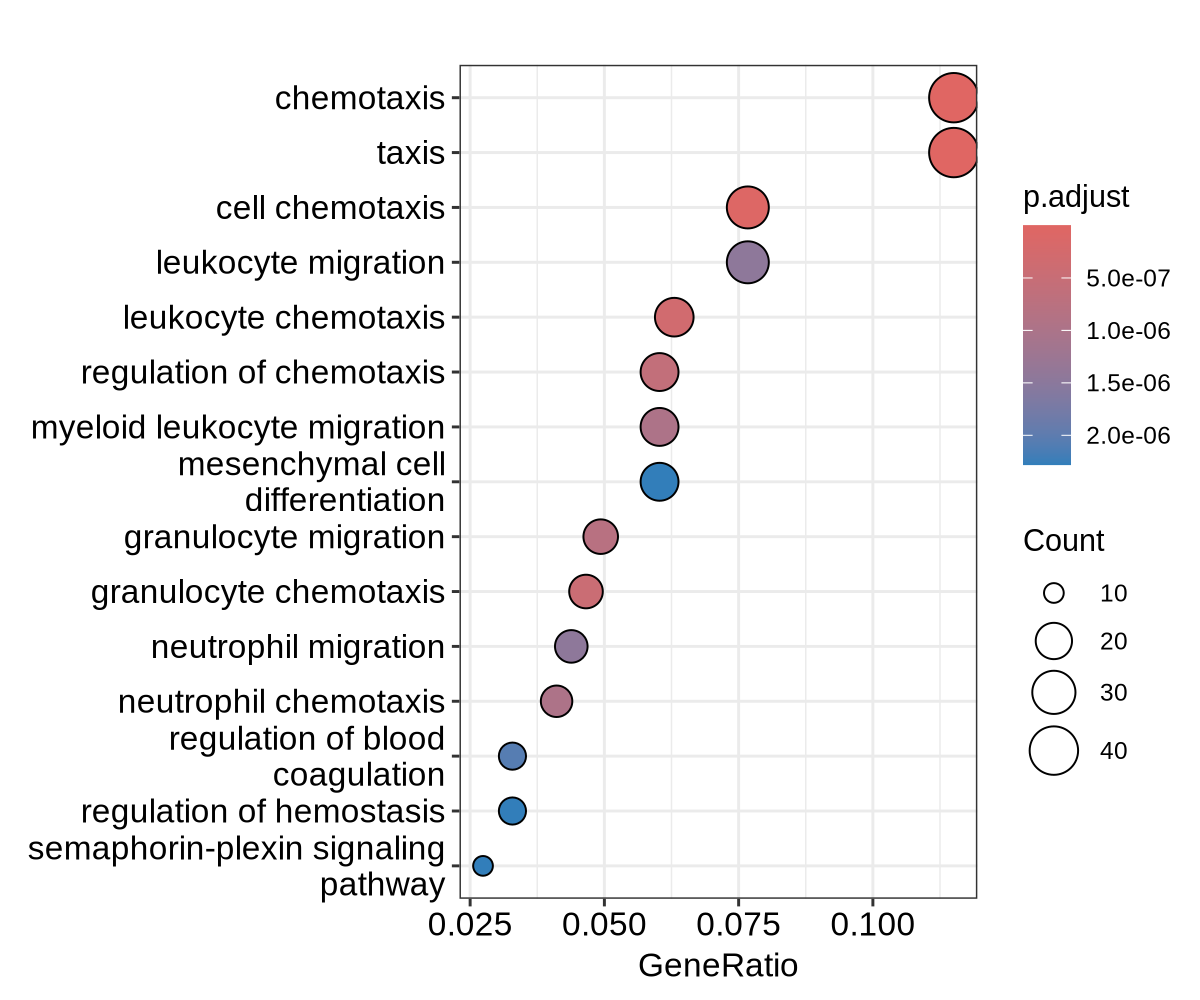

In [288]:
test_gene = res_test[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy, showCategory = 15) 

pathway                          pval         padj       log2err   ES        
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 0.0006590129 0.03295065 0.4772708  0.9177086
2 HALLMARK_ESTROGEN_RESPONSE_LATE  0.0159763458 0.39940864 0.3524879 -0.6250903
3 HALLMARK_IL6_JAK_STAT3_SIGNALING 0.0422098606 0.70349768 0.3217759  0.9017467
4 HALLMARK_INFLAMMATORY_RESPONSE   0.1361386139 0.87803016 0.1900233  0.7768071
5 HALLMARK_NOTCH_SIGNALING         0.1473354232 0.87803016 0.2065879  0.8126611
6 HALLMARK_CHOLESTEROL_HOMEOSTASIS 0.1494565217 0.87803016 0.1900233  0.7803441
  NES       size leadingEdge  logFDR    updn
1  1.704242 192  CSF2, CX.... 10.567406 UP  
2 -1.364860 192  IGSF1, C....  5.967919 DN  
3  1.627440  87  CSF2, CX....  4.566276 UP  
4  1.442277 196  MET, CSF....  2.876852 UP  
5  1.340769  32  JAG1, HE....  2.762824 UP  
6  1.376884  73  JAG1, TP....  2.742202 UP

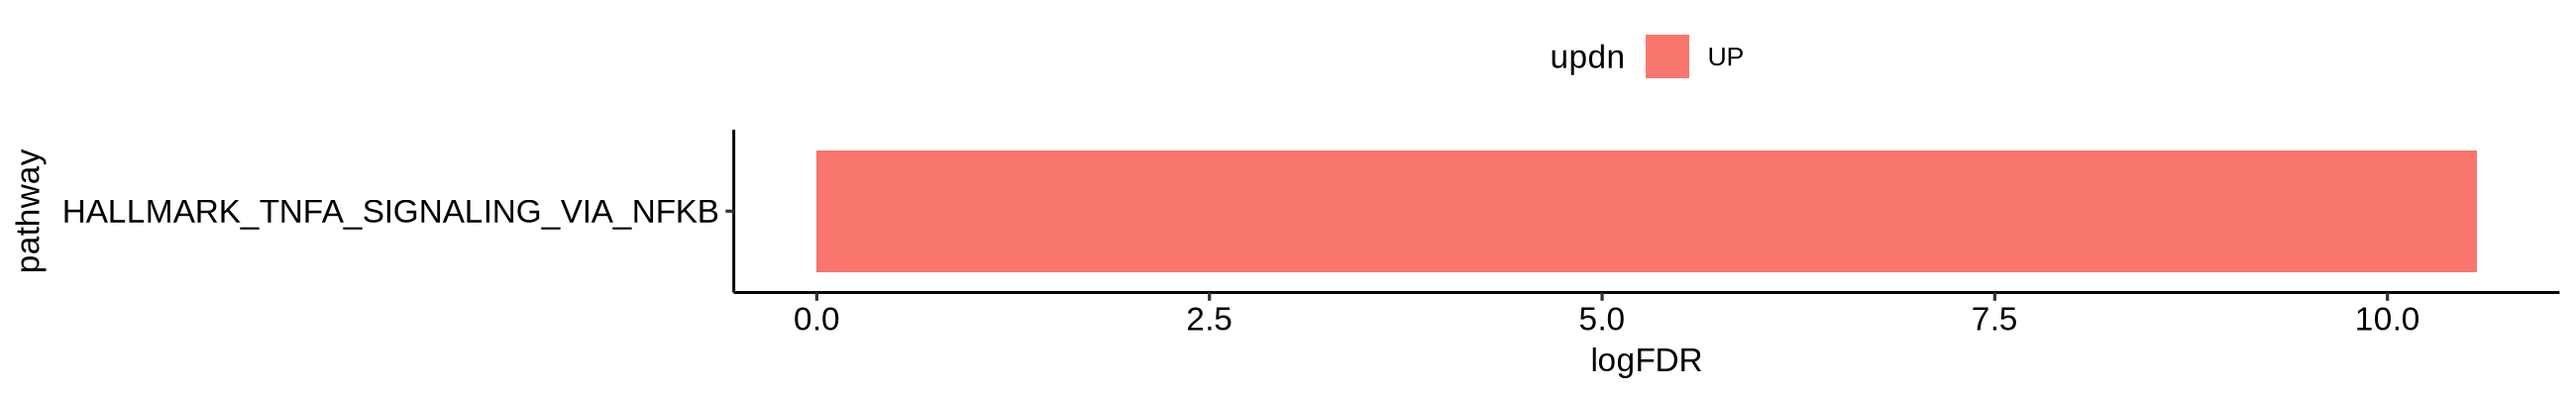

In [70]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 1200]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 2, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


# UMAP

In [298]:
logcpm_mad = apply(logcpm, 1, mad)
logcpm_mad = as.data.table(logcpm_mad, keep.rownames = T)
quantile(logcpm_mad$logcpm_mad)


0%          25%          50%          75%         100% 
6.584067e-15 6.181825e-01 8.165232e-01 1.280471e+00 8.961555e+00

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


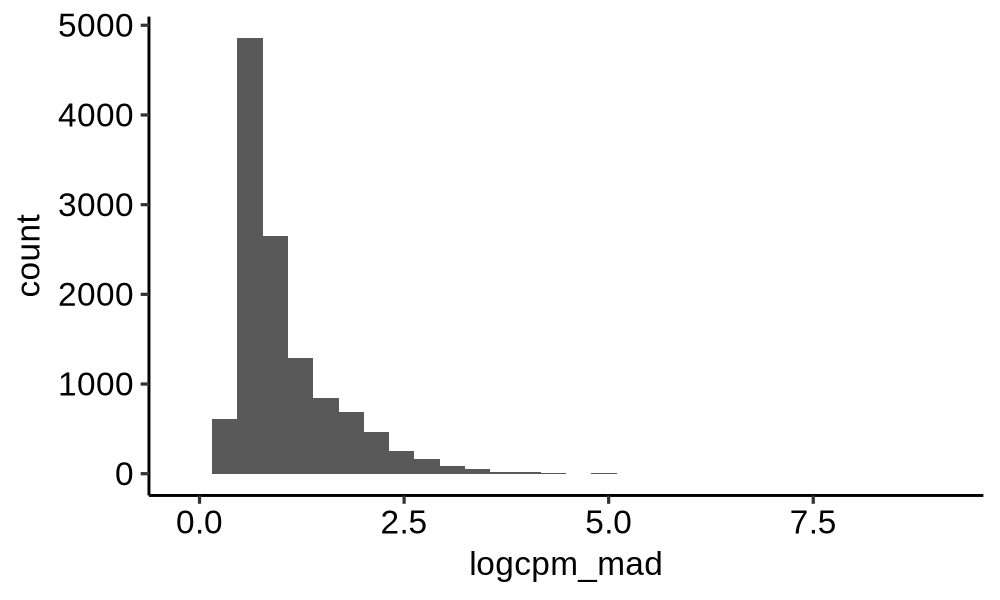

In [297]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)
ggplot(logcpm_mad, aes(logcpm_mad)) + geom_histogram() + theme_pubr()


In [301]:
plotdat = logcpm[logcpm_mad[logcpm_mad > 1.2, rn], ] 

mtx_cpm_umap = umap(t(plotdat))
mtx_cpm_umap_layout = as.data.table(mtx_cpm_umap$layout, keep.rownames = T)
mtx_cpm_umap_layout = merge(mtx_cpm_umap_layout, dsn, by.x = 'rn', by.y = 'sample_name')


In [302]:
tmp = copy(mtx_clin_892)
tmp[, subtype_jude := subtype]
mtx_cpm_umap_layout = merge(mtx_cpm_umap_layout, tmp[, .(sample_name2, subtype_jude)], by.x = 'rn', by.y = 'sample_name2', all.x = T)
head(mtx_cpm_umap_layout)


rn             V1        V2        subtype cohort subtype_jude
1 SJAEL011880_D1  1.738279 -1.525316 Others  Jude   UBTF        
2 SJAEL011881_D1 -3.816804 -1.772668 Others  Jude   NUP98r      
3 SJAEL011882_D1 -3.803172 -1.708460 Others  Jude   Other       
4 SJAEL011883_D1 -3.708024 -1.862437 Others  Jude   NUP98r      
5 SJAEL011884_D1 -4.444401 -1.648860 Others  Jude   GATA1       
6 SJAEL015024_D1  1.633606 -2.340864 Others  Jude   NPM1

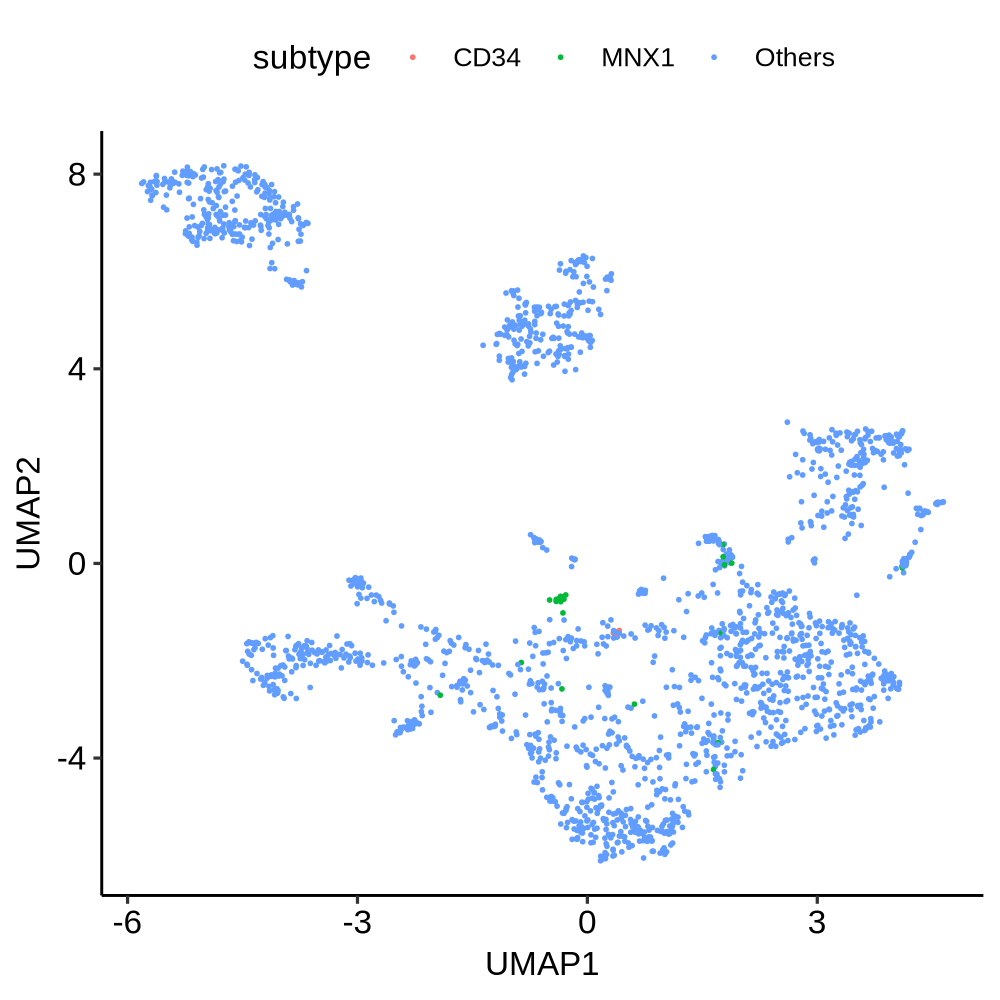

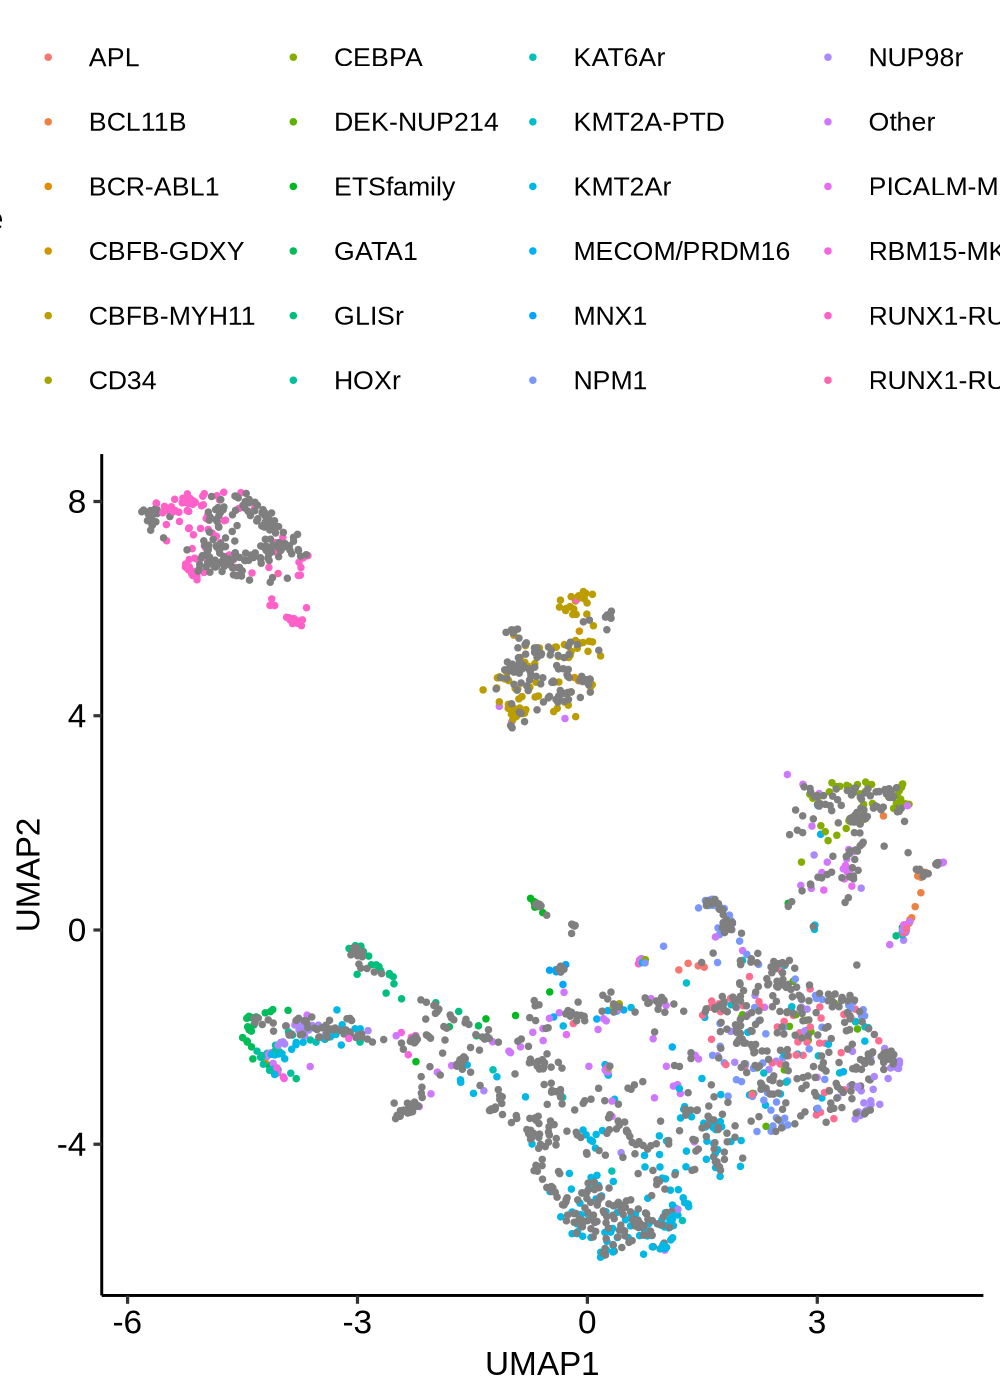

In [303]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
ggplot(mtx_cpm_umap_layout, aes(V1, V2, color = subtype)) + geom_point(size = .31) + theme_pubr() + xlab('UMAP1') + ylab('UMAP2')
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 200)
ggplot(mtx_cpm_umap_layout, aes(V1, V2, color = subtype_jude)) + geom_point(size = .61) + theme_pubr() + xlab('UMAP1') + ylab('UMAP2')


In [311]:
km = setDF(mtx_cpm_umap_layout[, .(V1, V2)], rownames = mtx_cpm_umap_layout$rn)
km = kmeans(km, centers = 10)
tmp = as.data.table(as.data.frame(km$cluster), keep.rownames = T)
setnames(tmp, 2, 'kluster')
tmp[, kluster := paste0('CL_', kluster)]
mtx_cpm_umap_layout = merge(mtx_cpm_umap_layout, tmp, by = 'rn', all.x = T)
head(mtx_cpm_umap_layout)


rn             V1        V2        subtype cohort subtype_jude kluster
1 SJAEL011880_D1  1.738279 -1.525316 Others  Jude   UBTF         CL_9   
2 SJAEL011881_D1 -3.816804 -1.772668 Others  Jude   NUP98r       CL_5   
3 SJAEL011882_D1 -3.803172 -1.708460 Others  Jude   Other        CL_5   
4 SJAEL011883_D1 -3.708024 -1.862437 Others  Jude   NUP98r       CL_5   
5 SJAEL011884_D1 -4.444401 -1.648860 Others  Jude   GATA1        CL_5   
6 SJAEL015024_D1  1.633606 -2.340864 Others  Jude   NPM1         CL_2

In [312]:
km_center = as.data.table(km$centers)
km_center[, kluster := paste0('CL_', 1:nrow(km_center))]
head(km_center)


V1         V2        kluster
1  0.9913674 -3.619378 CL_1   
2  2.9911574 -2.537737 CL_2   
3 -1.4636439 -2.742208 CL_3   
4 -4.6361057  7.218504 CL_4   
5 -3.5294917 -1.678821 CL_5   
6  3.6277178  1.748940 CL_6

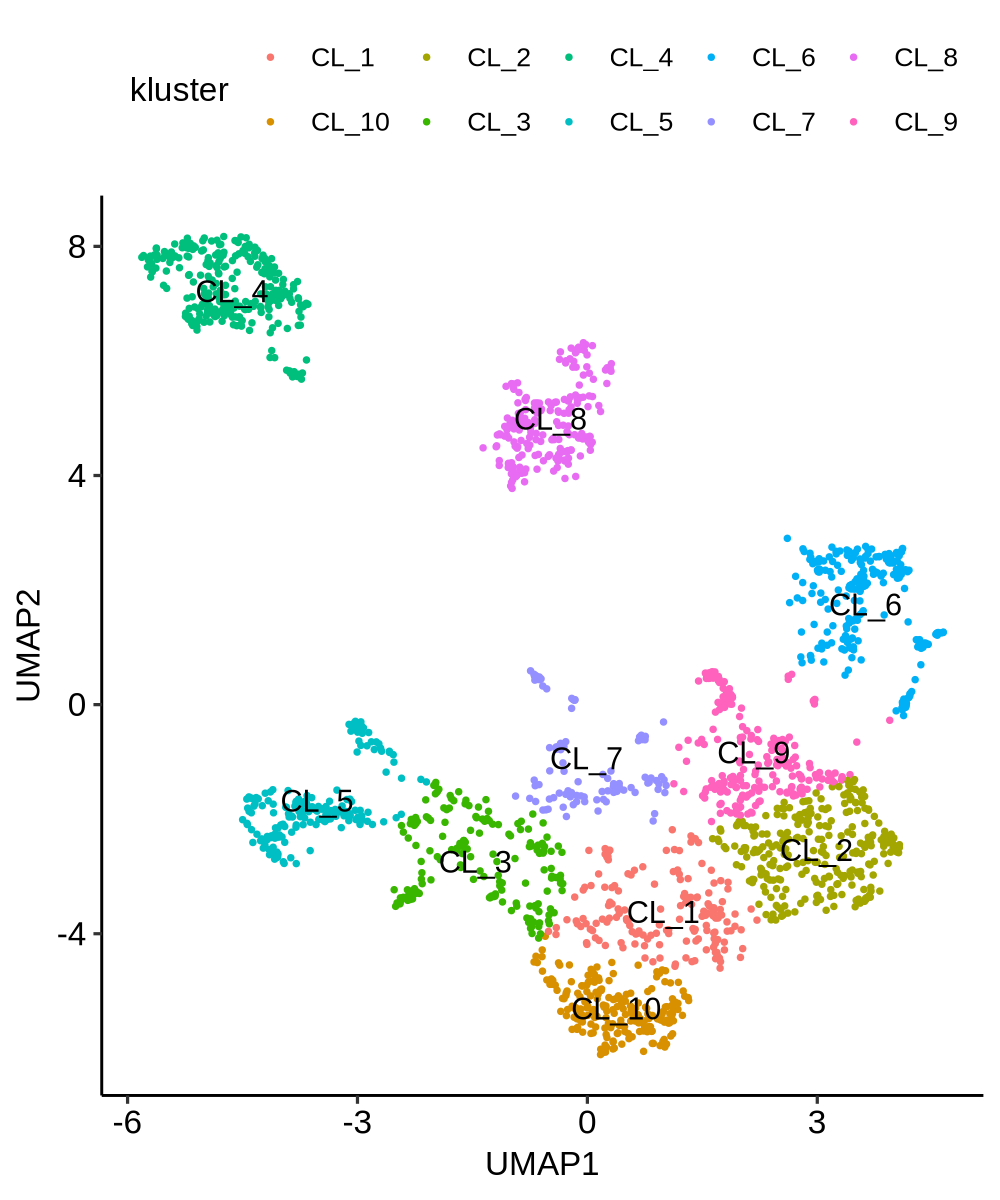

In [313]:
options(repr.plot.width = 5, repr.plot.height = 6, repr.plot.res = 200)
ggplot(mtx_cpm_umap_layout, aes(V1, V2, color = kluster)) + geom_point(size = .61) + theme_pubr() + xlab('UMAP1') + ylab('UMAP2') + geom_text(inherit.aes = F, data = km_center, aes(V1, V2, label = kluster))


In [315]:
table(mtx_cpm_umap_layout[subtype == 'MNX1', kluster])
table(mtx_cpm_umap_layout[subtype == 'MNX1', subtype_jude])
table(mtx_cpm_umap_layout[kluster == 'CL_7', subtype])
table(mtx_cpm_umap_layout[kluster == 'CL_7', subtype_jude])



CL_1 CL_3 CL_6 CL_7 CL_9 
   3    3    1   14    5 


KMT2A-PTD      MNX1 
        1         5 


  CD34   MNX1 Others 
     5     14     94 


   CBFB-MYH11          CD34         CEBPA     ETSfamily        KMT2Ar 
            1             5             1            12             3 
 MECOM/PRDM16          MNX1          NPM1         Other PICALM-MLLT10 
            6             5             2            12             1 
RUNX1-RUNX1T1          UBTF 
            4             1 

In [316]:
cl = mtx_cpm_umap_layout[subtype == 'MNX1', kluster]
unique(cl)
mnx1_close_id = mtx_cpm_umap_layout[kluster %in% cl, rn]
length(mnx1_close_id)


[1] "CL_7" "CL_1" "CL_9" "CL_3" "CL_6"

[1] 908

In [317]:
table(mtx_cpm_umap_layout[subtype == 'MNX1', kluster])
table(mtx_cpm_umap_layout[subtype == 'MNX1', subtype_jude])
table(mtx_cpm_umap_layout[kluster == 'CL_9', subtype])
table(mtx_cpm_umap_layout[kluster == 'CL_9', subtype_jude])



CL_1 CL_3 CL_6 CL_7 CL_9 
   3    3    1   14    5 


KMT2A-PTD      MNX1 
        1         5 


  MNX1 Others 
     5    212 


       APL DEK-NUP214  ETSfamily  KMT2A-PTD     KMT2Ar       NPM1     NUP98r 
         4          5          1          5          6         32          6 
     Other       UBTF 
         5         17 

In [318]:
table(mtx_cpm_umap_layout[kluster == 'CL_2', subtype_jude])
table(mtx_cpm_umap_layout[kluster == 'CL_3', subtype])




  DEK-NUP214    KMT2A-PTD       KMT2Ar MECOM/PRDM16         NPM1       NUP98r 
          11            8            9            1           39           33 
       Other         UBTF 
           1           29 


  MNX1 Others 
     3    185 

# DEG cluster with MNX1 close

In [319]:
mnx1_additional_high

[1] "SJAML015345_D2"   "SJAML016529_D1"   "SJAML031343_D1"   "SJAML032378_D1"  
[5] "SJAML074176_D1"   "TARGET-20-PAWJDM" "TARGET-20-PAWMDY"

In [320]:
dsn_sel = dsn[sample_name %in% setdiff(mnx1_close_id, mnx1_additional_high), ]
subtype = dsn_sel$subtype
table(dsn_sel$subtype)



  CD34   MNX1 Others 
     5     26    870 

In [321]:
dge = DGEList(counts=mtx_batch[, dsn_sel$sample_name], group = dsn_sel$subtype)
dge <- calcNormFactors(dge)

keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ 0 + subtype)
colnames(design) = c('CD34', 'MNX1', 'Others')
dge = estimateDisp(dge, design)
fit = glmQLFit(dge, design, robust = T)


In [322]:
my.contrasts = makeContrasts(MNX1vsCD34=MNX1 - CD34, MNX1vsAML=MNX1 - Others, AMLvsCD34 = Others - CD34, levels=design)
fit2 = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsCD34"])
umap_MNX1vsCD34 = topTags(fit2, n=nrow(MNX1vsCD34$table), adjust.method="fdr")

fit2 = glmQLFTest(fit, contrast=my.contrasts[,"MNX1vsAML"])
umap_MNX1vsAML = topTags(fit2, n=nrow(MNX1vsAML$table), adjust.method="fdr")

fit2 = glmQLFTest(fit, contrast=my.contrasts[,"AMLvsCD34"])
umap_AMLvsCD34 = topTags(fit2, n=nrow(AMLvsCD34$table), adjust.method="fdr")

umap_MNX1vsCD34 = as.data.table(umap_MNX1vsCD34$table, keep.rownames = T)
umap_MNX1vsAML = as.data.table(umap_MNX1vsAML$table, keep.rownames = T)
umap_AMLvsCD34 = as.data.table(umap_AMLvsCD34$table, keep.rownames = T)


pathway                          pval        padj       log2err   ES       
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 0.001418512 0.07092562 0.4550599 0.9185836
2 HALLMARK_IL2_STAT5_SIGNALING     0.024363630 0.51002455 0.3524879 0.7895998
3 HALLMARK_IL6_JAK_STAT3_SIGNALING 0.030601473 0.51002455 0.3524879 0.9188623
4 HALLMARK_APICAL_SURFACE          0.059609245 0.74511557 0.3217759 0.8026030
5 HALLMARK_INFLAMMATORY_RESPONSE   0.106995885 0.90539542 0.2820134 0.7276783
6 HALLMARK_CHOLESTEROL_HOMEOSTASIS 0.126126126 0.90539542 0.2712886 0.7656424
  NES      size leadingEdge  logFDR   updn
1 1.791719 192  CSF2, CX.... 9.461406 UP  
2 1.545975 193  CSF2, CO.... 5.359127 UP  
3 1.698896  87  CSF2, CX.... 5.030255 UP  
4 1.419810  43  RHCG, SH.... 4.068320 UP  
5 1.412602 196  CCL7, HA.... 3.224373 UP  
6 1.417003  73  JAG1, GN.... 2.987061 UP

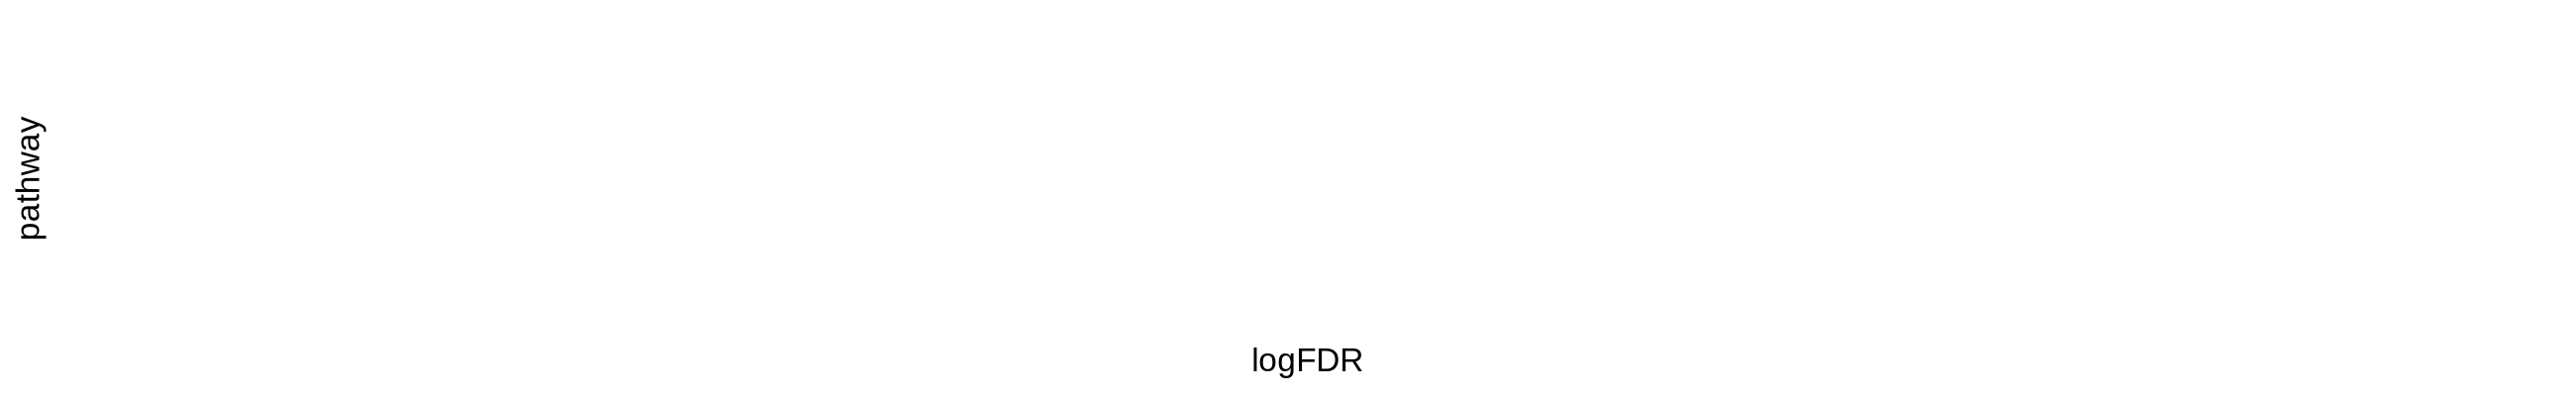

In [323]:
umap_MNX1vsAML[, ranking := -logFC*log10(PValue)]
tmp = umap_MNX1vsAML[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 2, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


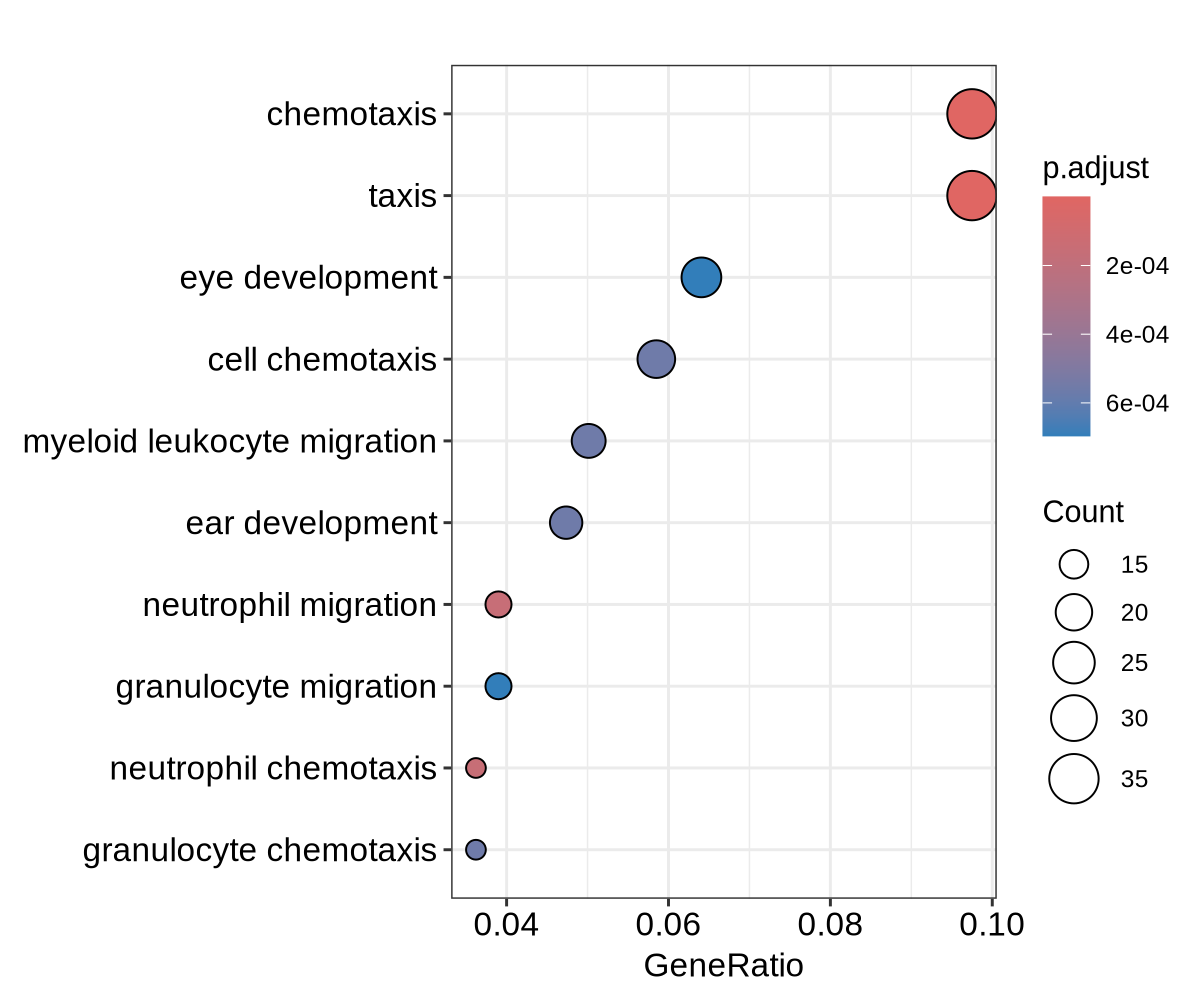

In [324]:
test_gene = umap_MNX1vsAML[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy)

# plot MNX1 expression 

In [196]:
logcpm_dt = as.data.table(logcpm, keep.rownames = T)
head(logcpm_dt)

rn    TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
1 DPM1  4.011284         4.198293         4.259012         4.072161        
2 SCYL3 4.545856         4.930921         4.515282         4.778365        
3 FGR   8.430778         8.438234         8.449027         8.214366        
4 CFH   2.698613         2.692204         2.442447         3.781800        
5 FUCA2 5.141907         5.073062         4.832582         4.553031        
6 GCLC  6.489247         6.558061         6.784303         6.728849        
  TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
1 4.326395         4.159428         4.358442         3.879797        
2 3.811799         4.157880         4.011712         3.909942        
3 8.624126         8.002610         8.333749         8.119825        
4 2.761091         2.262577         3.762563         3.268534        
5 5.156804         5.061506         4.827337         4.945674        
6 6.706862         7.174135         7.170941         6.997699        
  TARGET-00-BM5682 ⋯ SJMLL014_D SJMLL018_D SJMLL019_D SJMLL030007_D1
1 3.795643         ⋯  2.856942   3.714762   3.284342  4.706627      
2 5.076878         ⋯  5.182127   4.818558   4.195028  4.790254      
3 8.126533         ⋯  7.166738   8.022325   8.063386  5.173892      
4 2.953065         ⋯ -2.908586  -2.092593  -1.615001  5.196363      
5 4.169553         ⋯  4.470561   4.901213   5.271440  5.232147      
6 6.176799         ⋯  5.236896   5.975752   5.297452  5.787221      
  SJPML030005_D1 SJAML062379_G1 SJAML062380_G1 SJAML062381_G1 SJAML062382_G1
1 5.358350       4.347564       5.814390       5.272507       5.063035      
2 4.188304       4.752455       3.643173       3.911136       3.845055      
3 2.072102       5.017166       4.691086       3.019152       5.482096      
4 6.031887       4.569497       4.273970       4.741608       4.952233      
5 5.201412       4.138742       3.767511       4.253609       4.338768      
6 5.176943       5.548459       4.900118       5.307890       5.044844      
  SJAML062383_G1
1 4.716746      
2 5.081152      
3 4.304448      
4 4.832473      
5 4.108454      
6 5.521392

In [197]:
plotdat = as.data.table(melt(logcpm_dt[rn == 'MNX1', ]))
plotdat = merge(plotdat, dsn[, c('sample_name', 'subtype')], by.x = 'variable', by.y = 'sample_name', all.x = T)
setnames(plotdat, 'value', 'MNX1')
head(plotdat)


Warning message in melt.data.table(logcpm_dt[rn == "MNX1", ]):
"id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rn, ...]. Consider providing at least one of 'id' or 'measure' vars in future."


variable       rn   MNX1      subtype
1 SJAEL011880_D1 MNX1 -4.461827 Others 
2 SJAEL011881_D1 MNX1 -2.937565 Others 
3 SJAEL011882_D1 MNX1 -3.378713 Others 
4 SJAEL011883_D1 MNX1 -3.431713 Others 
5 SJAEL011884_D1 MNX1 -4.461827 Others 
6 SJAEL015024_D1 MNX1 -4.461827 Others

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


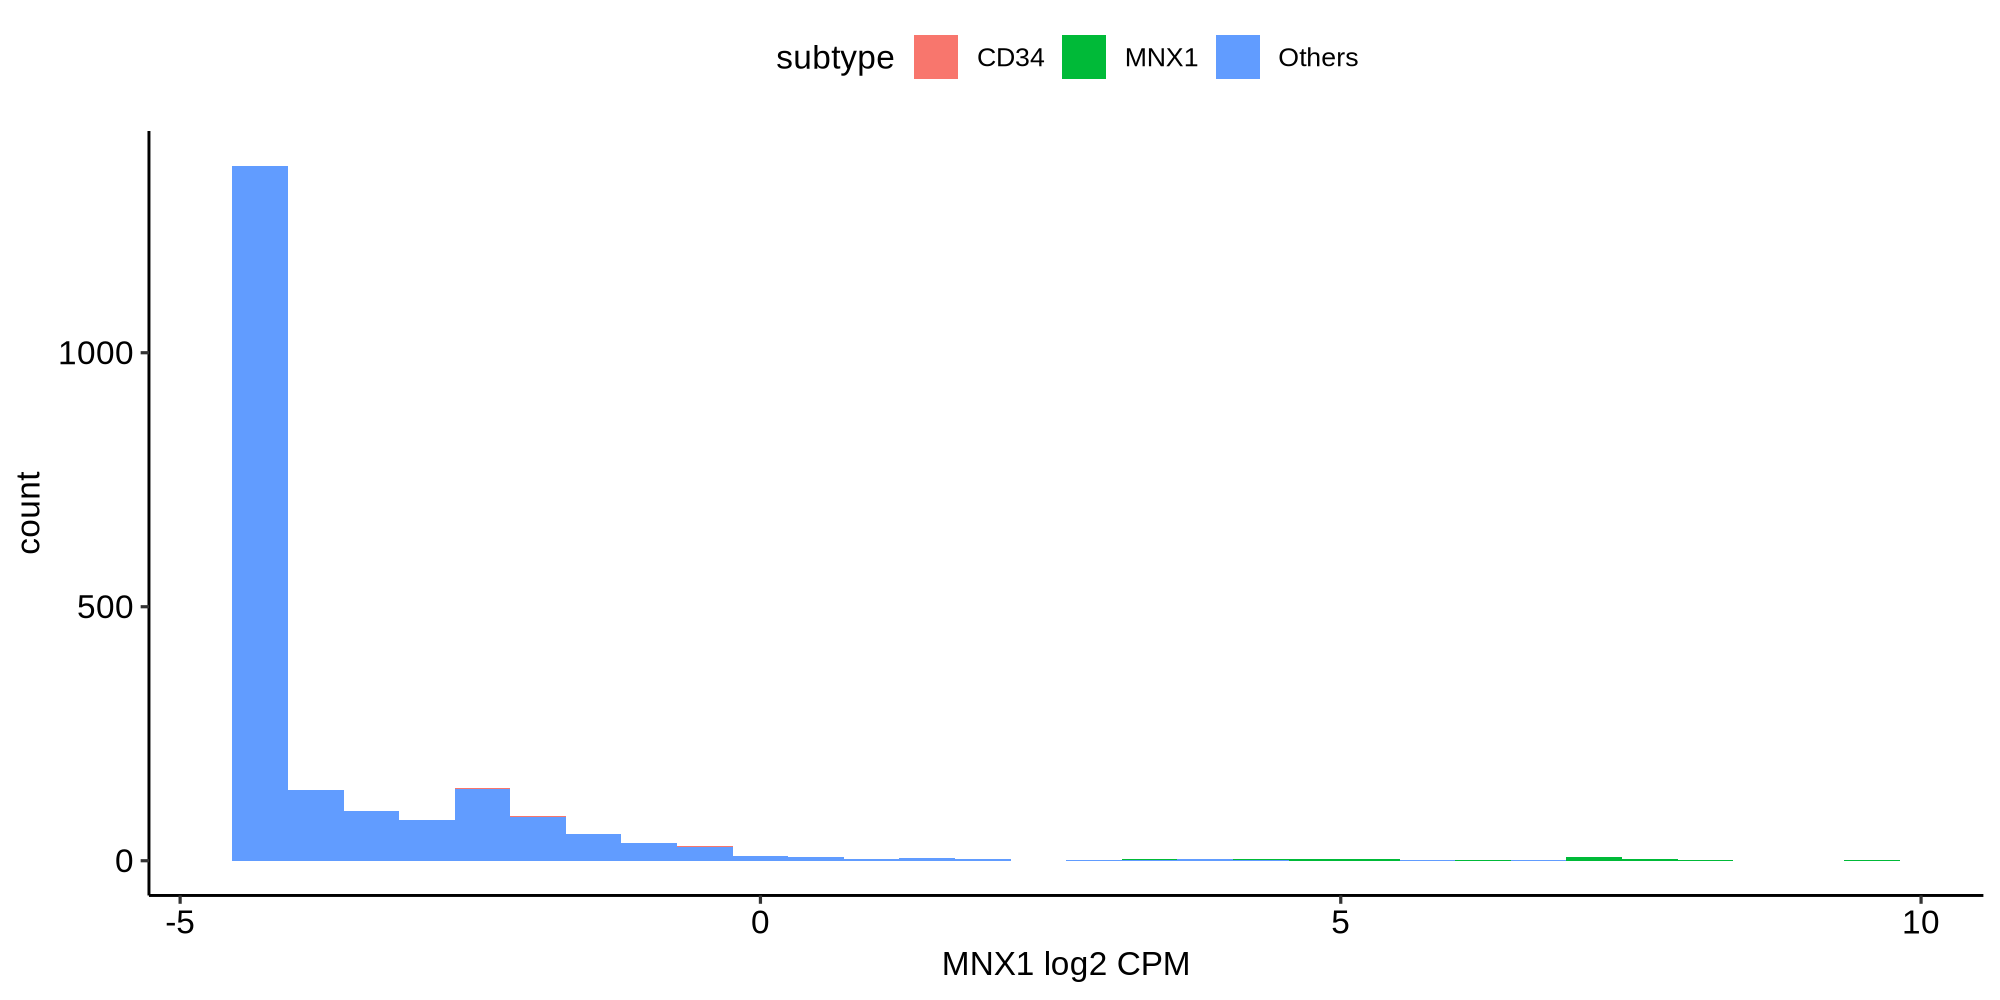

In [198]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
ggplot(plotdat, aes(MNX1, fill = subtype)) + geom_histogram() + theme_pubr() + xlab('MNX1 log2 CPM')


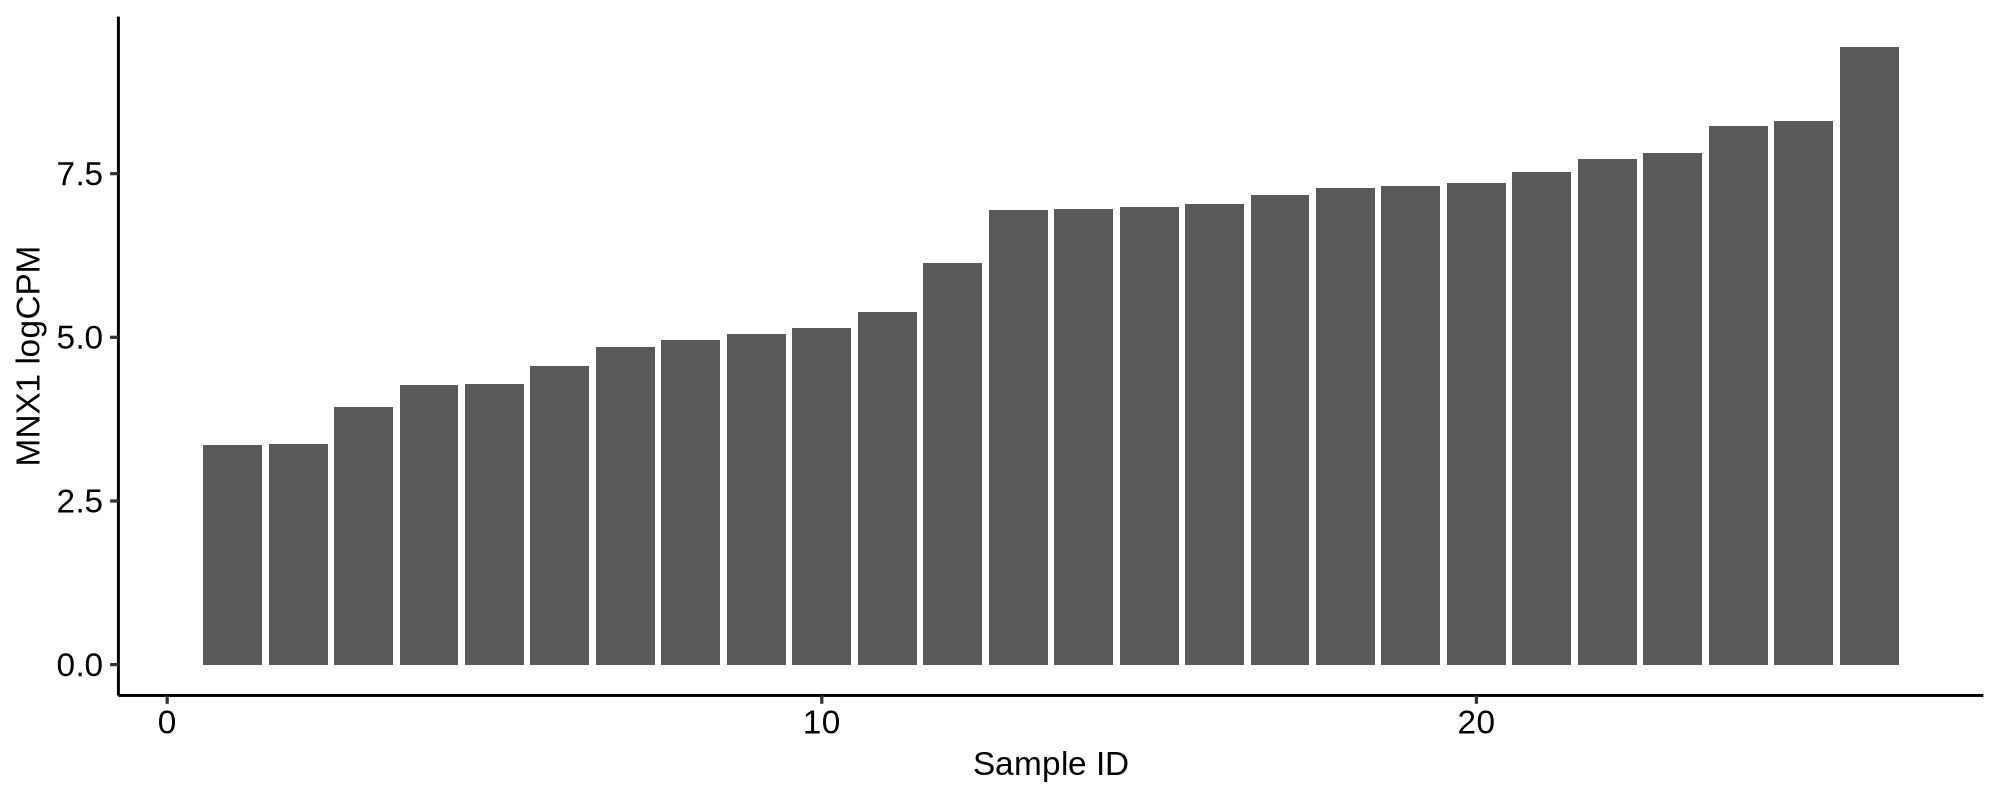

In [199]:
plotdat2 = plotdat[subtype == 'MNX1', ][order(MNX1), ]
plotdat2[, xx1 := 1:nrow(plotdat2)]
plotdat2[, xx2 := xx1 + .5 ]
plotdat2[, yy1 := MNX1]
plotdat2[, yy2 := MNX1]

options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
ggplot(plotdat2, aes(x= xx1, MNX1)) + geom_bar(stat = 'identity') + theme_pubr() + xlab('Sample ID') + ylab('MNX1 logCPM')


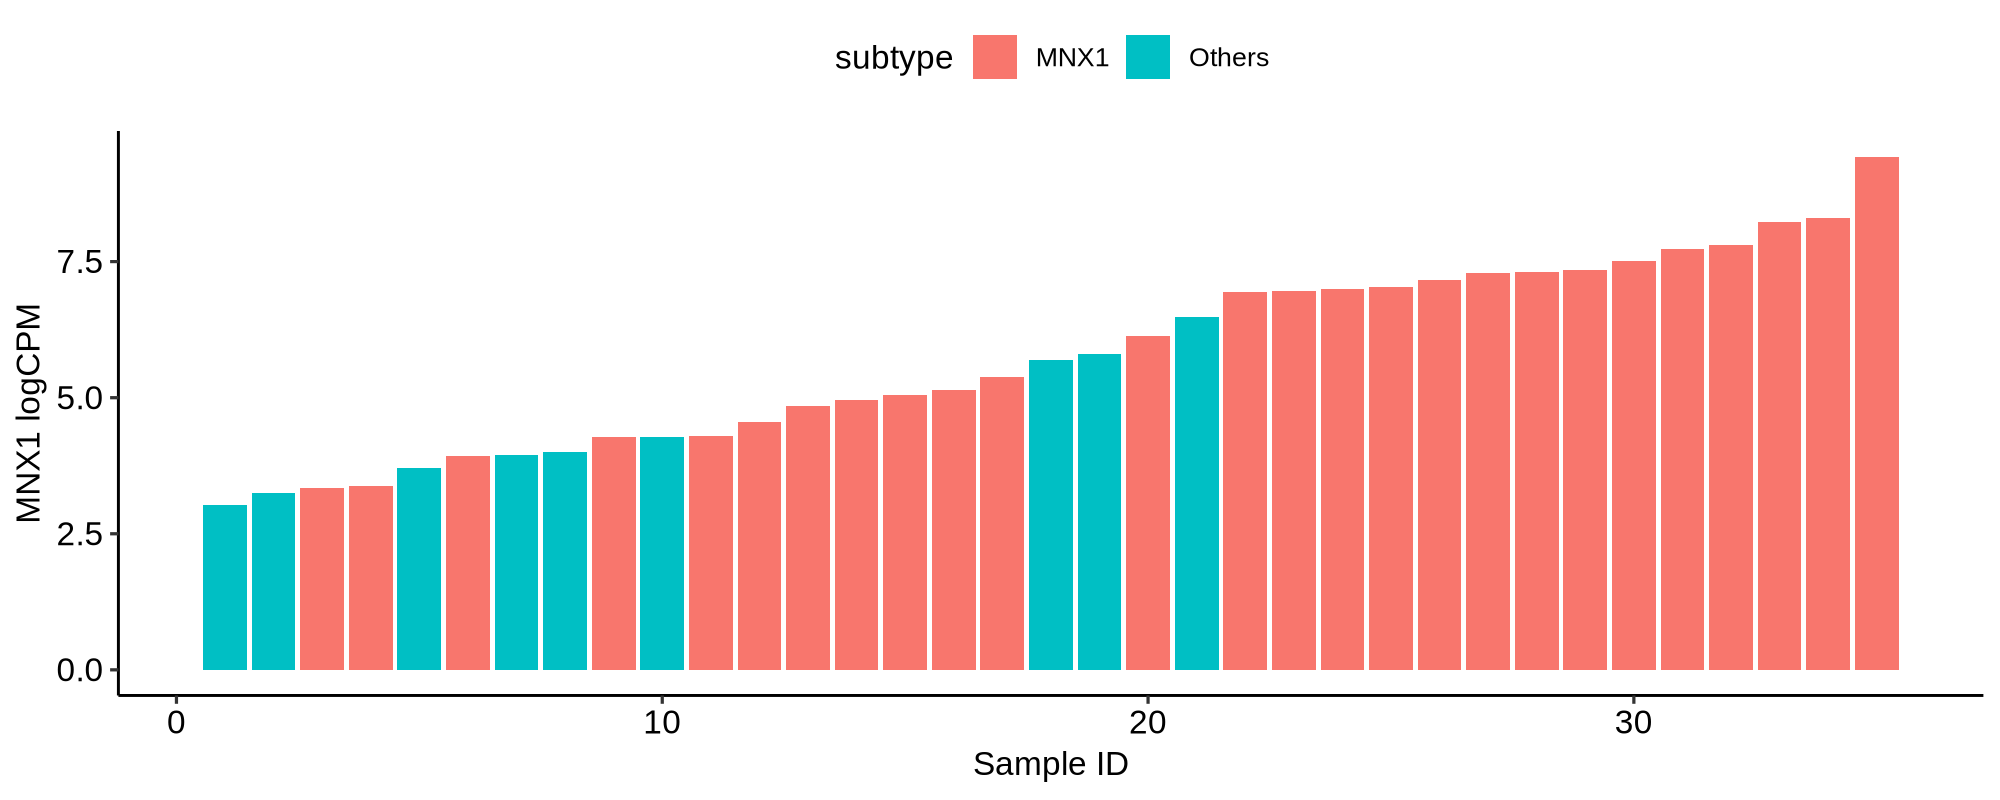

In [200]:
plotdat2 = plotdat[MNX1 > 3, ][order(MNX1), ]
plotdat2[, xx1 := 1:nrow(plotdat2)]
plotdat2[, xx2 := xx1 + .5 ]
plotdat2[, yy1 := MNX1]
plotdat2[, yy2 := MNX1]

options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
ggplot(plotdat2, aes(x= xx1, MNX1, fill = subtype)) + geom_bar(stat = 'identity') + theme_pubr() + xlab('Sample ID') + ylab('MNX1 logCPM')


In [201]:
plotdat2[MNX1 > 3 & subtype!= 'MNX1',]
sample_names = plotdat2[MNX1 > 3 & subtype!= 'MNX1', variable]
sample_names


variable         rn   MNX1     subtype xx1 xx2  yy1      yy2     
1 TARGET-20-PANLJN MNX1 3.021247 Others   1   1.5 3.021247 3.021247
2 TARGET-20-PAWWRG MNX1 3.244941 Others   2   2.5 3.244941 3.244941
3 TARGET-20-PAWMDY MNX1 3.709016 Others   5   5.5 3.709016 3.709016
4 SJAML074176_D1   MNX1 3.943138 Others   7   7.5 3.943138 3.943138
5 SJAML031343_D1   MNX1 3.998654 Others   8   8.5 3.998654 3.998654
6 SJAML032378_D1   MNX1 4.284606 Others  10  10.5 4.284606 4.284606
7 SJAML016529_D1   MNX1 5.685457 Others  18  18.5 5.685457 5.685457
8 SJAML015345_D2   MNX1 5.803657 Others  19  19.5 5.803657 5.803657
9 TARGET-20-PAWJDM MNX1 6.484403 Others  21  21.5 6.484403 6.484403

[1] "TARGET-20-PANLJN" "TARGET-20-PAWWRG" "TARGET-20-PAWMDY" "SJAML074176_D1"  
[5] "SJAML031343_D1"   "SJAML032378_D1"   "SJAML016529_D1"   "SJAML015345_D2"  
[9] "TARGET-20-PAWJDM"

In [79]:
mtx_clin_892[sample_name2 %in% sample_names, .(`CompBio sampleID`, `TBID`, `Molecular-class`, `Defining alteration`, `sample_name2`)]

CompBio sampleID TBID                 Molecular-class
1 SJAML015345_D2   TB-03-0026           NPM1           
2 SJAML016529_D1   TB-03-2111           NPM1           
3 SJAML031343_D1   TB-19-05663          Other          
4 SJAML032378_D1   TB-20-21298          NPM1           
5 SJAML040539_D1   TARGET-20-PANLJN-09A NPM1           
6 SJAML074176_D1   TB-15-7751           Other          
  Defining alteration                                                                                                       
1 NPM1|L287fs|48%                                                                                                           
2 NPM1|W288fs|52%                                                                                                           
3 NRAS|Q61K|14%; KRAS|K117N|16%; NF1|R69-E3splice|27%; BCOR|K889fs|98%; BCORL1|T477fs|100%; STAG2|T958fs|95%; U2AF1|S34Y|62%
4 NPM1|W288fs|45%                                                                                                           
5 NPM1|W288fs|60%;  CEBPA|P23fs|25%; GATA2|N363>RN|76%                                                                      
6 no fusion, no key mutation                                                                                                
  sample_name2    
1 SJAML015345_D2  
2 SJAML016529_D1  
3 SJAML031343_D1  
4 SJAML032378_D1  
5 TARGET-20-PANLJN
6 SJAML074176_D1

In [80]:
mnx1_low = min(plotdat[subtype == 'MNX1', MNX1])
mnx1_low # 2.823282
mnx1_hi_id = plotdat[MNX1 > mnx1_low, rn]
length(mnx1_hi_id)


[1] 3.347847

[1] 32

In [81]:
summary(plotdat$MNX1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -4.462  -4.462  -4.462  -3.628  -3.298   9.428 

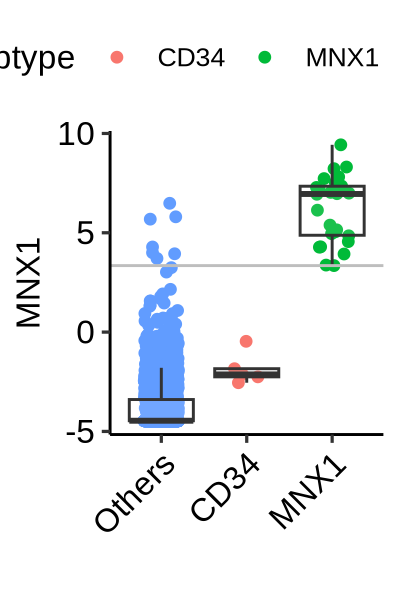

In [82]:
options(repr.plot.width = 2, repr.plot.height = 3, repr.plot.res  =200)
ggplot(plotdat, aes(reorder(subtype, MNX1, median), MNX1)) + geom_jitter(aes(color = subtype), width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + geom_hline(yintercept = mnx1_low, color = 'grey')


In [ ]:
mnx1_additional_high = plotdat[subtype == 'Others' & MNX1 > mnx1_low, variable]
mnx1_additional_high


# target gene expression

In [87]:
gene_sel = c('SIGLEC6', 'CD33', 'CD70', 'MNX1', 'ETV6')

Warning message in melt.data.table(logcpm_dt[rn %in% gene_sel, ]):
"id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rn, ...]. Consider providing at least one of 'id' or 'measure' vars in future."


variable       rn      value     subtype
1 SJAEL011880_D1 CD33     4.886304 Others 
2 SJAEL011880_D1 SIGLEC6 -1.389946 Others 
3 SJAEL011880_D1 CD70    -1.018452 Others 
4 SJAEL011880_D1 MNX1    -4.461827 Others 
5 SJAEL011880_D1 ETV6     5.900163 Others 
6 SJAEL011881_D1 CD33     2.938518 Others

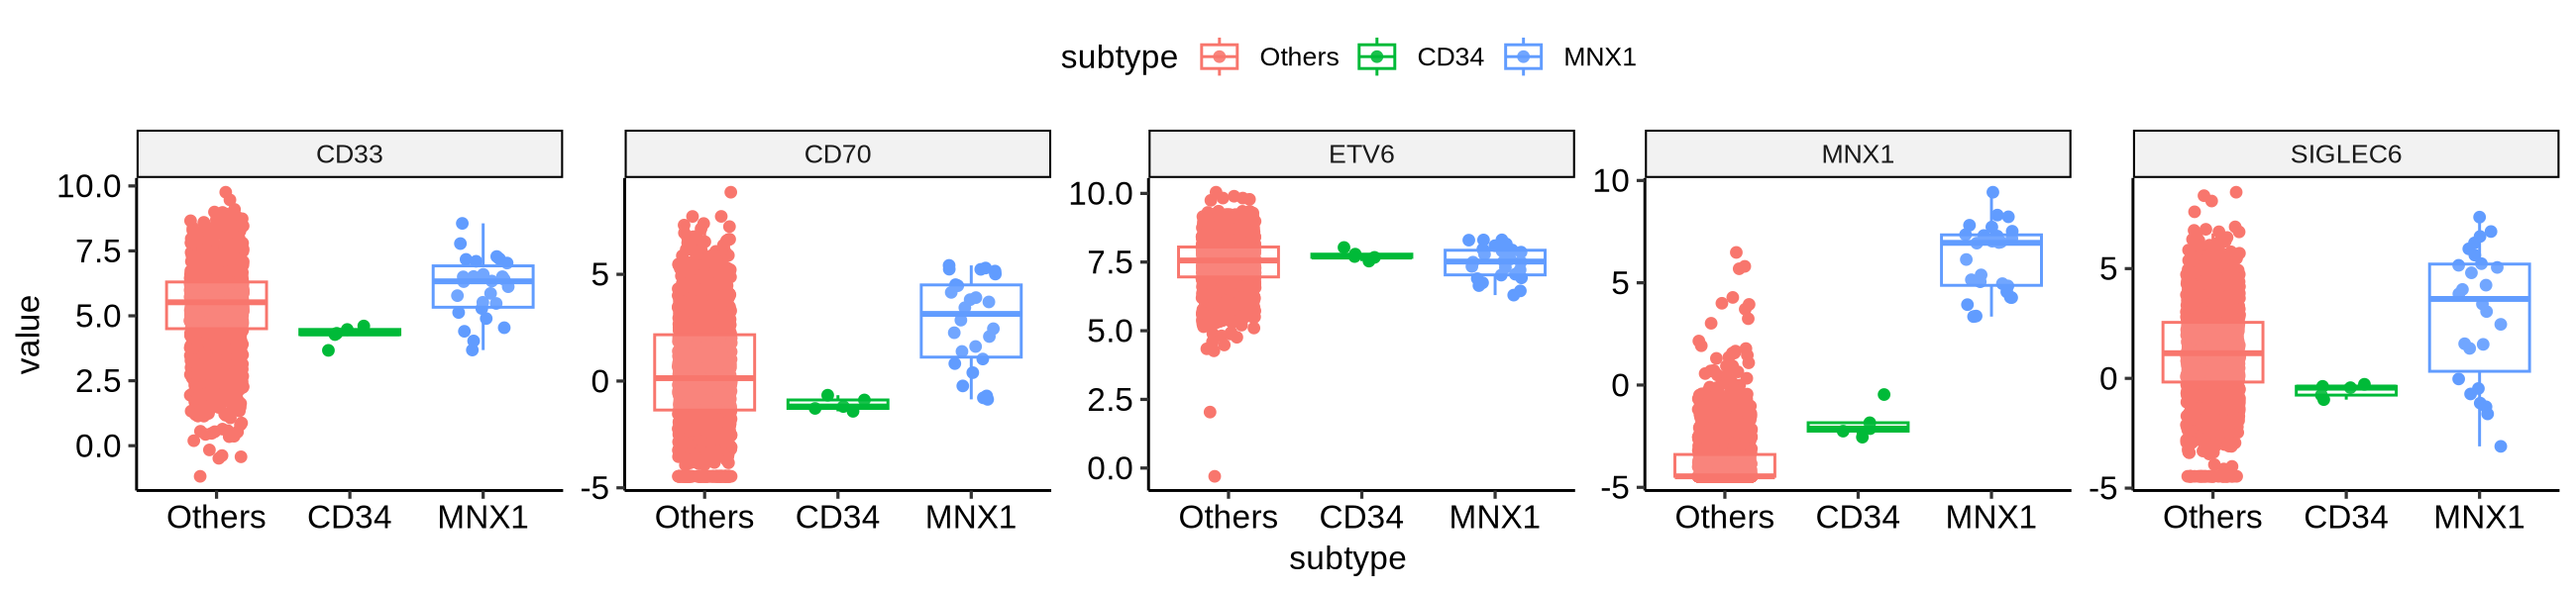

In [89]:
plotdat = as.data.table(melt(logcpm_dt[rn %in% gene_sel, ] ))
plotdat = merge(plotdat, dsn[, c('sample_name', 'subtype')], by.x = 'variable', by.y = 'sample_name', all.x = T)
plotdat[, subtype := factor(subtype, levels = c('Others', 'CD34', 'MNX1'))]
head(plotdat)

options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
ggplot(plotdat, aes(x = subtype, value, color = subtype)) + geom_jitter(width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + theme_pubr() + facet_wrap(~ rn, nrow = 1, scales = 'free')


# MA plot

Warning message:
"Removed 18547 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


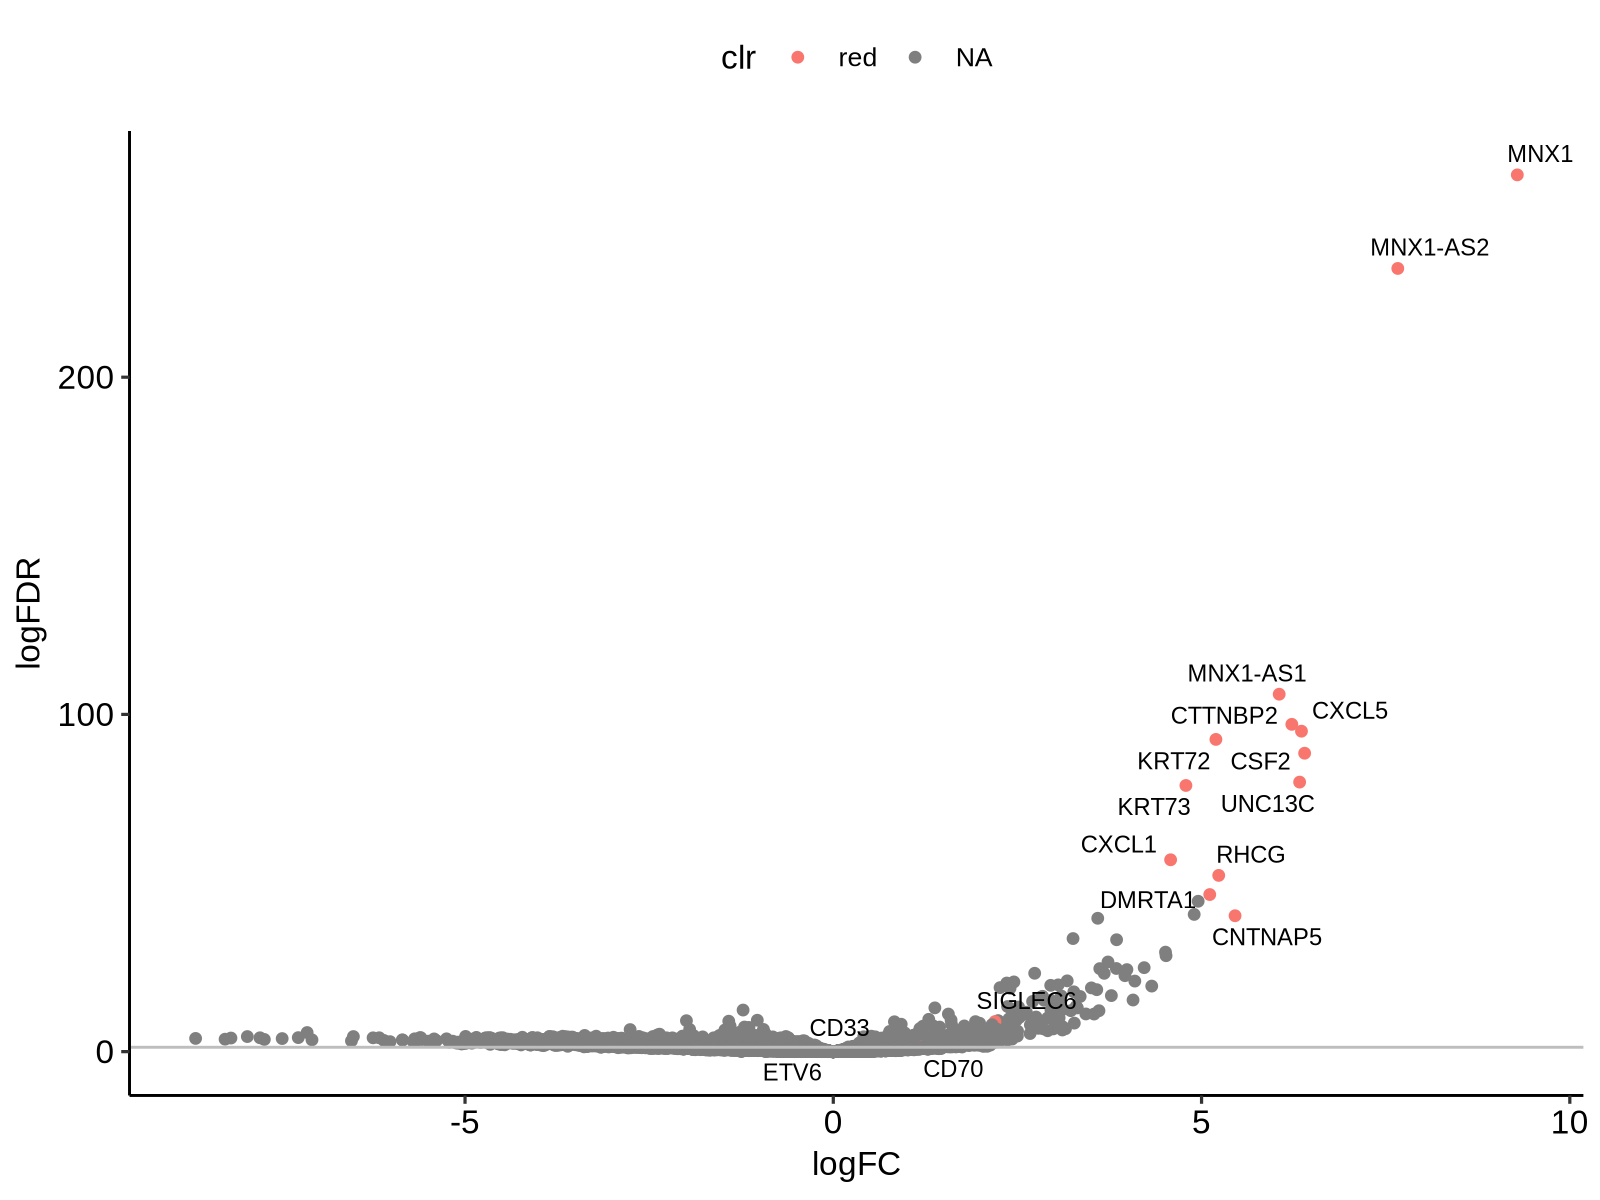

In [90]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = res_mnx1_vs_pAML[!duplicated(rn), ]
plotdat[logFC < -10, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05, lbl := rn]
plotdat[rn %in% gene_sel, lbl := rn]
plotdat[, logFDR := -log(FDR, 10)] 
plotdat[logFDR > 50, lbl := rn]
plotdat[!is.na(lbl), clr := 'red'] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel(size = 3)


Warning message:
"Removed 18463 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."
Warning message:
"ggrepel: 94 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


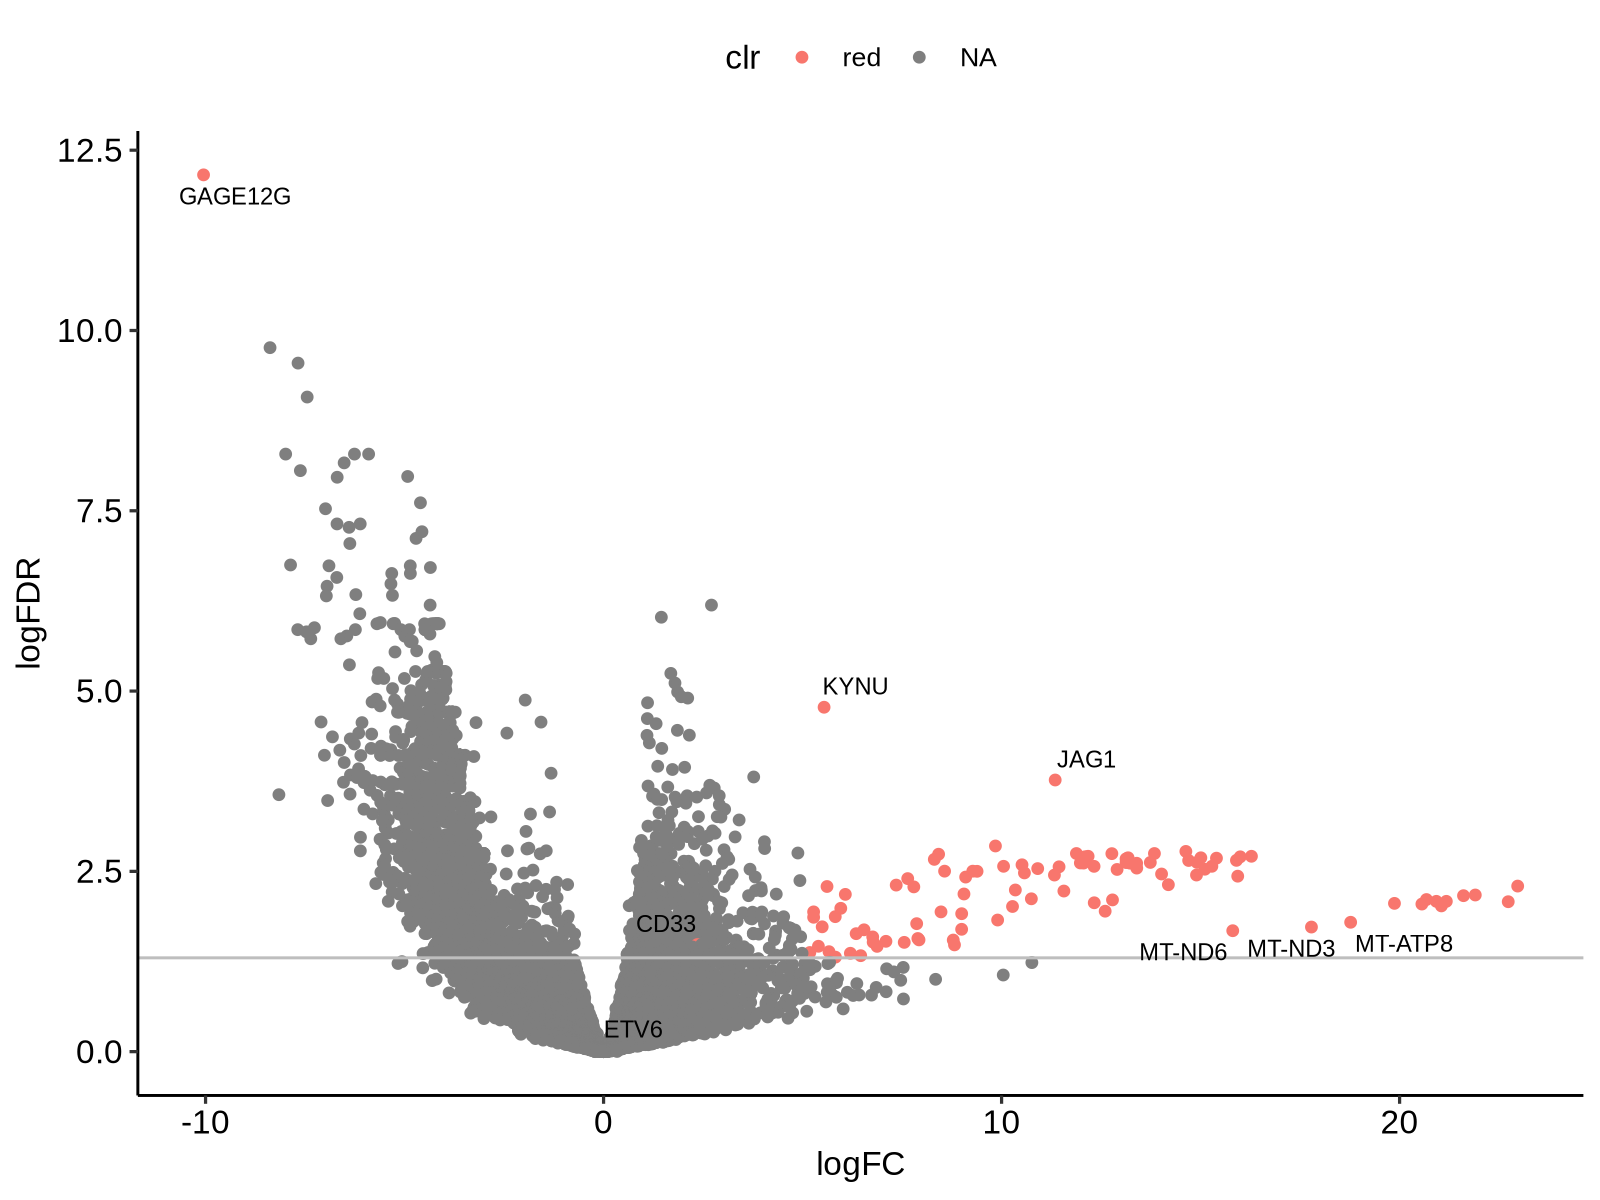

In [91]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = res_mnx1_vs_cd34[!duplicated(rn), ]
plotdat[logFC < -10, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05, lbl := rn]
plotdat[rn %in% gene_sel, lbl := rn]
plotdat[, logFDR := -log(FDR, 10)] 
plotdat[logFDR > 50, lbl := rn]
plotdat[!is.na(lbl), clr := 'red'] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel(size = 3)


# pathway analysis

## pathway anlaysis

In [92]:
head(res_mnx1_vs_pAML)


rn       logFC    logCPM     F         PValue        FDR           ranking  
1 MNX1     9.287120  0.8118216 1636.0104 5.423836e-265 1.006881e-260  400.0000
2 MNX1-AS2 7.664348 -3.3866226 1413.1852 6.108962e-237 5.670338e-233 1810.4266
3 MNX1-AS1 6.054171 -3.7139311  563.3157 1.639298e-110 1.014398e-106  664.6592
4 CTTNBP2  6.225580 -1.0117729  510.9932 1.901368e-101  8.824249e-98  627.0463
5 CXCL5    6.356697  1.6137162  498.9006  2.533699e-99  9.407118e-96  626.7464
6 KRT72    5.194924  0.8418574  484.5988  8.346359e-97  2.582363e-93  499.1205

In [93]:
res_mnx1_vs_pAML[, ranking := -logFC*log10(PValue)]
tmp = res_mnx1_vs_pAML[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn
head(ranking)


MNX1  MNX1-AS2  MNX1-AS1   CTTNBP2     CXCL5     KRT72 
2454.2673 1810.4266  664.6592  627.0463  626.7464  499.1205

In [94]:
pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="C2", subcategory = 'CP:REACTOME') 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="H")
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)



pathway                          pval        padj       log2err   ES        
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 0.001691356 0.08456782 0.4550599  0.9229760
2 HALLMARK_IL6_JAK_STAT3_SIGNALING 0.060728635 0.88737201 0.3217759  0.9127203
3 HALLMARK_ESTROGEN_RESPONSE_LATE  0.076163611 0.88737201 0.1918922 -0.6136469
4 HALLMARK_APICAL_SURFACE          0.083017572 0.88737201 0.2878051  0.8552083
5 HALLMARK_IL2_STAT5_SIGNALING     0.088737201 0.88737201 0.2820134  0.8027985
6 HALLMARK_INFLAMMATORY_RESPONSE   0.106529210 0.88774341 0.2572065  0.7744450
  NES       size leadingEdge  logFDR   updn
1  1.643978 192  CSF2, CX.... 9.207604 UP  
2  1.639519  87  CSF2, CX.... 4.041479 UP  
3 -1.248262 194  IGSF1, C.... 3.714754 DN  
4  1.495577  43  RHCG, SH.... 3.590439 UP  
5  1.436303 193  CSF2, CO.... 3.494317 UP  
6  1.386935 196  CCL7, ME.... 3.230679 UP

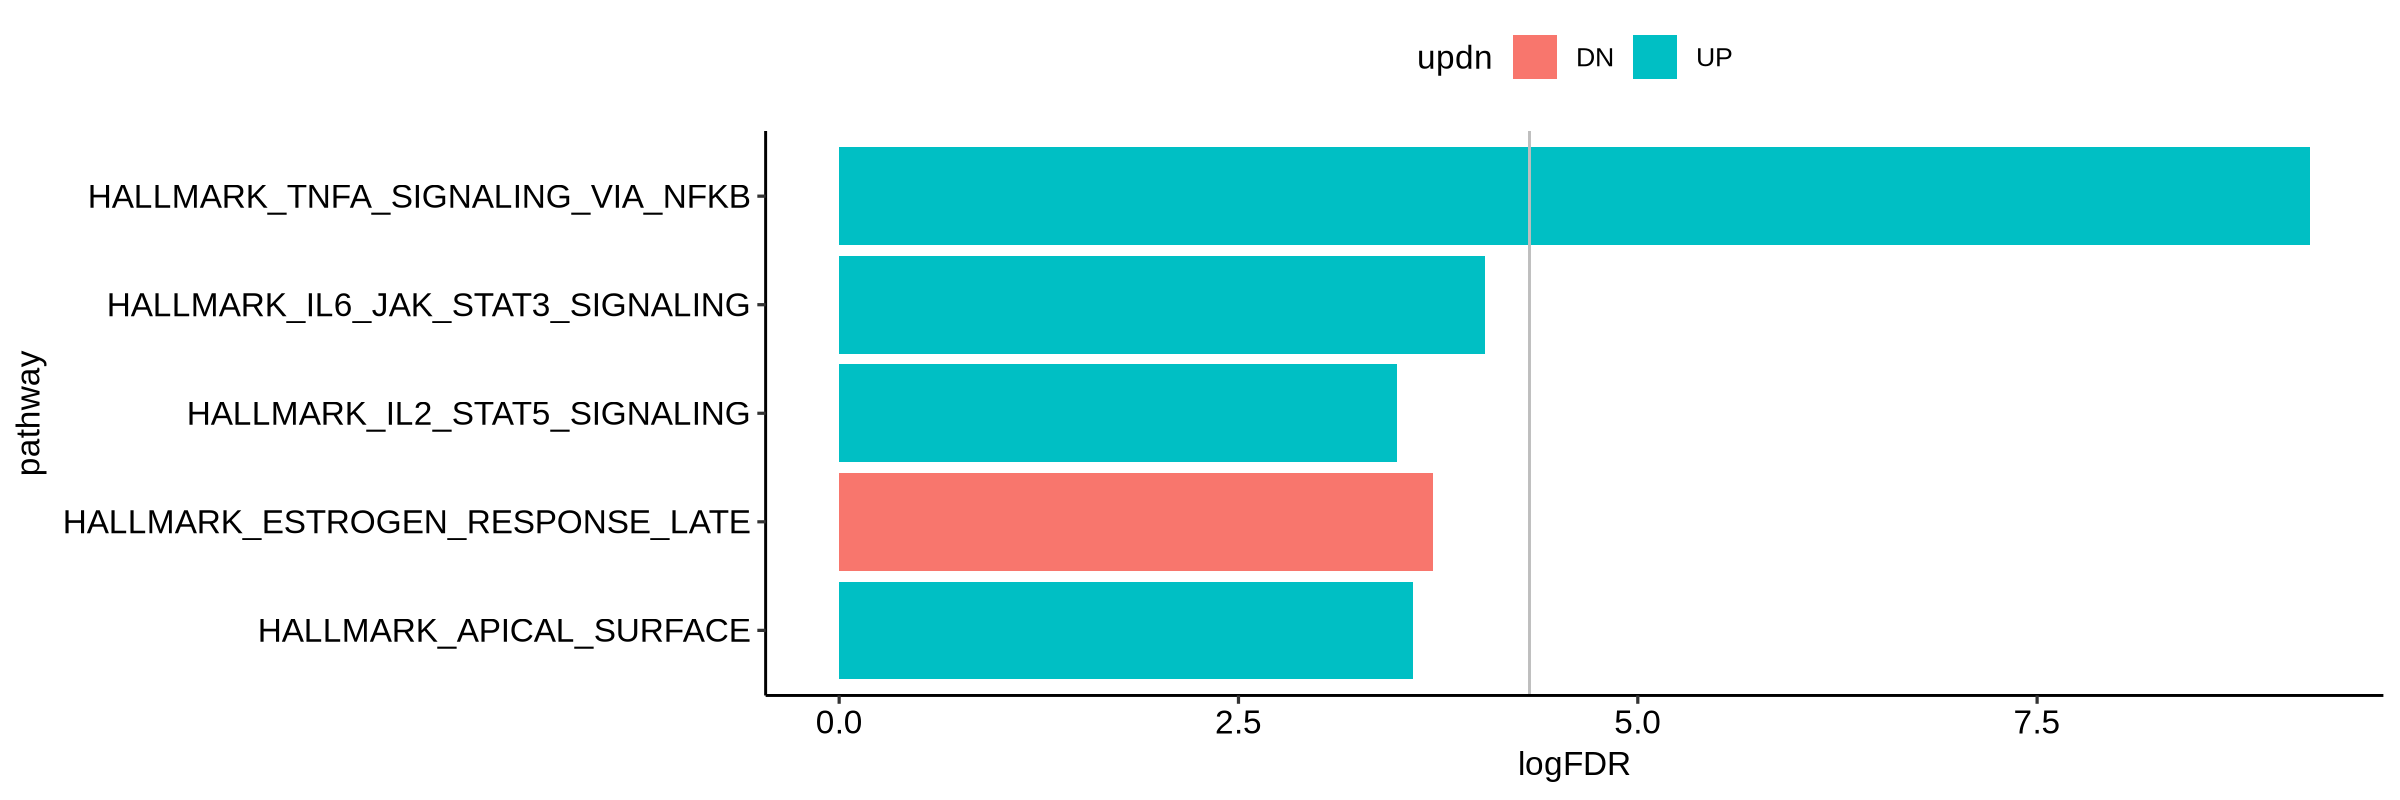

In [97]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][1:5, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr() + geom_hline(yintercept = -log2(0.05), color = 'grey') 


In [98]:
# save gene list for late usage
tnfa_leading_genes = unlist(fgseaRes[1, leadingEdge])
length(gene_sel)


[1] 5

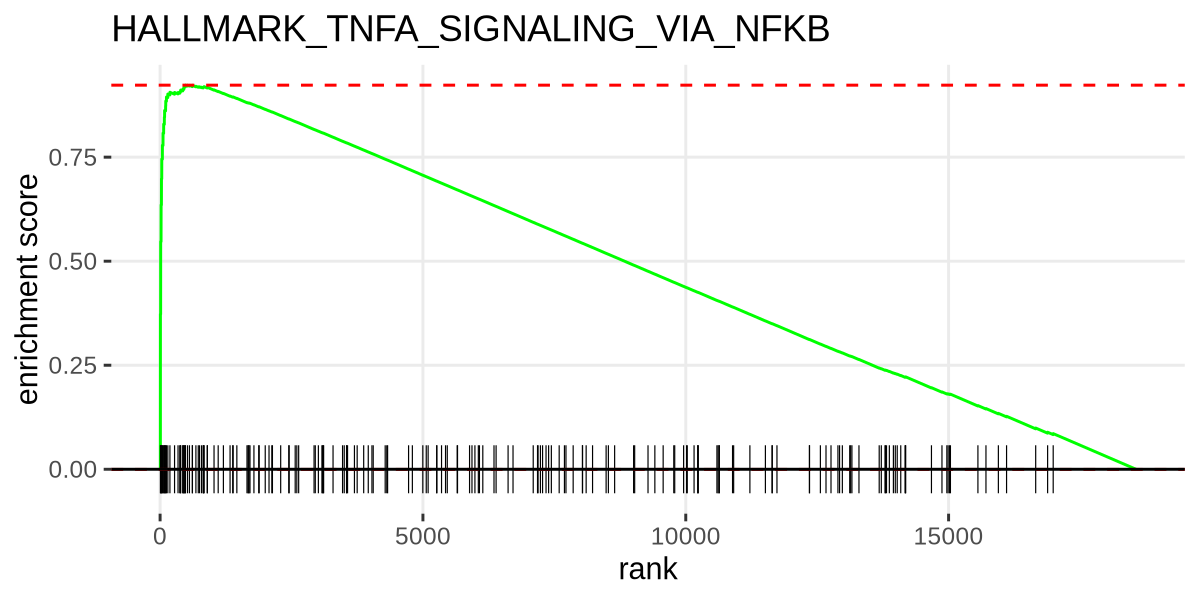

In [99]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]], ranking) + 
labs(title="HALLMARK_TNFA_SIGNALING_VIA_NFKB")


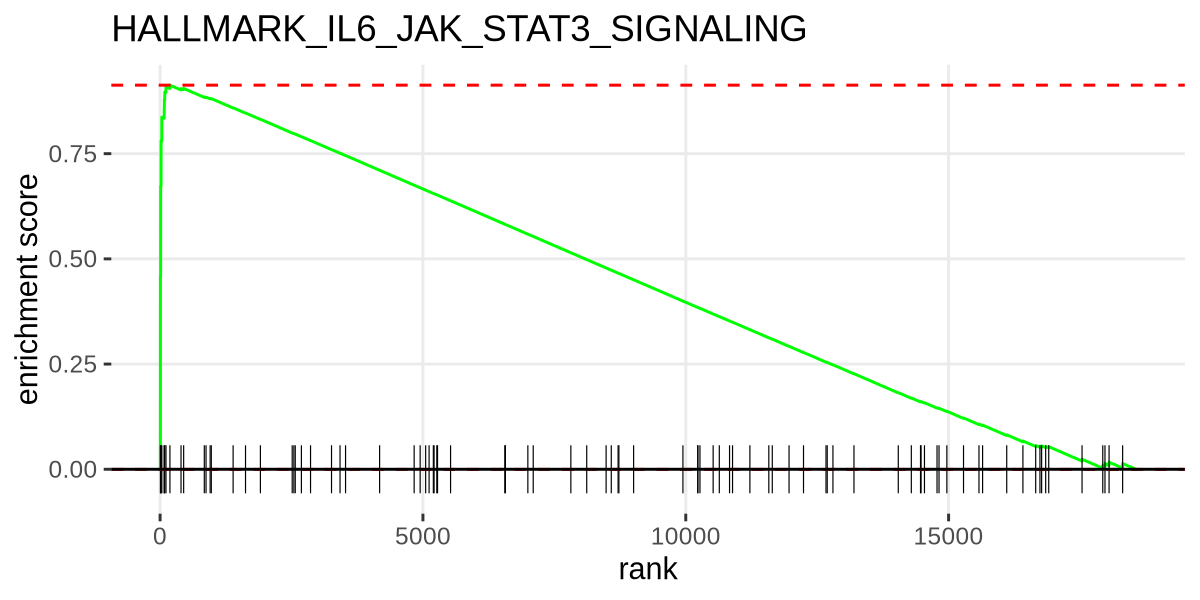

In [100]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["HALLMARK_IL6_JAK_STAT3_SIGNALING"]], ranking) + 
labs(title="HALLMARK_IL6_JAK_STAT3_SIGNALING")


$GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_DN
  [1] "ABCA2"    "ABCC5"    "ABHD14A"  "ACADM"    "ACP5"     "ACP6"    
  [7] "ADAM22"   "ADCY7"    "ADGRG3"   "AKAP9"    "ANKRD10"  "ARL4C"   
 [13] "ASH1L"    "B3GALT6"  "BCKDHB"   "BCL2"     "BCL2L11"  "BRD3"    
 [19] "C12orf57" "C5orf51"  "C6orf136" "C6orf136" "C6orf136" "C6orf136"
 [25] "C6orf136" "C6orf136" "C6orf136" "CA12"     "CANT1"    "CCND2"   
 [31] "CCNL2"    "CCR7"     "CD7"      "CD96"     "CHCHD7"   "CIPC"    
 [37] "COQ9"     "COX7A2L"  "CRLF3"    "CST7"     "CTSW"     "CYP4V2"  
 [43] "DALRD3"   "DBNDD2"   "DBP"      "DDIT3"    "DDX51"    "DDX51"   
 [49] "DGKA"     "DIAPH2"   "DNAAF10"  "DPH5"     "DUSP12"   "EIF2AK4" 
 [55] "ELP3"     "EMB"      "EML5"     "EOMES"    "EPS15L1"  "EVL"     
 [61] "EZH1"     "FAM189B"  "FAM189B"  "FAM189B"  "FAM8A1"   "GALNT11" 
 [67] "GBE1"     "GMIP"     "GNL2"     "GSTK1"    "GTF2I"    "H2AJ"    
 [73] "HSD17B11" "HSD17B8"  "HSD17B8"  "HSD17B8"  "HSD17B8"  "HSD17B8" 
 [79] "HSD17B8"  "HSF1"     "HSF1"     "IAPP"     "ICE1"     "IFITM10" 
 [85] "IFITM10"  "IL4R"     "IL6R"     "IL6ST"    "IL7R"     "ITM2C"   
 [91] "ITPR2"    "JUN"      "KCNJ8"    "KLF17"    "KLF2"     "LAMP1"   
 [97] "LTB"      "LTB"      "LTB"      "LTB"      "LTB"      "LTB"     
[103] "LTB"      "LTB"      "LYSMD1"   "LYSMD2"   "MAN2C1"   "MAP4K3"  
[109] "MBP"      "MCOLN2"   "MECP2"    "METTL3"   "MFNG"     "MLYCD"   
[115] "MRPL23"   "MRPL23"   "MTFR1L"   "NACC2"    "NCKAP1"   "NDUFA7"  
[121] "NECAP1"   "NEDD4"    "NEDD4L"   "NOTCH4"   "NOTCH4"   "NOTCH4"  
[127] "NOTCH4"   "NOTCH4"   "NOTCH4"   "NOTCH4"   "NSG2"     "PAQR7"   
[133] "PDGFB"    "PDK1"     "PDRG1"    "PHLDB1"   "PISD"     "PLEKHA1" 
[139] "PLEKHA5"  "POLR1B"   "POLR3A"   "PPOX"     "PPP1R14B" "PRKACB"  
[145] "PRMT3"    "PRSS12"   "PSME2"    "PSME2"    "PTPN22"   "PURA"    
[151] "QDPR"     "RABAC1"   "RAD52"    "RASA4"    "RASSF5"   "RERE"    
[157] "RFLNB"    "RFLNB"    "RGS10"    "RNASE4"   "RPL14"    "RPL19"   
[163] "RPL39"    "RPLP0"    "RPLP1"    "RPP14"    "RPS16"    "RPS18"   
[169] "RPS18"    "RPS18"    "RPS18"    "RPS18"    "RPS18"    "RPS18"   
[175] "RPS19"    "RPS23"    "RPS7"     "RPS8"     "RRP1B"    "RTKN"    
[181] "RTTN"     "SBDS"     "SELL"     "SEMA4B"   "SESN1"    "SETD4"   
[187] "SH3BP5"   "SHISA5"   "SIAH1"    "SIPA1L2"  "SIT1"     "SIX6"    
[193] "SLC11A2"  "SLC12A7"  "SLC12A7"  "SLC26A2"  "SLTM"     "SNRK"    
[199] "SPICE1"   "STAT4"    "SUPT6H"   "SURF2"    "SURF2"    "SUSD6"   
[205] "TAF1A"    "TAF1C"    "TCF7"     "TDRP"     "TESK1"    "TK2"     
[211] "TLK2"     "TMC6"     "TMED4"    "TNIP1"    "TRAF1"    "TRAF3IP2"
[217] "TRAF5"    "TRMT1"    "TSEN34"   "TSEN34"   "TSEN34"   "TSEN34"  
[223] "TSEN34"   "TSEN34"   "TSEN34"   "TSEN34"   "TSEN34"   "TSEN34"  
[229] "TSR1"     "TTC14"    "TTC27"    "TTC3"     "TXK"      "UBLCP1"  
[235] "USP18"    "VKORC1"   "WDR13"    "WDR43"    "WDR75"    "XPC"     
[241] "XRCC5"    "YPEL3"    "ZBTB20"   "ZEB1"     "ZFP1"     "ZFP1"    
[247] "ZFP90"    "ZKSCAN3"  "ZNF274"   "ZNF692"

pathway                                                    pval        
1 GSE15750_DAY6_VS_DAY10_EFF_CD8_TCELL_DN                    1.520957e-05
2 GSE37416_CTRL_VS_3H_F_TULARENSIS_LVS_NEUTROPHIL_DN         1.385447e-04
3 GSE17721_CTRL_VS_PAM3CSK4_0.5H_BMDC_UP                     2.016432e-04
4 GSE9988_LOW_LPS_VS_CTRL_TREATED_MONOCYTE_UP                4.515542e-04
5 GSE21670_UNTREATED_VS_IL6_TREATED_STAT3_KO_CD4_TCELL_DN    5.133491e-04
6 GSE36392_TYPE_2_MYELOID_VS_EOSINOPHIL_IL25_TREATED_LUNG_UP 1.461816e-03
  padj       log2err   ES        NES      size leadingEdge  logFDR    updn
1 0.07410104 0.5933255 0.9581420 1.698742 181  MNX1, DM.... 16.004661 UP  
2 0.32746856 0.5188481 0.9419161 1.663790 183   MNX1, ABTB2 12.817361 UP  
3 0.32746856 0.5188481 0.9423337 1.662596 184    MNX1, EQTN 12.275908 UP  
4 0.50020733 0.4984931 0.9408414 1.649138 174  CXCL5, R.... 11.112813 UP  
5 0.50020733 0.4772708 0.9369243 1.653051 184  CXCL5, C.... 10.927772 UP  
6 1.00000000 0.4550599 0.9366727 1.658500 180    MNX1, HES1  9.418022 UP

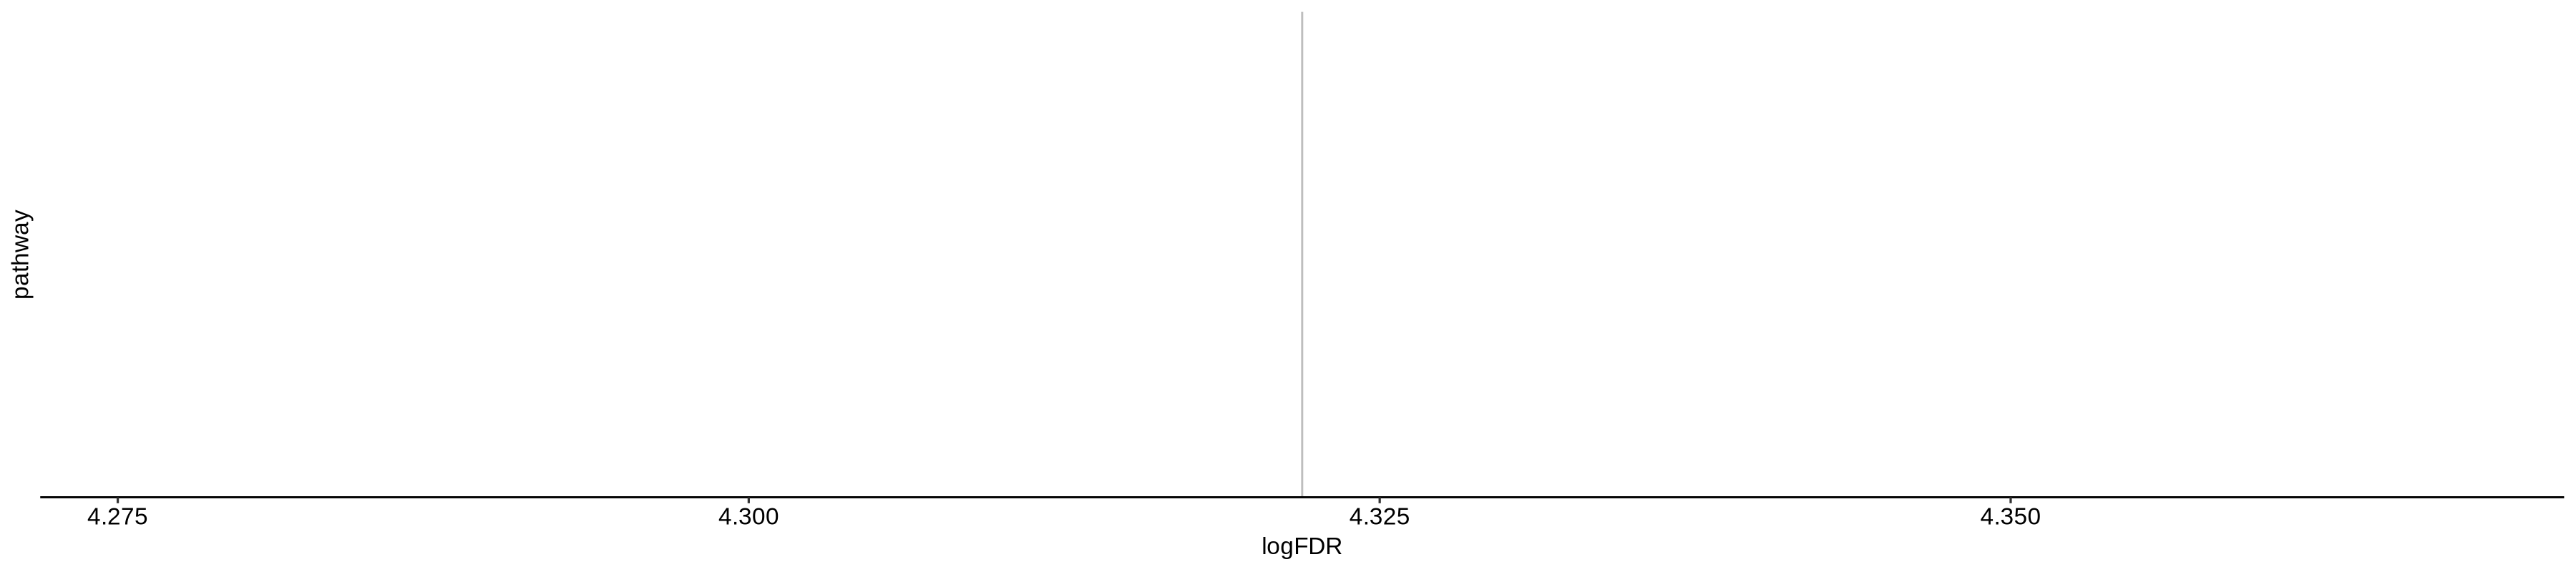

In [101]:
pathwaysDF <- msigdbr(species = "Homo sapiens", category="C7", subcategory = 'IMMUNESIGDB') 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="C2", subcategory = 'CP:REACTOME') 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="H")
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)
pathways[1]

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)

options(repr.plot.width = 18, repr.plot.height = 4, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr() + geom_hline(yintercept = -log2(0.05), color = 'grey') 


## heatmap of the pathway genes

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 9, repr.plot.res = 100)
column_ha = HeatmapAnnotation(df = dsn[, 'subtype', drop = F])
platdat = scale_fun(logcpm[tnfa_leading_genes, ])
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

Heatmap(platdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F,  show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn$subtype, levels = c('CD34', 'Others', 'MNX1'))) 


# ETV6  hi vs low 

## make etv6 high, low, intermediate IDs

In [6]:
dim(logcpm)

[1] 25216  1393

In [148]:
summary(logcpm['MNX1', ])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -3.349   2.935   4.254   4.084   5.297   7.787    1868 

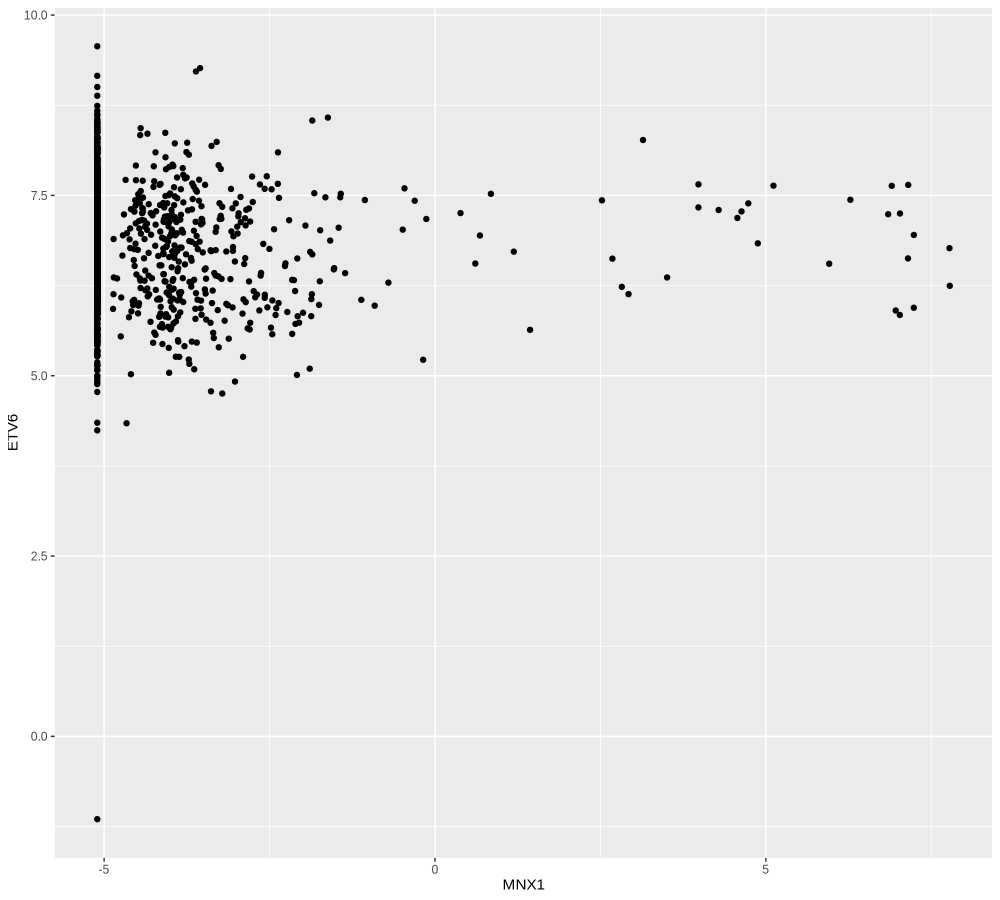

In [7]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
plotdat = as.data.table(t(logcpm[c('MNX1', 'ETV6'), ]), keep.rownames = T)
plotdat[is.na(MNX1), MNX1 := -3.5]
ggplot(plotdat, aes(MNX1, ETV6)) + geom_point()


In [9]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
two_gene[is.na(MNX1), MNX1 := -3.5]
ggplot(two_gene[ETV6 > 6.5, ], aes(MNX1, ETV6, color = subtype)) + geom_point() +  theme_pubr()


ERROR: Error in eval(expr, envir, enclos): object 'two_gene' not found


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


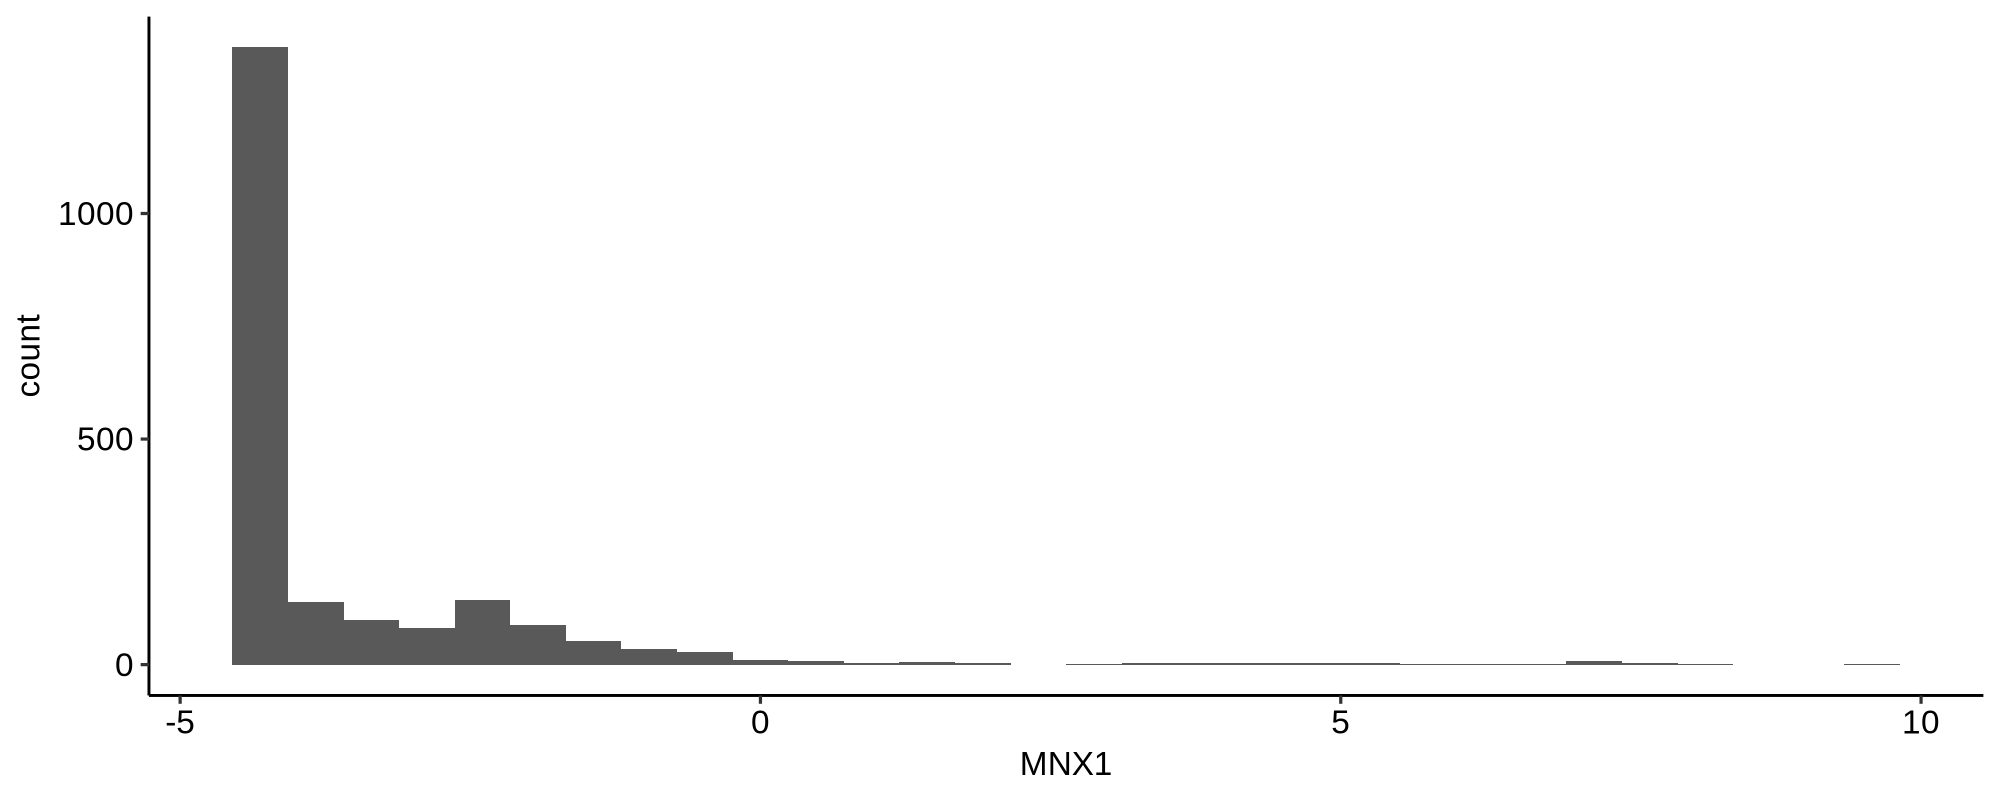

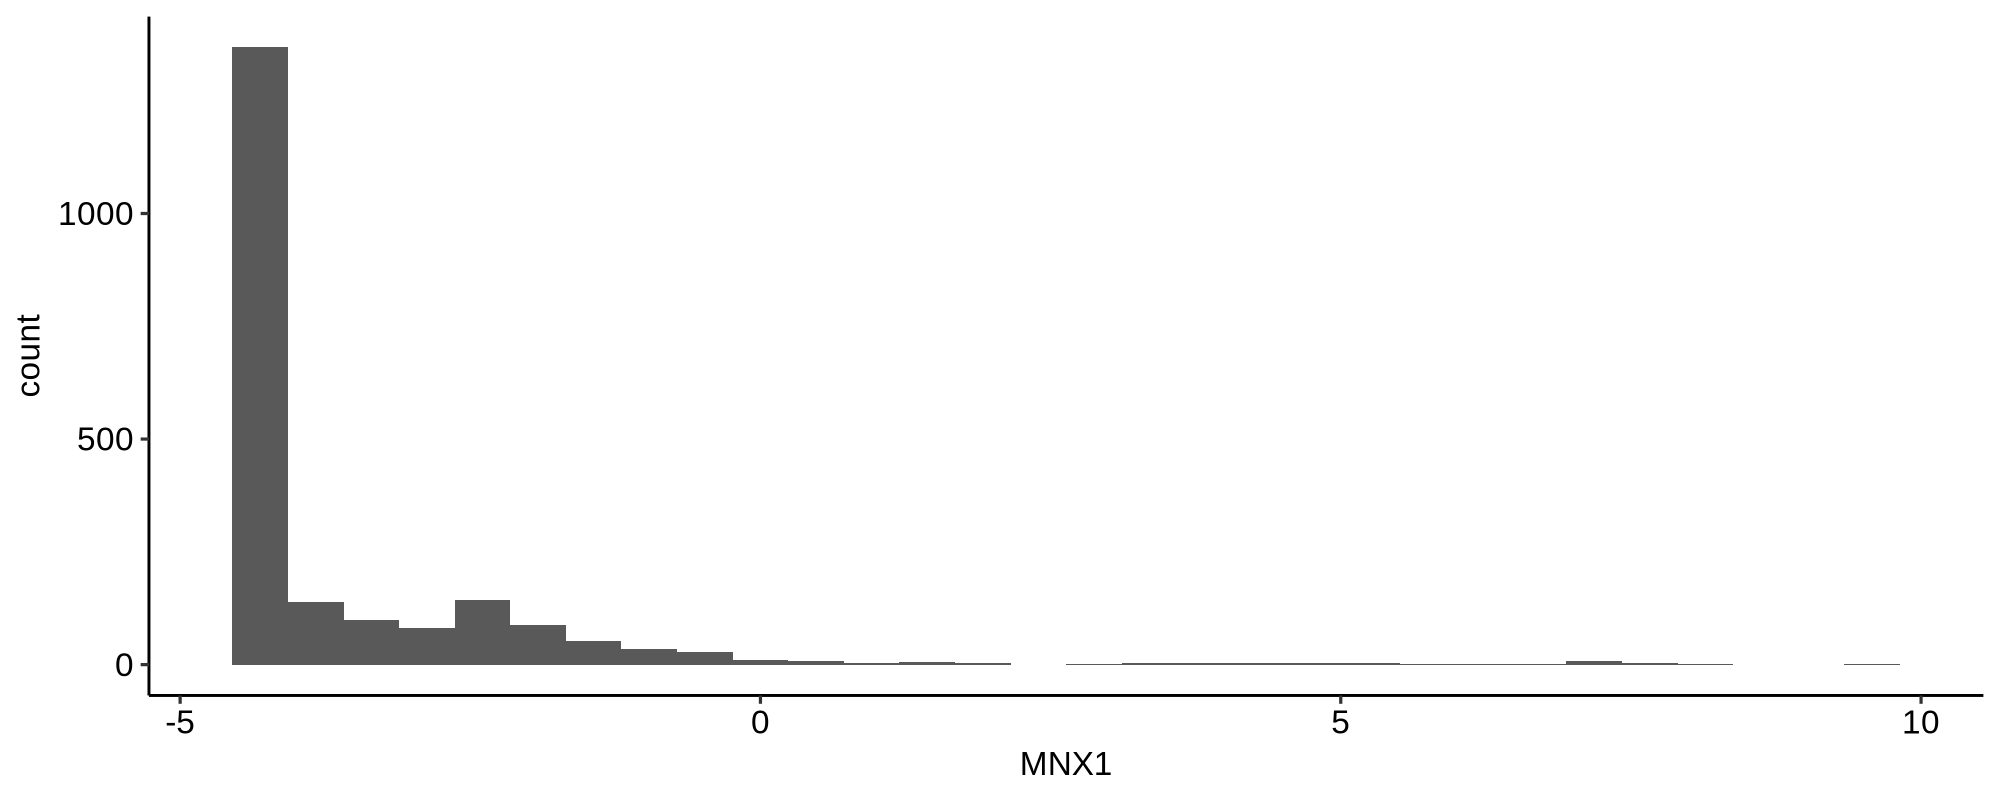

In [104]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200)
ggplot(plotdat, aes(MNX1)) + geom_histogram() + theme_pubr()
ggplot(plotdat[plotdat$MNX1 > -4.56805, ], aes(MNX1)) + geom_histogram() + theme_pubr()

In [105]:
nrow(plotdat[MNX1 < -4.568, ])

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


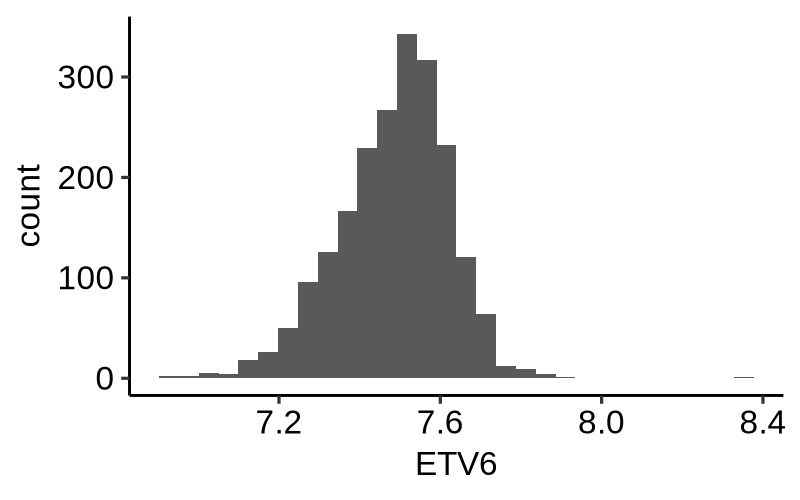

In [159]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)
ggplot(plotdat[ETV6 > 6.5, ], aes(ETV6)) + geom_histogram() + theme_pubr()

In [164]:
plotdat2 = plotdat[ETV6 > 2.5, ]
quantile(plotdat2$ETV6)

0%      25%      50%      75%     100% 
5.003681 7.402816 7.500644 7.576360 8.338924

In [165]:
etv6_lo_mnx1lo_id = plotdat2[ETV6 < 6.7741011513844 & MNX1 < -4.568, rn] 
etv6_hi_mnx1lo_id = plotdat2[ETV6 > 7.95795213001927 & MNX1 < -4.568, rn ]
etv6_int_mnx1lo_id = plotdat2[ETV6 < 7.95795213001927 & ETV6 > 6.7741011513844 & MNX1 < -4.568, rn ]


In [166]:
etv6_lo_id = plotdat2[ETV6 < 6.7741011513844, rn] 
etv6_hi_id = plotdat2[ETV6 > 7.95795213001927, rn ]
etv6_int_id = plotdat2[ETV6 < 7.95795213001927 & ETV6 > 6.7741011513844, rn ]


In [167]:
mnx1_lo = plotdat2[MNX1 < -4.568, rn] 
mnx1_int = plotdat2[MNX1 > -4.568 & MNX1 < 3.2, rn] 
mnx1_hi = plotdat2[MNX1 > 3.20896335152305, rn]


## ETV6 low vs high 

In [ ]:
head(etv6_lo_id)

In [168]:
# etv6 low vs high
mtx2 = mtx[, c(etv6_lo_id, etv6_hi_id)] 
dsn2 = data.frame(condition = c(rep('lo', length(etv6_lo_id)), rep('hi', length(etv6_hi_id))), 
                                    rownames = c(etv6_lo_id, etv6_hi_id))
condition = factor(dsn2$condition, levels = c('hi', 'lo'))
dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)
lrt = glmLRT(fit, coef=2)
res_etv6 = topTags(lrt, n = nrow(mtx2))
res_etv6 = as.data.table(res_etv6$table, keep.rownames = T)
head(res_etv6)
             

rn        logFC      logCPM   LR       PValue       FDR        
1 SNORD3C   -11.074891 8.040067 28.93055 7.502026e-08 0.001010523
2 TRH        -9.711763 5.227313 22.11576 2.566932e-06 0.017288288
3 IGLL1      -8.878770 5.894011 20.06281 7.493979e-06 0.033647965
4 LDLRAD2    -9.548920 4.122238 16.54511 4.750635e-05 0.154404895
5 SNORD3B-1  -8.058979 9.368348 16.18939 5.731436e-05 0.154404895
6 PRSS57     -7.059969 5.866165 15.82466 6.949099e-05 0.156007266

Warning message:
"Removed 13469 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


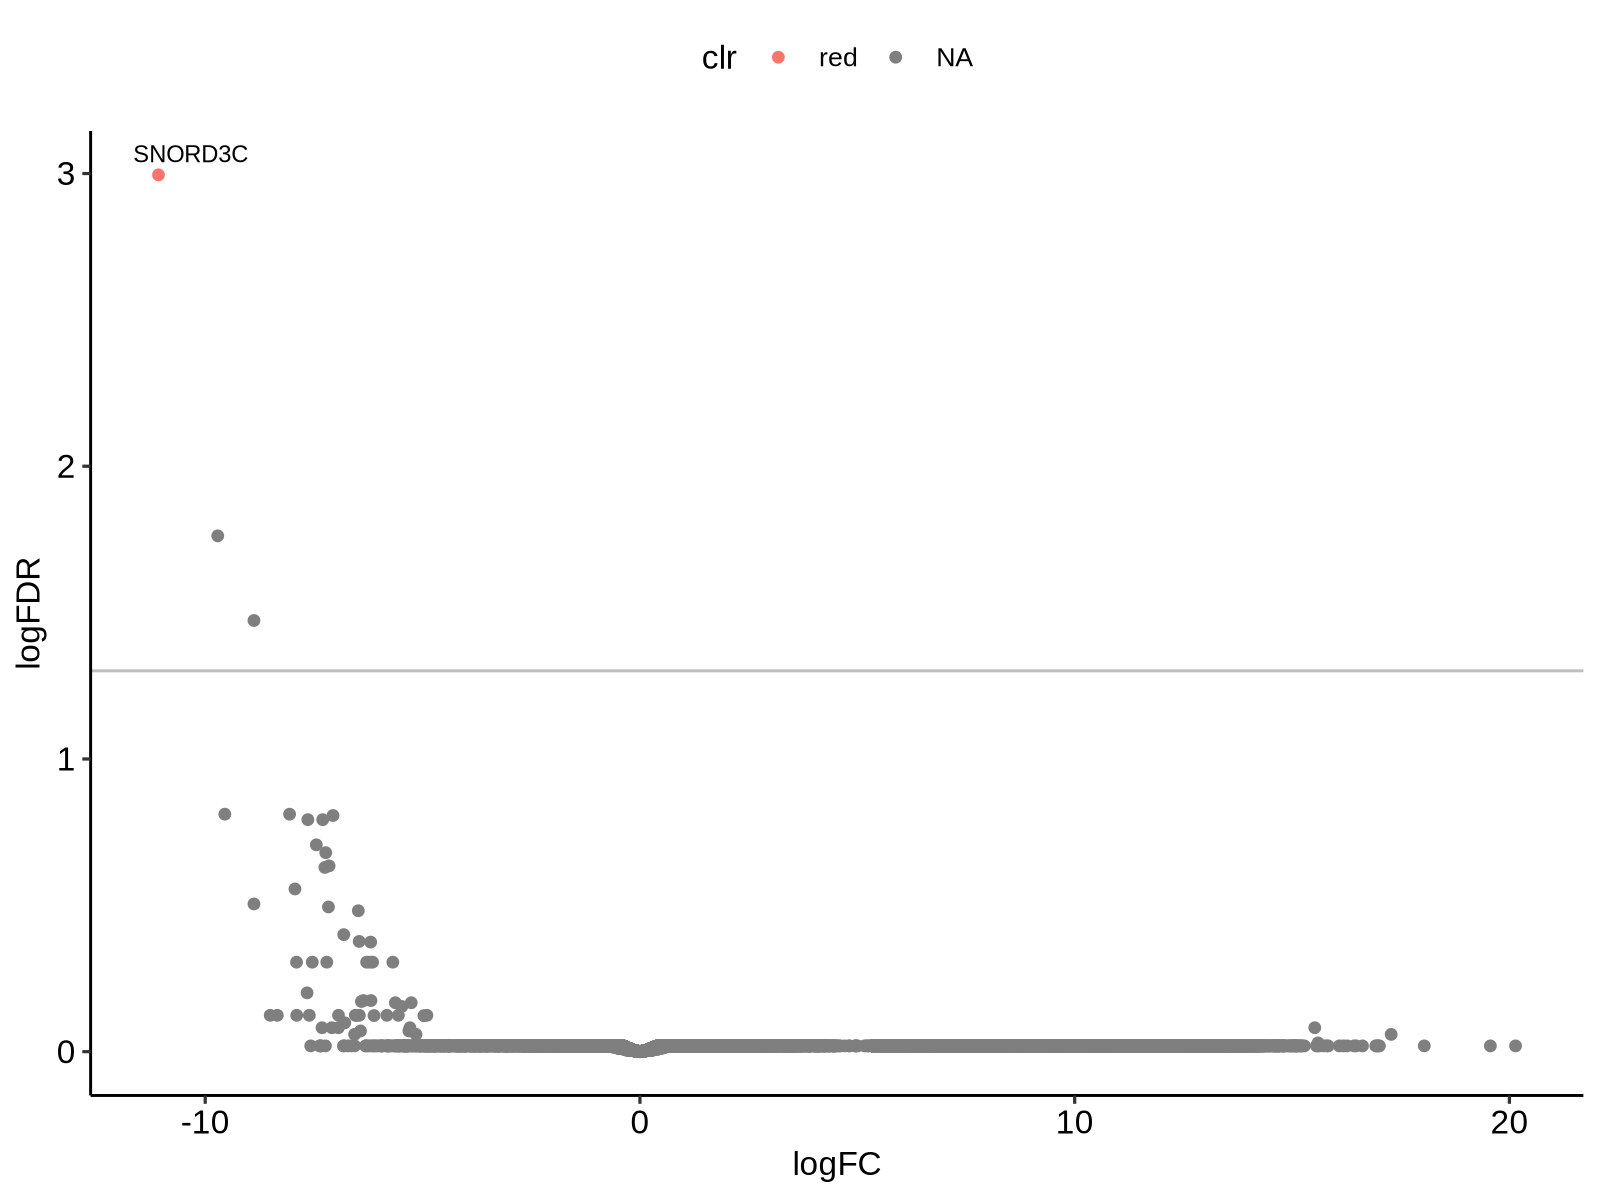

In [169]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = res_etv6[!duplicated(rn), ]
plotdat[logFC < -10, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05, lbl := rn]
#plotdat[rn %in% gene_sel, lbl := rn]
plotdat[, logFDR := -log(FDR, 10)] 
plotdat[logFDR > 50, lbl := rn]
plotdat[!is.na(lbl), clr := 'red'] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel(size = 3) 


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (5.28% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"


pathway                            pval         padj       log2err  
1 HALLMARK_OXIDATIVE_PHOSPHORYLATION 0.0002984799 0.01462552 0.4984931
2 HALLMARK_G2M_CHECKPOINT            0.0018132027 0.04442347 0.4550599
3 HALLMARK_DNA_REPAIR                0.0034223265 0.05258904 0.4317077
4 HALLMARK_MYC_TARGETS_V2            0.0042929829 0.05258904 0.4070179
5 HALLMARK_E2F_TARGETS               0.0136753832 0.12684793 0.3807304
6 HALLMARK_CHOLESTEROL_HOMEOSTASIS   0.0155323992 0.12684793 0.3807304
  ES        NES      size leadingEdge  logFDR   updn
1 0.6977718 1.270408 182  DLAT, AT.... 3.525085 UP  
2 0.6791233 1.236698 185  SQLE, BC.... 2.741554 UP  
3 0.6837193 1.235547 142  AAAS, NT.... 2.465679 UP  
4 0.7408858 1.312248  57  PLK1, MP.... 2.367241 UP  
5 0.6417811 1.172644 195  RACGAP1,.... 1.864060 UP  
6 0.7041094 1.250312  68  STARD4, .... 1.808761 UP

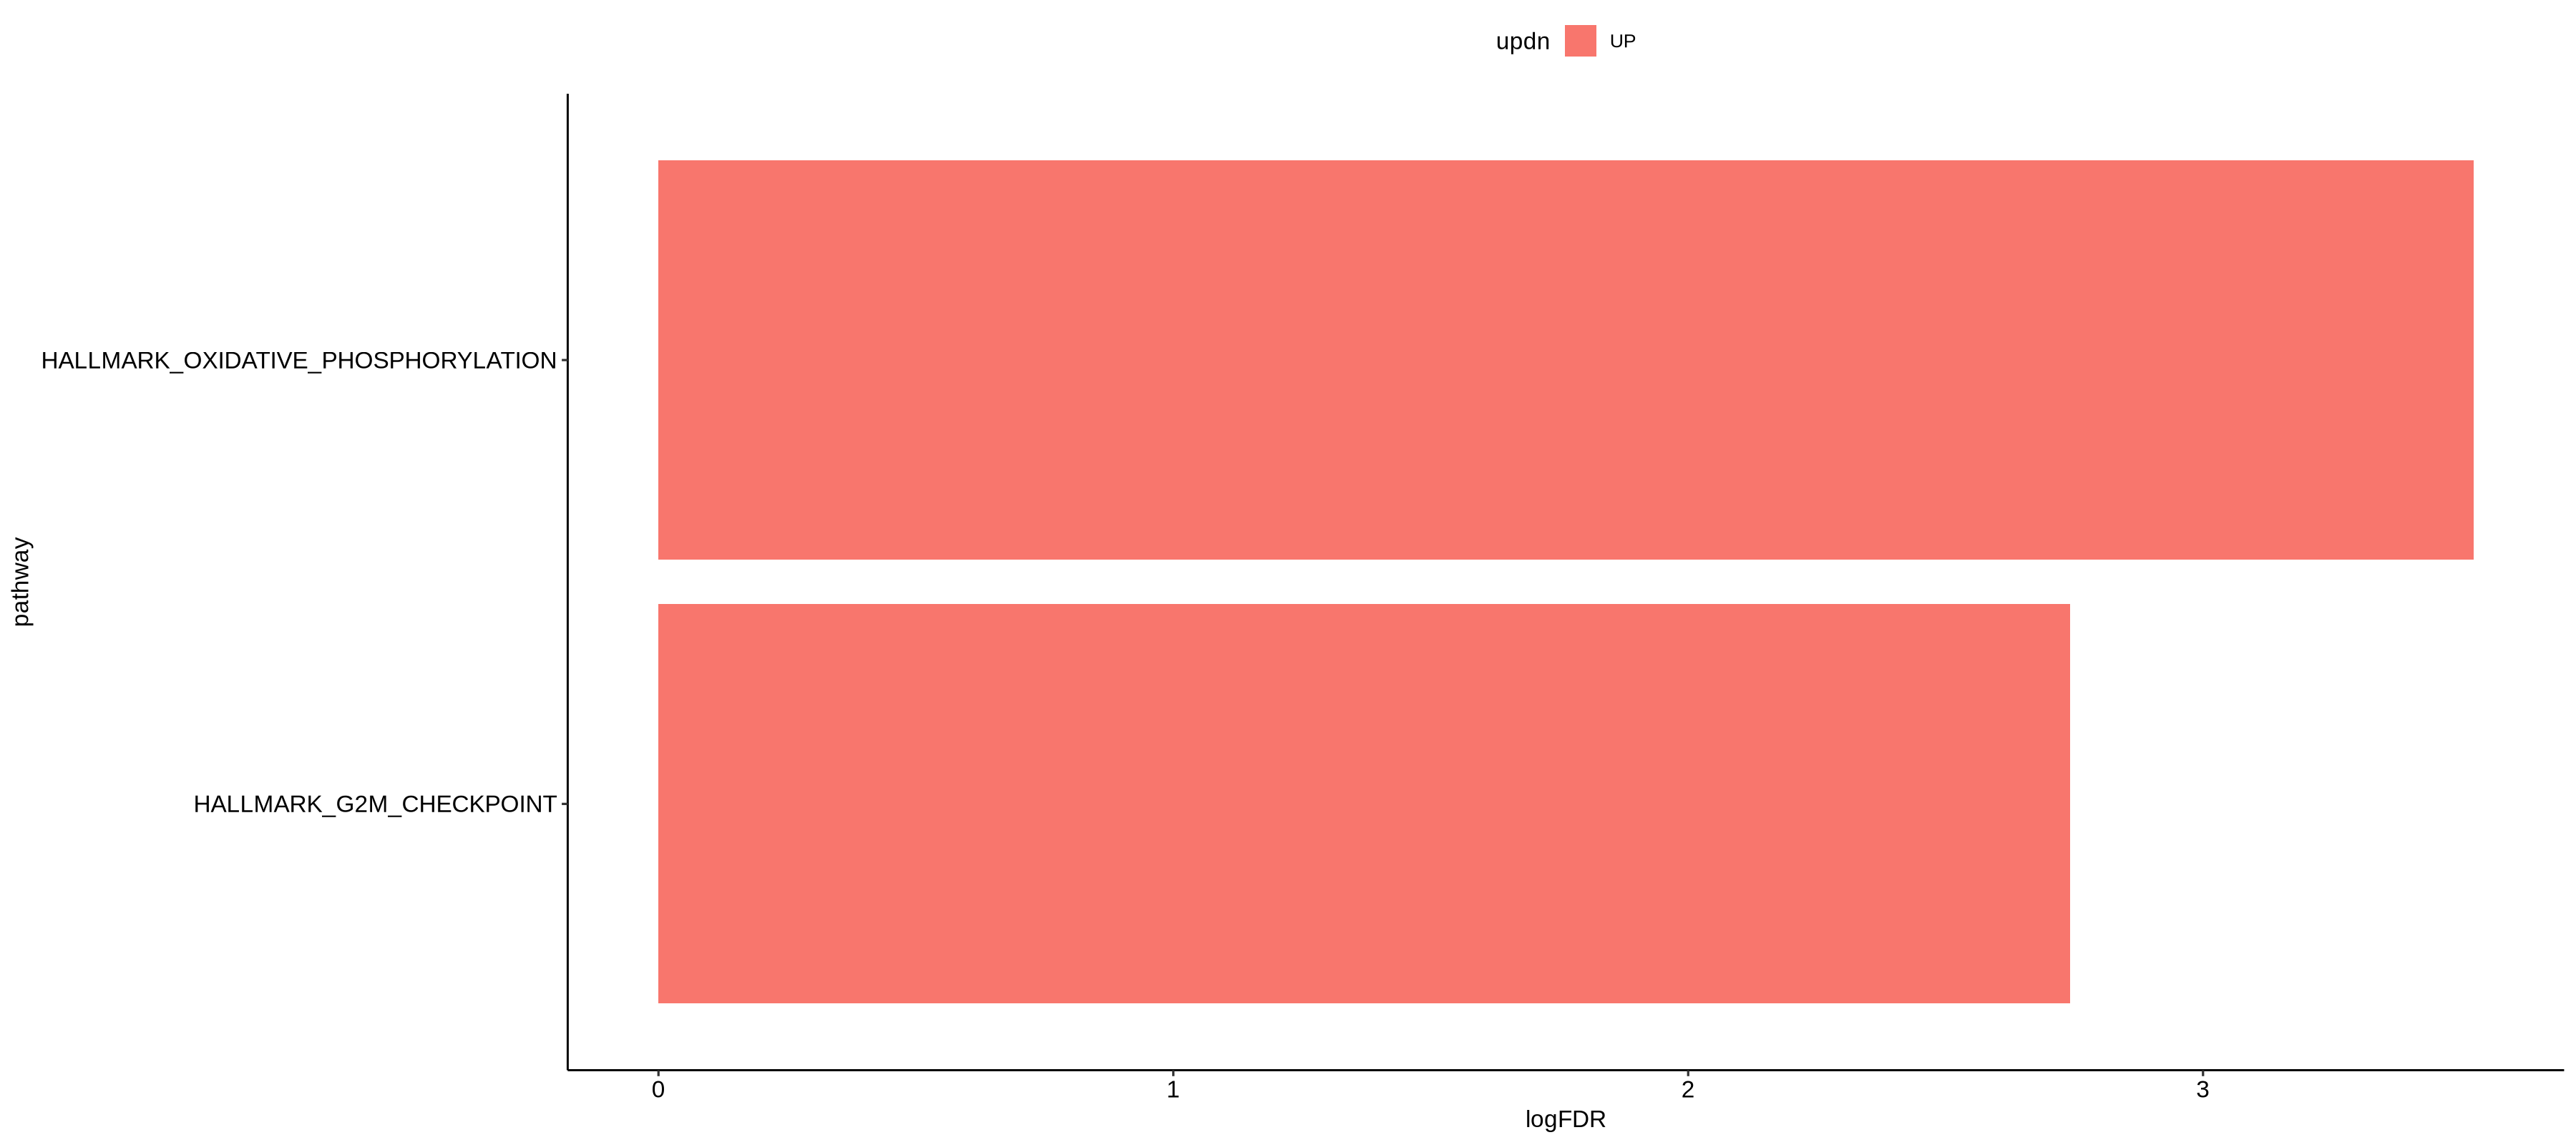

In [170]:
res_etv6[, ranking := -logFC*log10(PValue)]
res_etv6[1, ranking := 300]
tmp = res_etv6[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log(pval, 10)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


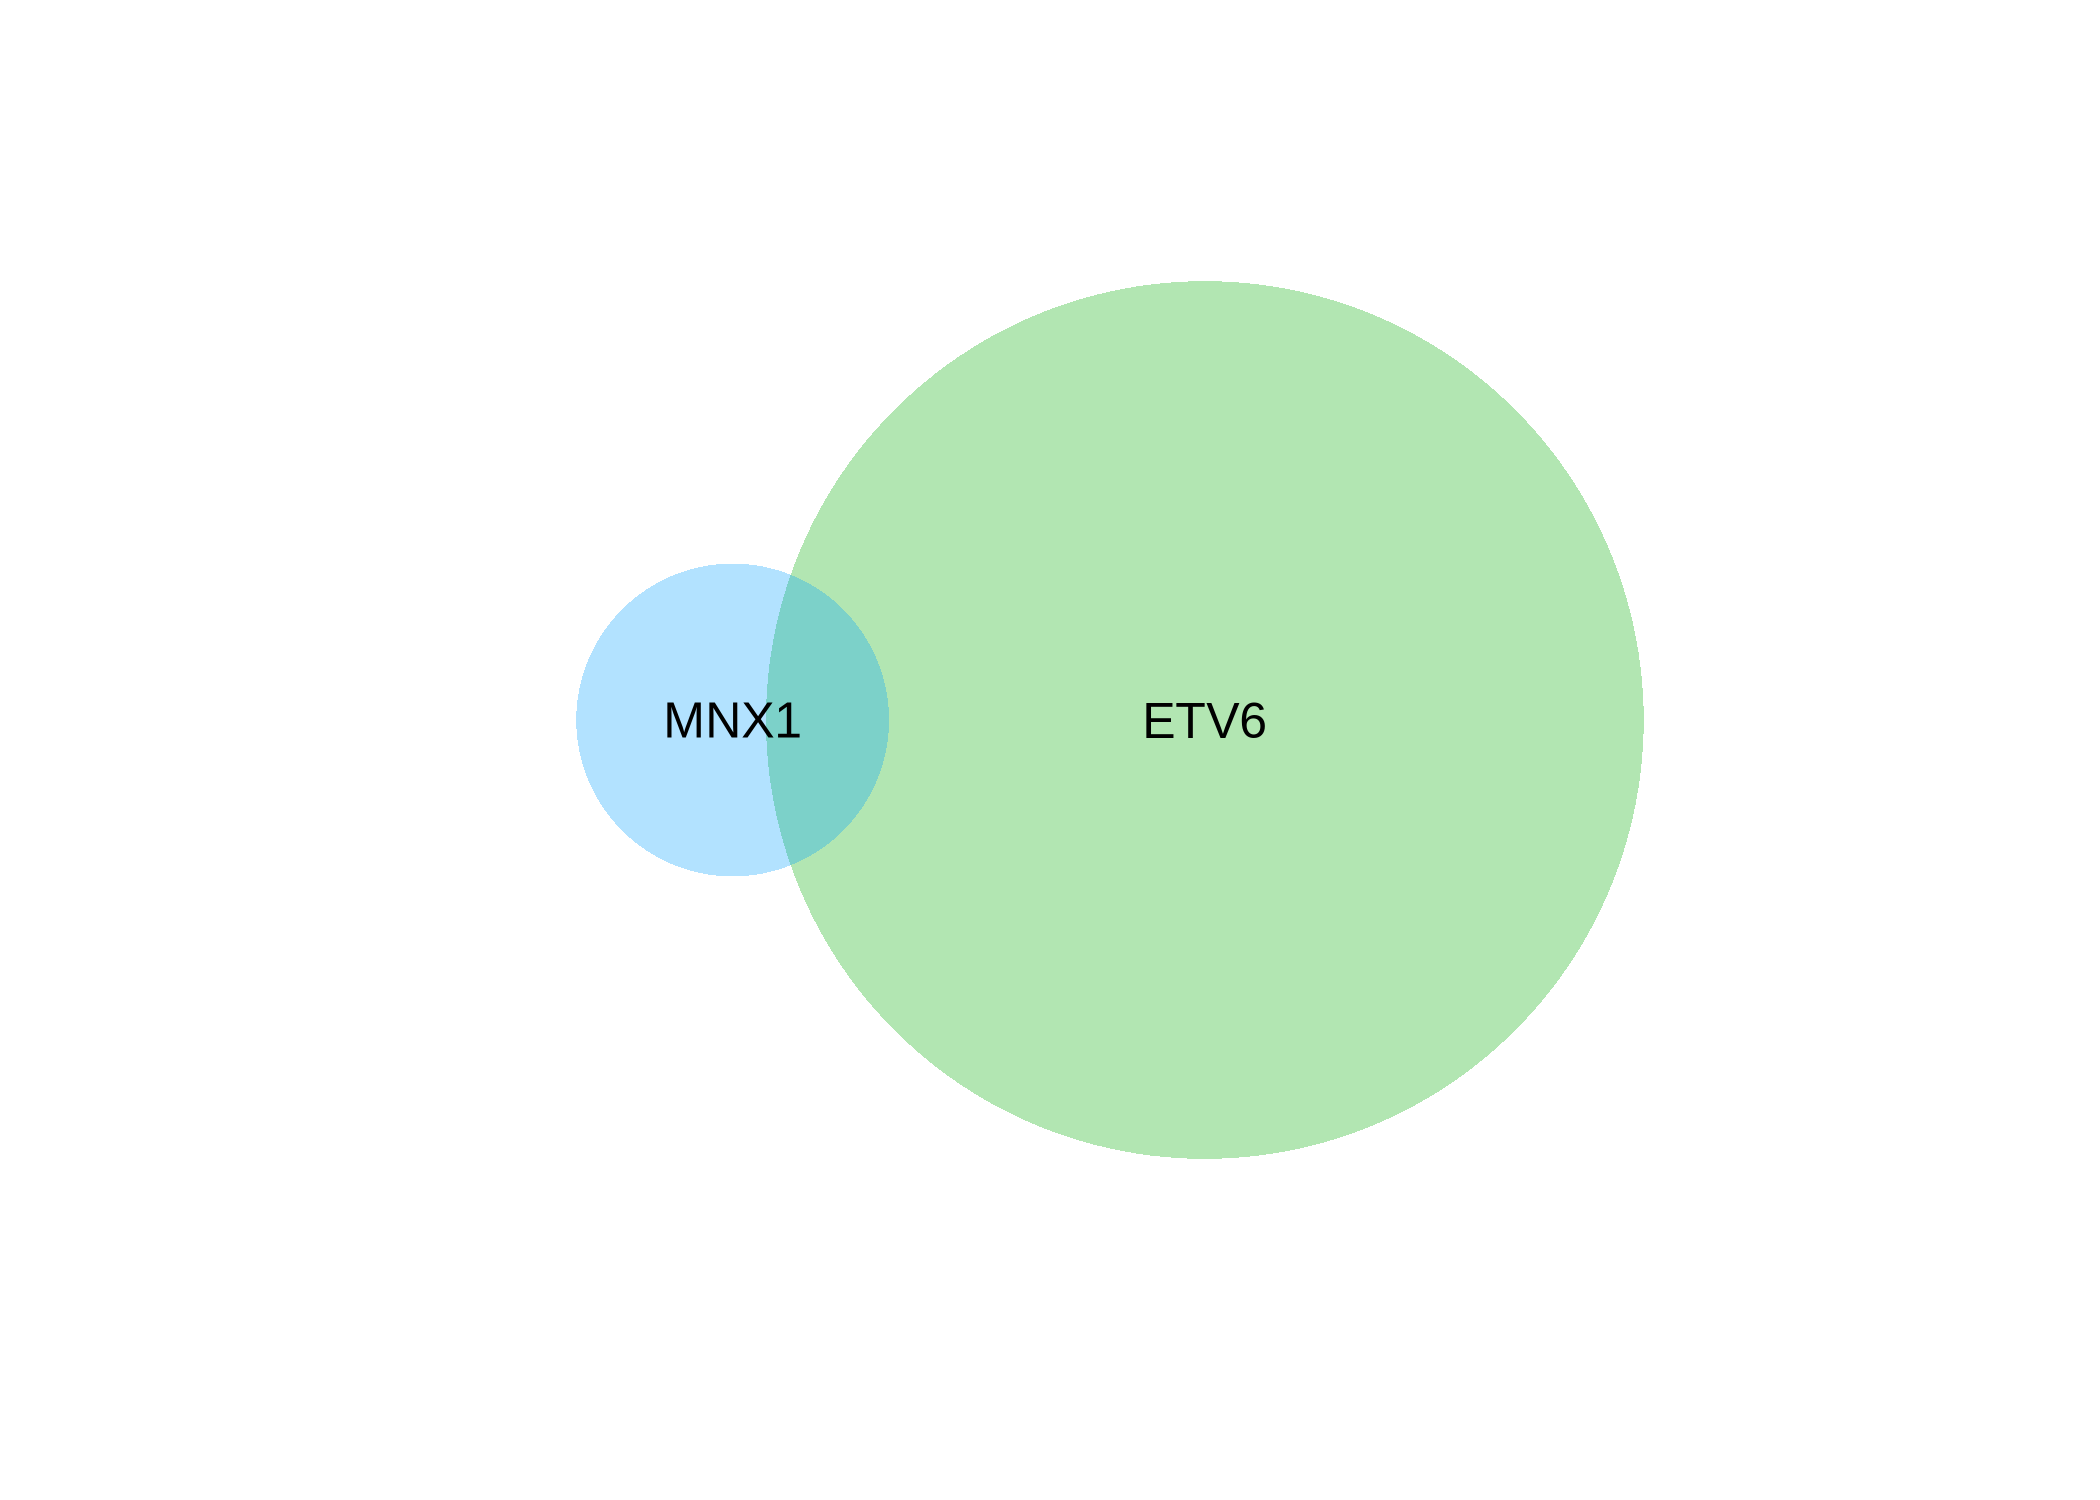

In [114]:
xx = list(ETV6 = res_etv6[logFC > 0 & FDR < 0.05, rn], MNX1 = res_mnx1_vs_pAML[logFC > 0 & FDR < 0.05, rn])
a = length( setdiff(xx$ETV6, xx$MNX1) )
b = length( setdiff(xx$MNX1, xx$ETV6) )
ab = length( intersect(xx$MNX1, xx$ETV6) )

v <- venneuler(c(ETV6=a, MNX1=b, "ETV6&MNX1"=ab))
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 300)
plot(v)

#venn.diagram(xx, filename = "venn_diagram.pdf")


In [ ]:
gene_sel = setdiff(xx$MNX1, xx$ETV6)
yy <- enrichGO(gene_sel, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
dotplot(yy)


# MNX1 hi vs lo

## MNX1 id

## MNX1 hi vs int

In [121]:
mtx2 = mtx[, c(mnx1_int, mnx1_hi)]
tmp = data.frame(subtype = c(rep('MNX1_int', length(mnx1_int)), rep('MNX1_hi', length(mnx1_hi))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('MNX1_int', 'MNX1_hi'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


rn       logFC     logCPM     LR        PValue        FDR          
1 MNX1     10.793939  0.8572802 2087.2648  0.000000e+00  0.000000e+00
2 MNX1-AS2  7.471696 -3.4788216  682.1745 2.249298e-150 1.681736e-146
3 KRT72     5.063982  0.7895547  681.7375 2.799472e-150 1.681736e-146
4 KRT73     4.652819  0.4816787  559.7320 9.614384e-124 4.331761e-120
5 CXCL5     6.097220  1.5686222  497.3666 3.555846e-110 1.281669e-106
6 CTTNBP2   5.893422 -1.0857598  404.6818  5.269706e-90  1.582844e-86

In [122]:
res_test[grep('IL6', rn), ]

rn    logFC      logCPM   LR         PValue       FDR         
1 IL6    2.3730369 1.814885 50.5109788 1.185000e-12 2.542390e-10
2 IL6ST -0.5362784 7.351869  6.1062402 1.347054e-02 7.032620e-02
3 PPIL6  0.3748563 0.728694  5.4116812 2.000244e-02 9.075630e-02
4 IL6R  -0.1252876 6.631664  0.3132578 5.756879e-01 7.315645e-01

pathway                          pval        padj      log2err   ES        
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB 0.000346262 0.0173131 0.4984931  0.9093555
2 HALLMARK_IL6_JAK_STAT3_SIGNALING 0.044379819 0.8196721 0.3217759  0.8980990
3 HALLMARK_ESTROGEN_RESPONSE_LATE  0.049180328 0.8196721 0.2489111 -0.5932038
4 HALLMARK_NOTCH_SIGNALING         0.082173246 0.8379121 0.2878051  0.9145956
5 HALLMARK_INFLAMMATORY_RESPONSE   0.121301775 0.8379121 0.2220560  0.7419587
6 HALLMARK_IL2_STAT5_SIGNALING     0.130699088 0.8379121 0.2165428  0.7336513
  NES       size leadingEdge  logFDR    updn
1  1.768034 192  CSF2, CX.... 11.495848 UP  
2  1.702474  87  CSF2, CX....  4.493952 UP  
3 -1.294212 192  IGSF1, C....  4.345775 DN  
4  1.651114  32  WNT5A, H....  3.605187 UP  
5  1.453854 196  MET, CSF....  3.043327 UP  
6  1.426124 193  CSF2, CO....  2.935679 UP

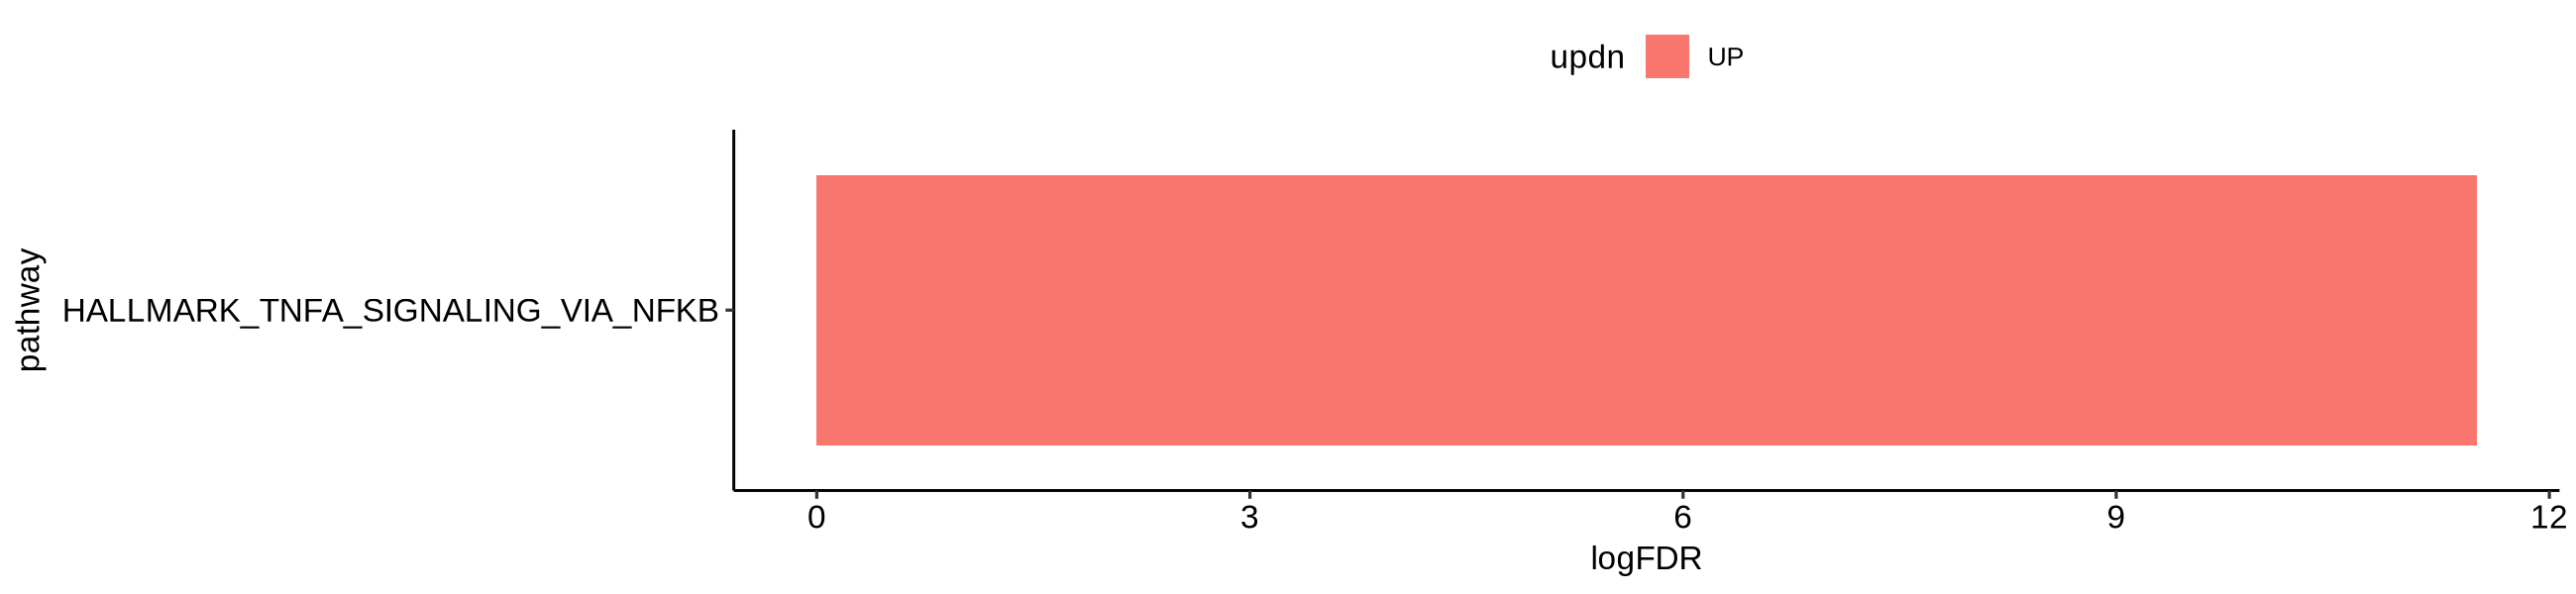

In [123]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## MNX1 hi vs lo

In [124]:
head(mtx2)

TARGET-00-BM3897 TARGET-00-BM3969 TARGET-00-BM4203 TARGET-00-BM4404
TSPAN6    62               43               33               20           
TNMD       0                0                0                0           
DPM1     903              896              736              673           
SCYL3   1359             1497              891             1134           
FGR    24113            20619            16328            14920           
CFH      296              251              166              446           
       TARGET-00-BM4473 TARGET-00-BM4508 TARGET-00-BM4616 TARGET-00-BM4641
TSPAN6    26               64               26               81           
TNMD       0                0                0                0           
DPM1     711              761              662              514           
SCYL3    519              782              540              574           
FGR    17074            13544            12834            12673           
CFH      192              163              349              283           
       TARGET-00-BM5682 TARGET-00-BM5751 ⋯ TARGET-20-PAXMPG TARGET-21-PASVJS
TSPAN6    29               51            ⋯  124                4            
TNMD       0                0            ⋯    0                0            
DPM1     539              664            ⋯  612             1265            
SCYL3   1391              971            ⋯ 1487              632            
FGR    14134            15274            ⋯ 1546             6620            
CFH      253              349            ⋯ 4535              139            
       SJAML015345_D2 SJAML016529_D1 SJAML031343_D1 SJAML032378_D1
TSPAN6   20              6             10              8          
TNMD      0              0              0              0          
DPM1    884            666           1457           1374          
SCYL3   648            137            466           3140          
FGR    1567           1447           9360            589          
CFH    2749             58             30            605          
       SJAML044827_D1 SJAML060291_D1 SJAML074176_D1 SJAMLM7010950_D1
TSPAN6   69            118               1            79            
TNMD      0              0               0             0            
DPM1   1703           1347            1099          1021            
SCYL3   463           1557             395           513            
FGR     267           5490           10093          4108            
CFH     671            510               9           127

In [125]:
length(mnx1_int)

[1] 2062

In [126]:
mtx2 = mtx[, c(mnx1_lo, mnx1_hi)]
tmp = data.frame(subtype = c(rep('MNX1_lo', length(mnx1_lo)), rep('MNX1_hi', length(mnx1_hi))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('MNX1_lo', 'MNX1_hi'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge, group = condition)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


ERROR: Error in glmFit.default(sely, design, offset = seloffset, dispersion = 0.05, : Design matrix not of full rank.  The following coefficients not estimable:
 conditionMNX1_hi


In [ ]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## MNX1 int vs lo

In [ ]:
mtx2 = mtx[, c(mnx1_lo, mnx1_int)]
tmp = data.frame(subtype = c(rep('MNX1_lo', length(mnx1_lo)), rep('MNX1_int', length(mnx1_int))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('MNX1_lo', 'MNX1_int'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


In [ ]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


# MNX1 stratification vs ETV6 stratification

In [ ]:
plotdat = as.data.table(t(logcpm[c('MNX1', 'ETV6'), ]), keep.rownames = T)
head(plotdat)


In [ ]:
# ETV6 : 0% 4.20382207880353 25% 6.7741011513844 50% 7.43453558227542 75% 7.95795213001927 100% 9.95605124044368
# -4.568 3.2

In [ ]:
mnx1_subtype_id

In [ ]:
etv6_lo_mnx1int_id = plotdat2[ETV6 < 6.7741011513844 & MNX1 > -4.568 & MNX1 < 3.2, rn] 
etv6_hi_mnx1int_id = plotdat2[ETV6 > 7.95795213001927 & MNX1 > -4.568 & MNX1 < 3.2, rn ]
etv6_int_mnx1int_id = plotdat2[ETV6 < 7.95795213001927 & ETV6 > 6.7741011513844 & MNX1 > -4.568 & MNX1 < 3.2, rn ]


## MNX1 subtype vs mnx1 int and ETV6 hi

In [ ]:
etv_sel = setdiff(etv6_hi_mnx1int_id, c(mnx1_subtype_id))
mtx2 = mtx[, c(mnx1_subtype_id, etv_sel)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv_sel))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


In [ ]:
etv_sel = setdiff(etv6_hi_mnx1int_id, c(mnx1_subtype_id))
mtx2 = mtx[, c(mnx1_subtype_id, etv_sel)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv_sel))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


In [ ]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## MNX1 subtype vs mnx1 int and ETV6 lo

In [ ]:
etv_sel = setdiff(etv6_lo_mnx1int_id, c(mnx1_subtype_id))
mtx2 = mtx[, c(mnx1_subtype_id, etv_sel)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv_sel))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


In [ ]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## MNX1 subtype vs mnx1 int and ETV6 intermediate


In [ ]:
etv_sel = setdiff(etv6_int_mnx1int_id, c(mnx1_subtype_id))
mtx2 = mtx[, c(mnx1_subtype_id, etv_sel)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv_sel))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


In [ ]:
res_test[, ranking := -logFC*log10(PValue)]
res_test[1, ranking := 500]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


# MNX1 vs ETV6 stratification

## mnx1 vs etv6 median

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


pathway                                    pval        padj      log2err  
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.004320767 0.2160383 0.4070179
2 HALLMARK_INFLAMMATORY_RESPONSE             0.016192566 0.4002287 0.3524879
3 HALLMARK_WNT_BETA_CATENIN_SIGNALING        0.032402335 0.4002287 0.3217759
4 HALLMARK_IL6_JAK_STAT3_SIGNALING           0.037821483 0.4002287 0.2878571
5 HALLMARK_CHOLESTEROL_HOMEOSTASIS           0.053054662 0.4002287 0.2489111
6 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.057180851 0.4002287 0.2165428
  ES        NES      size leadingEdge  logFDR   updn
1 0.8839460 1.764988 192  CXCL3, C.... 7.854497 UP  
2 0.8550807 1.711464 189  BEST1, C.... 5.948525 UP  
3 0.9104009 1.663430  42  HEY1, WN.... 4.947758 UP  
4 0.8217243 1.583463  86  CXCL3, C.... 4.724650 UP  
5 0.8204499 1.558237  70  PLAUR, J.... 4.236377 UP  
6 0.7234934 1.446271 190  COL6A2, .... 4.128324 UP

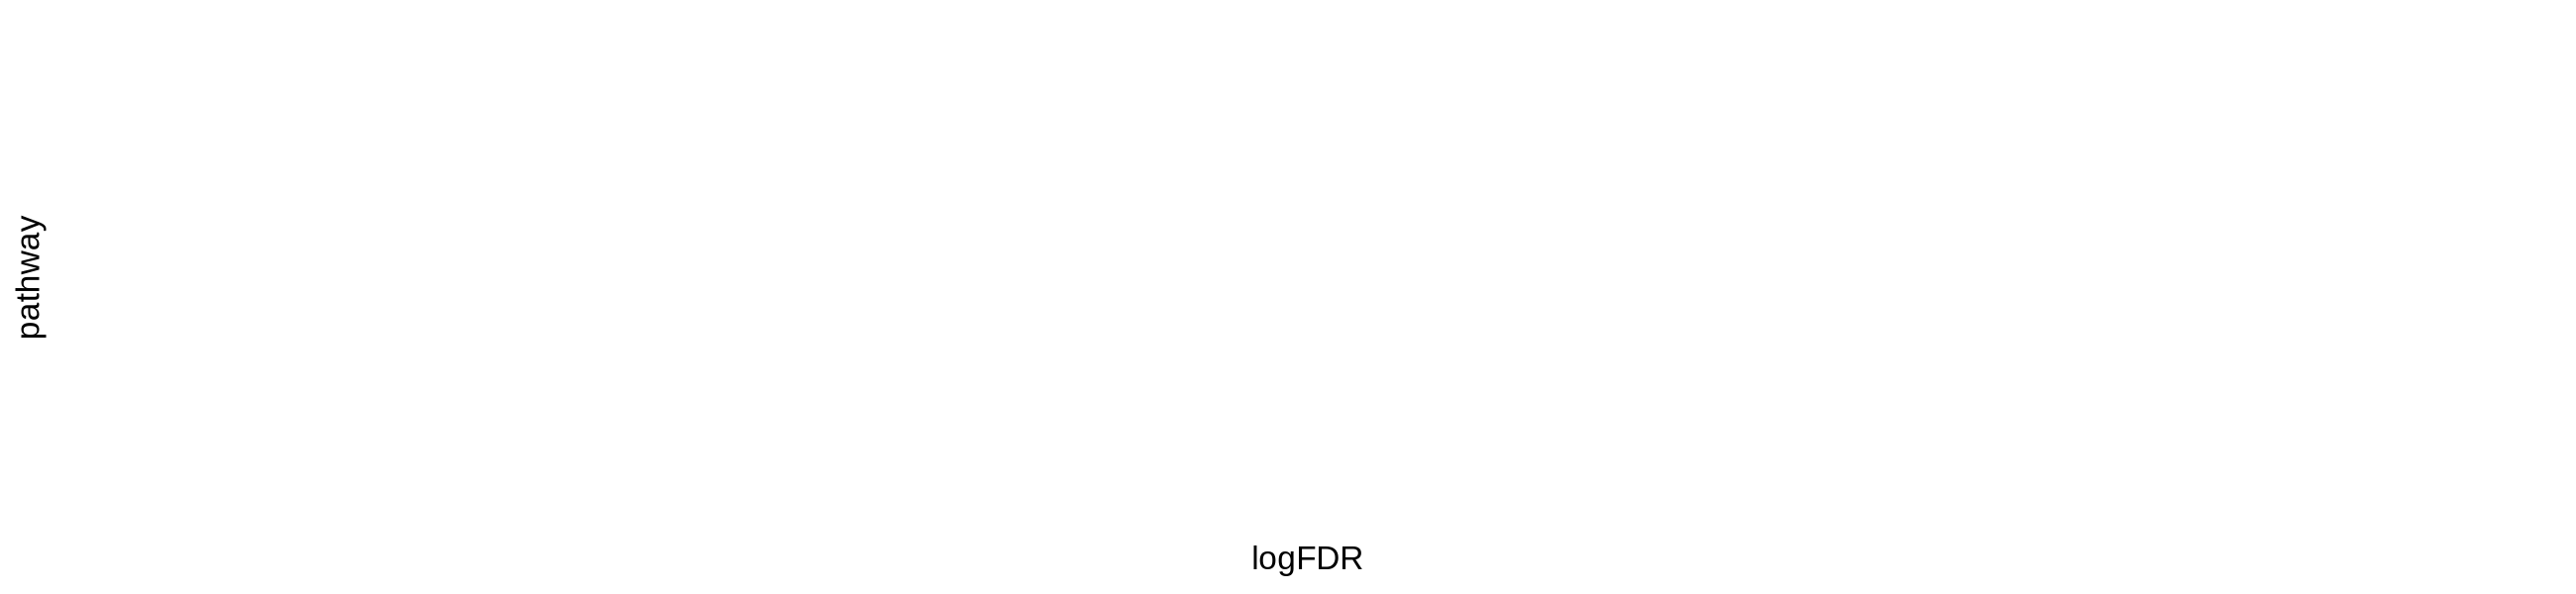

In [272]:
test_sel = two_gene[etv == 'hi' & is.na(other_mnx_hi) & subtype != 'CD34' & subtype != 'MNX1', ]
mtx2 = mtx_batch[, c(mnx1_subtype_id, test_sel$rn)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', nrow(test_sel))), row.names = colnames(mtx2))
condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge) 
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)

res_test[, ranking := -logFC*log10(PValue)]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()



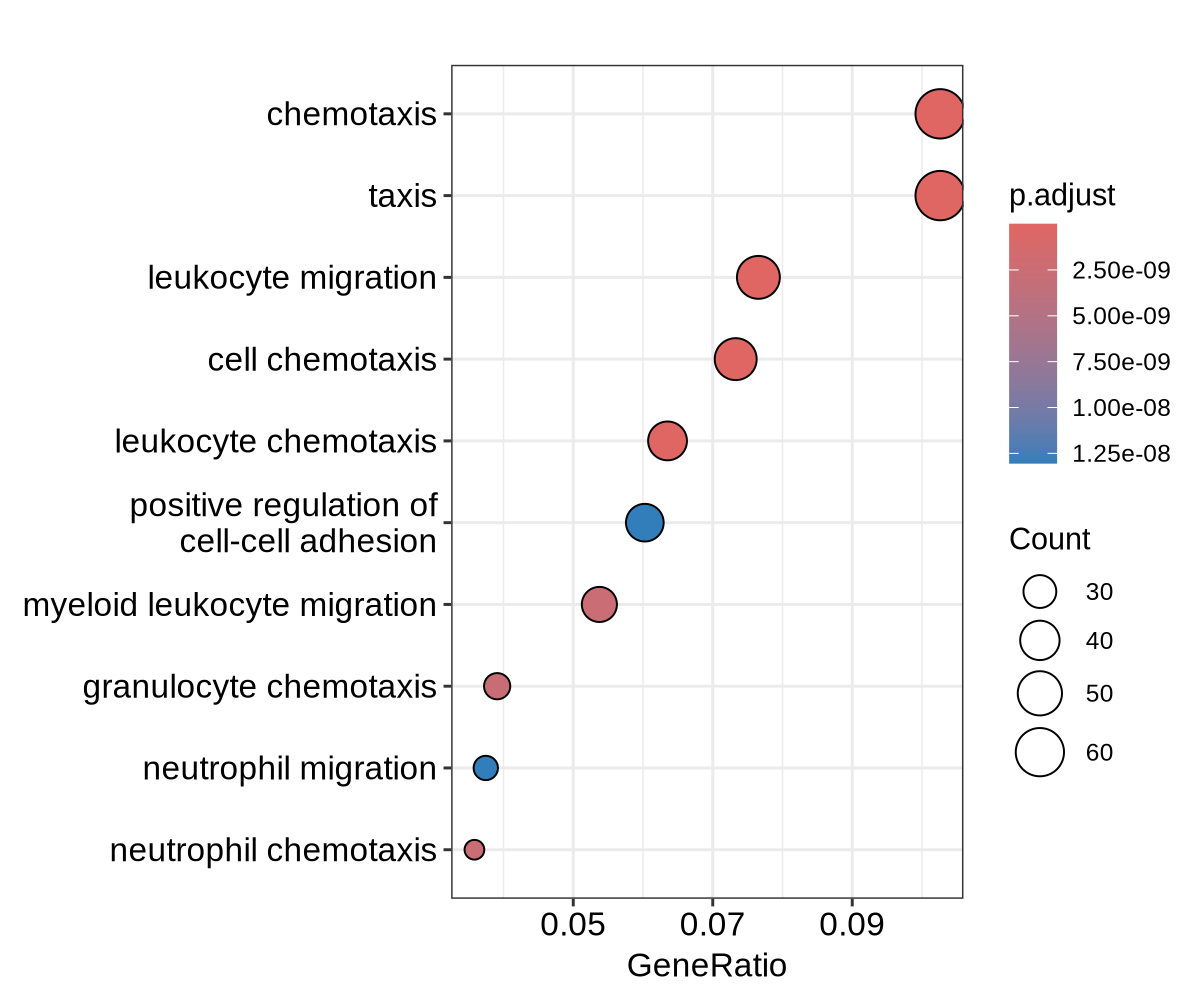

In [274]:
test_gene = res_test[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy)

pathway                            pval        padj       log2err  
1 HALLMARK_HEME_METABOLISM           0.001078183 0.05390913 0.4550599
2 HALLMARK_IL6_JAK_STAT3_SIGNALING   0.002715868 0.06789671 0.4317077
3 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.005322627 0.08871046 0.4070179
4 HALLMARK_ESTROGEN_RESPONSE_LATE    0.013714081 0.17142601 0.3807304
5 HALLMARK_INFLAMMATORY_RESPONSE     0.060050961 0.50581689 0.3217759
6 HALLMARK_OXIDATIVE_PHOSPHORYLATION 0.060698027 0.50581689 0.2249661
  ES         NES       size leadingEdge  logFDR   updn
1 -0.6492755 -1.453910 189  IGSF3, B.... 9.857183 DN  
2  0.8706261  1.771510  87  CXCL1, C.... 8.524371 UP  
3  0.8498964  1.836342 192  CXCL1, C.... 7.553646 UP  
4 -0.6037682 -1.350958 188  IGSF1, D.... 6.188198 DN  
5  0.6979147  1.514437 191  CSF3, EB.... 4.057669 UP  
6 -0.5704888 -1.271945 183  ATP6V0C,.... 4.042207 DN

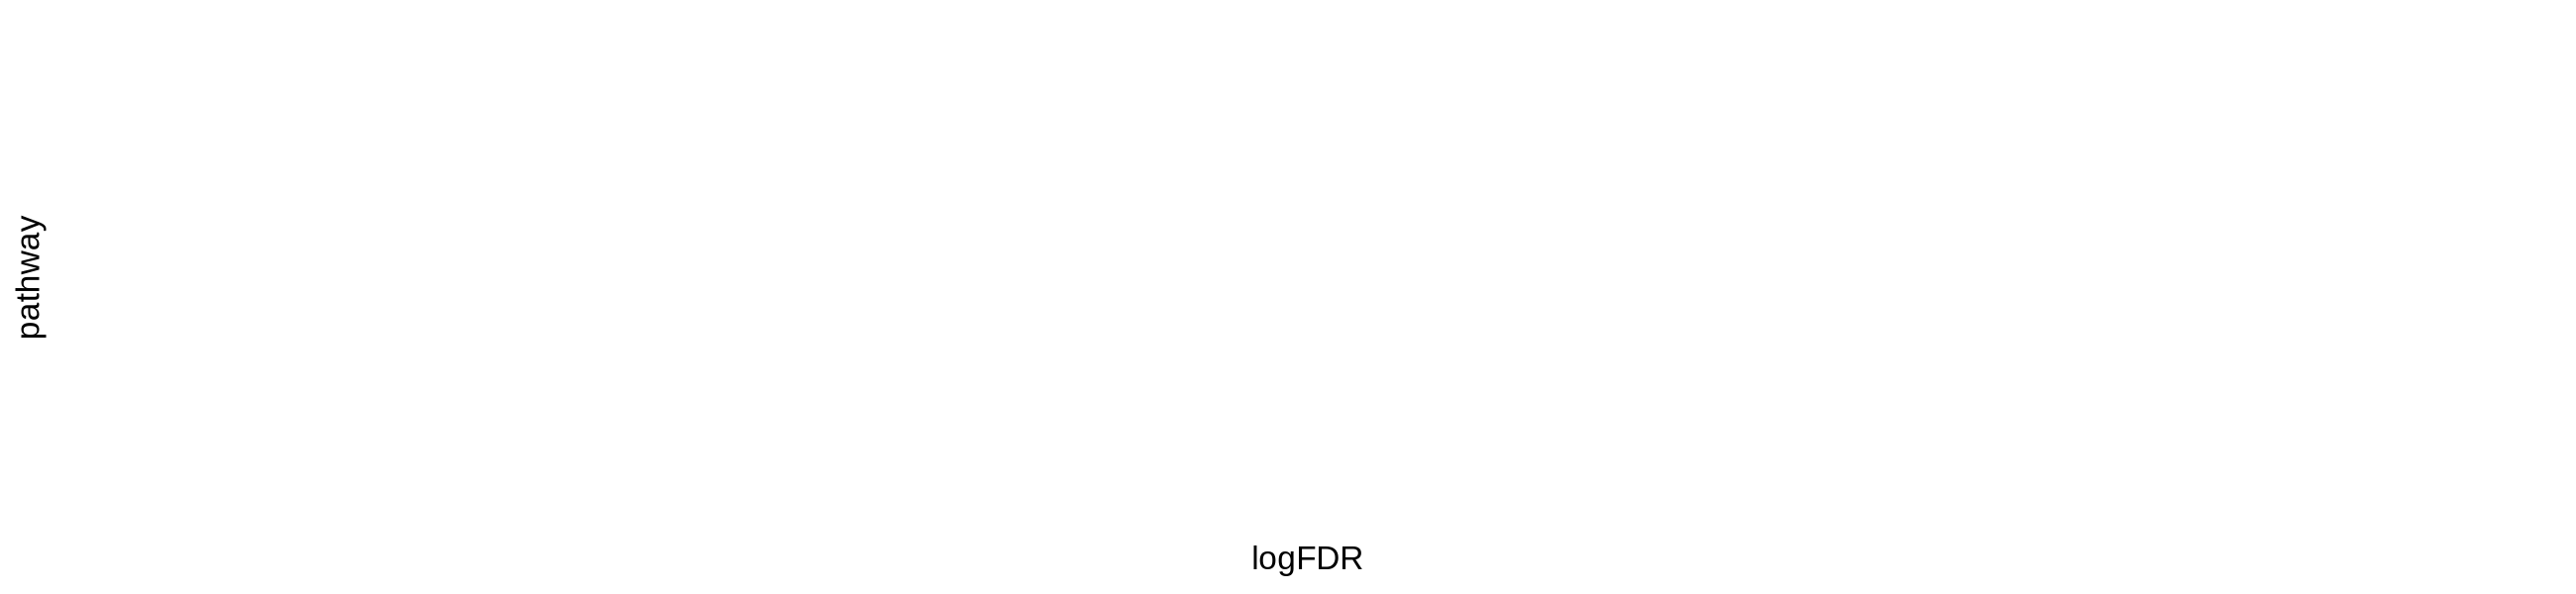

In [261]:
test_sel = two_gene[etv == 'lo' & is.na(other_mnx_hi) & subtype != 'CD34' & subtype != 'MNX1', ]
mtx2 = mtx_batch[, c(mnx1_subtype_id, test_sel$rn)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', nrow(test_sel))), row.names = colnames(mtx2))
condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge) 
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)

res_test[, ranking := -logFC*log10(PValue)]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()



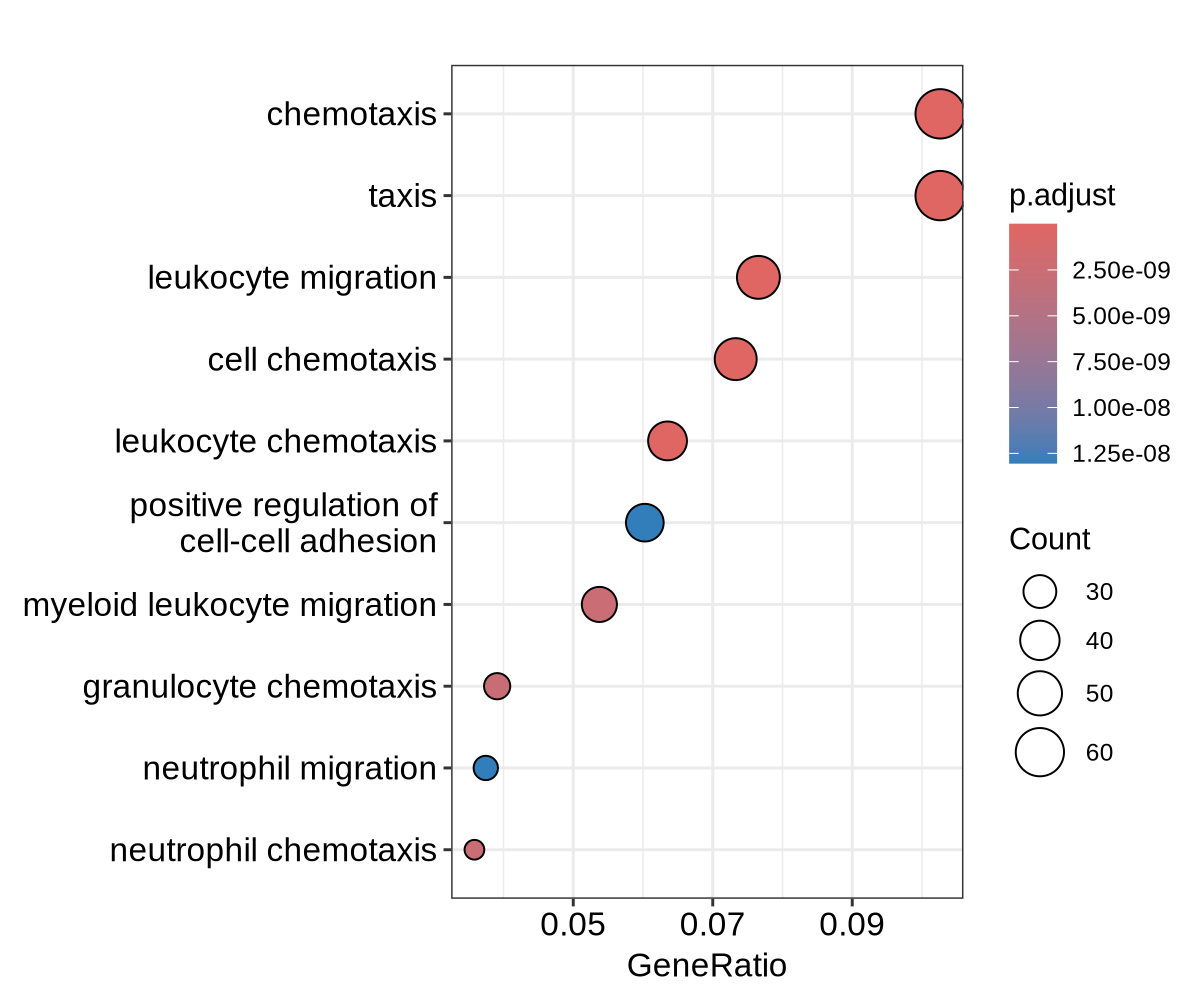

In [275]:
test_gene = res_test[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy)

In [277]:
test_sel = two_gene[etv == 'int' & is.na(other_mnx_hi) & subtype != 'CD34' & subtype != 'MNX1', ]
mtx2 = mtx_batch[, c(mnx1_subtype_id, test_sel$rn)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', nrow(test_sel))), row.names = colnames(mtx2))
condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge) 
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_test = topTags(lrt, n = nrow(mtx2))
res_test = as.data.table(res_test$table, keep.rownames = T)
head(res_test)


rn       logFC     logCPM     LR       PValue        FDR          
1 MNX1     10.579716  1.6774634 959.0521 1.429022e-210 2.413047e-206
2 CXCL5     7.155804  1.9552988 591.5255 1.167066e-130 9.853541e-127
3 KRT72     5.356779  1.1478902 547.1401 5.274004e-121 2.968561e-117
4 KRT73     4.937272  0.7819514 464.1492 6.011252e-103  2.537650e-99
5 MNX1-AS2  7.808930 -2.8880897 451.0195 4.327655e-100  1.461536e-96
6 CXCL1     4.928038  2.5526826 424.0508  3.204395e-94  9.018236e-91

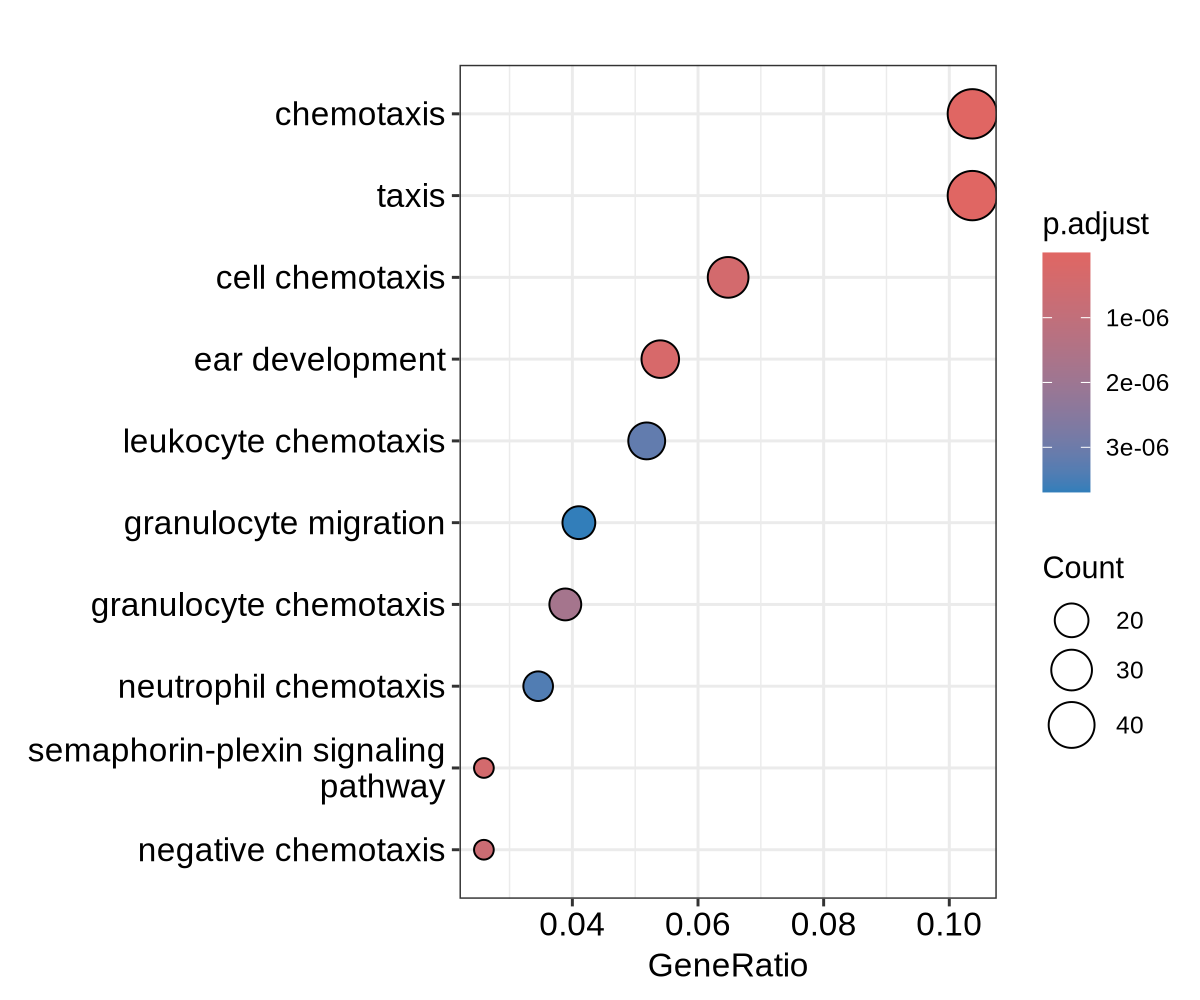

In [278]:
test_gene = res_test[logFC > 1 & FDR < 0.05, rn]
yy <- enrichGO(test_gene, 'org.Hs.eg.db', ont="BP", pvalueCutoff=0.01, readable = T, keyType = 'SYMBOL')
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
dotplot(yy)

pathway                             pval        padj      log2err  
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB    0.007920144 0.1695321 0.3807304
2 HALLMARK_ESTROGEN_RESPONSE_LATE     0.009154863 0.1695321 0.3807304
3 HALLMARK_IL6_JAK_STAT3_SIGNALING    0.010171923 0.1695321 0.3807304
4 HALLMARK_NOTCH_SIGNALING            0.082687339 0.7075923 0.2529611
5 HALLMARK_WNT_BETA_CATENIN_SIGNALING 0.110565111 0.7075923 0.2114002
6 HALLMARK_INFLAMMATORY_RESPONSE      0.110726644 0.7075923 0.1752040
  ES         NES       size leadingEdge  logFDR   updn
1  0.9144418  1.717434 192  CSF2, CX.... 6.980258 UP  
2 -0.6232491 -1.443891 187  IGSF1, C.... 6.771246 DN  
3  0.9080421  1.649747  87  CSF2, CX.... 6.619264 UP  
4  0.8457899  1.443606  31  HES1, JA.... 3.596190 UP  
5  0.8190756  1.387606  42  HEY1, JA.... 3.177032 UP  
6  0.7719593  1.449835 192  MET, CCL.... 3.174926 UP

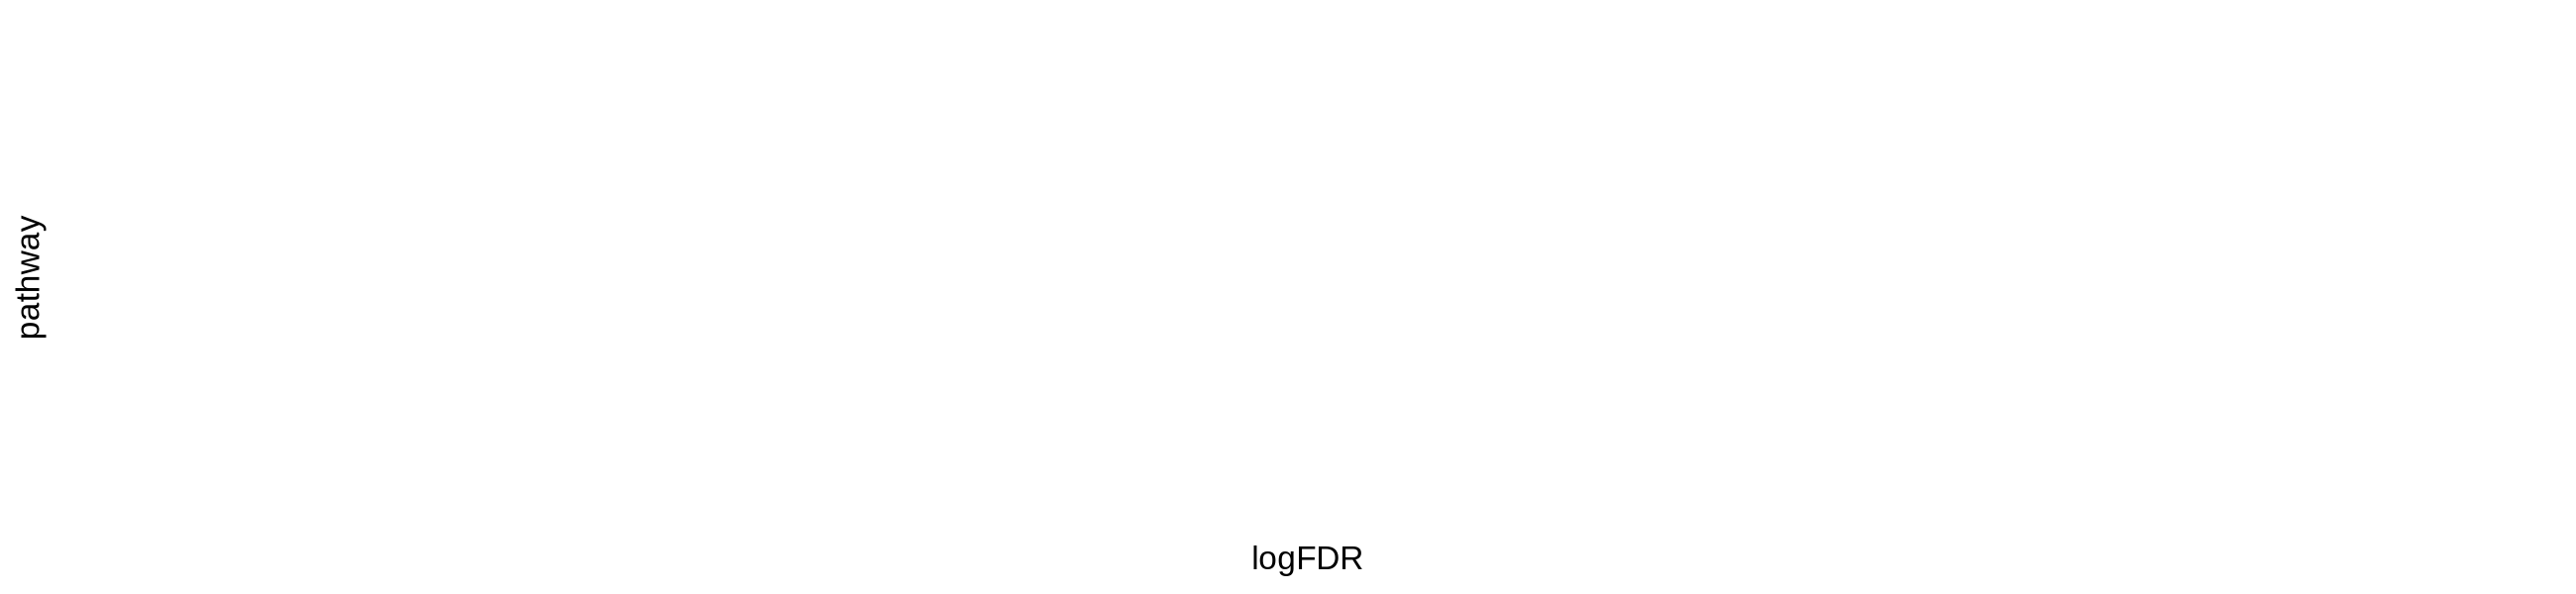

In [259]:
res_test[, ranking := -logFC*log10(PValue)]
tmp = res_test[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


In [ ]:
mtx2 = mtx[, c(mnx1_subtype_id, etv6_median_id)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv6_median_id))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_mnx1_vs_etv6median = topTags(lrt, n = nrow(mtx2))
res_mnx1_vs_etv6median = as.data.table(res_mnx1_vs_etv6median$table, keep.rownames = T)
head(res_mnx1_vs_etv6median)


In [ ]:
res_mnx1_vs_etv6median[, ranking := -logFC*log10(PValue)]
#res_etv6[1, ranking := 300]
tmp = res_mnx1_vs_etv6median[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


In [ ]:
res_mnx1_vs_etv6median[, ranking := -logFC*log10(PValue)]
#res_etv6[1, ranking := 300]
tmp = res_mnx1_vs_etv6median[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


In [ ]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["HALLMARK_IL6_JAK_STAT3_SIGNALING"]], ranking) + 
labs(title="HALLMARK_IL6_JAK_STAT3_SIGNALING")


In [ ]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]], ranking) + 
labs(title="HALLMARK_TNFA_SIGNALING_VIA_NFKB")

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["HALLMARK_INFLAMMATORY_RESPONSE"]], ranking) + 
labs(title="HALLMARK_INFLAMMATORY_RESPONSE")



## MNX1 vs etv6 low

In [ ]:
mtx2 = mtx[, c(mnx1_subtype_id, etv6_lo_id)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv6_lo_id))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_mnx1_vs_etv6lo = topTags(lrt, n = nrow(mtx2))
res_mnx1_vs_etv6lo = as.data.table(res_mnx1_vs_etv6lo$table, keep.rownames = T)
head(res_mnx1_vs_etv6lo)


In [ ]:
res_mnx1_vs_etv6lo[, ranking := -logFC*log10(PValue)]
#res_etv6[1, ranking := 300]
tmp = res_mnx1_vs_etv6lo[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## MNX1 vs ETV6 high

In [263]:
mtx2 = mtx[, c(mnx1_subtype_id, etv6_hi_id)]
tmp = data.frame(subtype = c(rep('MNX1', length(mnx1_subtype_id)), rep('Others', length(etv6_hi_id))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_mnx1_vs_etv6hi = topTags(lrt, n = nrow(mtx2))
res_mnx1_vs_etv6hi = as.data.table(res_mnx1_vs_etv6hi$table, keep.rownames = T)
head(res_mnx1_vs_etv6hi)


rn      logFC    logCPM      LR       PValue       FDR         
1 KRT72   4.825118  1.74654243 310.5004 1.699098e-69 2.765452e-65
2 KRT73   4.399749  1.36294665 270.4524 9.042930e-61 7.359137e-57
3 UNC13C  7.479719  0.23198288 258.4635 3.710604e-58 2.013126e-54
4 COL6A2  3.787495  3.53017154 234.4147 6.495587e-53 2.643054e-49
5 GSTA4   2.989611  0.44901008 223.1894 1.822711e-50 5.933289e-47
6 CTTNBP2 6.331057 -0.04199976 220.9793 5.530692e-50 1.500292e-46

pathway                             pval         padj        log2err  
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB    4.658835e-05 0.002329418 0.5573322
2 HALLMARK_INFLAMMATORY_RESPONSE      1.036464e-03 0.025911588 0.4550599
3 HALLMARK_CHOLESTEROL_HOMEOSTASIS    2.157207e-02 0.359534515 0.3524879
4 HALLMARK_E2F_TARGETS                5.688073e-02 0.387433080 0.2572065
5 HALLMARK_WNT_BETA_CATENIN_SIGNALING 5.963303e-02 0.387433080 0.2820134
6 HALLMARK_IL6_JAK_STAT3_SIGNALING    7.358491e-02 0.387433080 0.2279872
  ES        NES      size leadingEdge  logFDR    updn
1 0.8402607 1.823731 192  CXCL3, C.... 14.389671 UP  
2 0.7824738 1.698134 191  CCL20, B....  9.914115 UP  
3 0.8195812 1.623590  70  PLAUR, S....  5.534692 UP  
4 0.6689614 1.458383 195  CDC20, M....  4.135916 UP  
5 0.8094228 1.515194  42  HEY1, WN....  4.067745 UP  
6 0.6951661 1.435865  86  CXCL3, C....  3.764446 UP

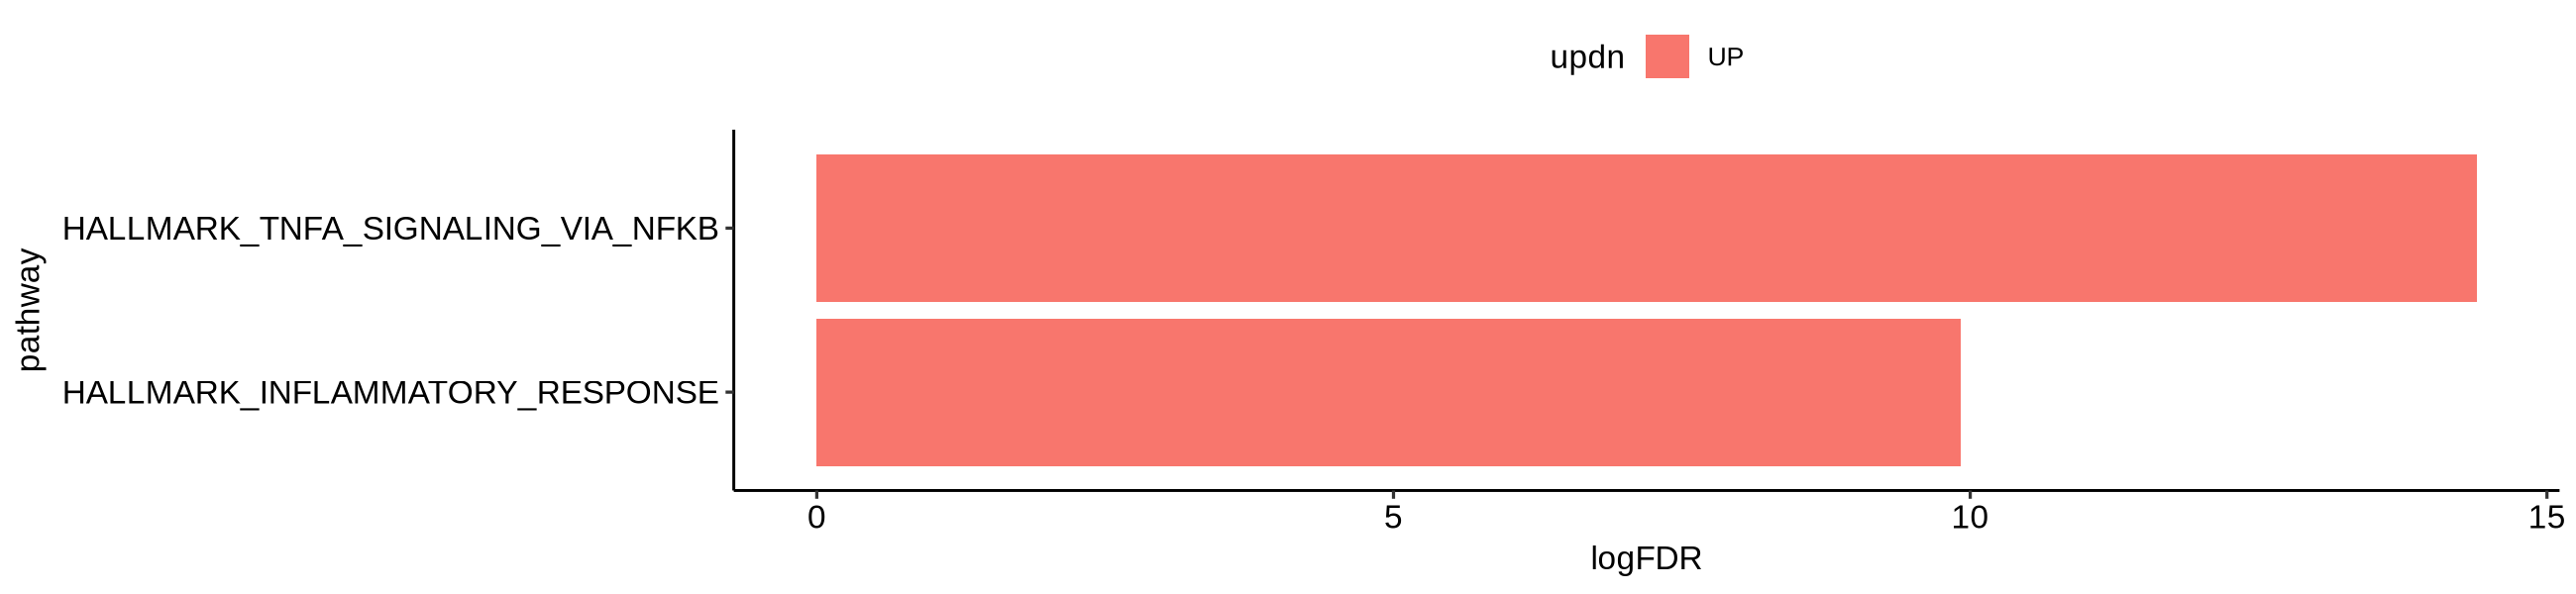

In [264]:
res_mnx1_vs_etv6hi[, ranking := -logFC*log10(PValue)]
#res_etv6[1, ranking := 300]
tmp = res_mnx1_vs_etv6hi[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn

pathwaysDF <- msigdbr(species = "Homo sapiens", category="H") 
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()


## with or without additional MNX1 high patients of other subtype

In [ ]:
# etv6_hi_id
# etv6_lo_id
# etv6_int_id
# test w/ additional MNX1 high samples
# ETV6 intermediate level
add = unique(c(mnx1_subtype_id, mnx1_additional_high))
etv_sel = setdiff(etv6_int_id, add) 
mtx2 = mtx[, c(add, etv_sel)] 
tmp = data.frame(subtype = c(rep('MNX1', length(add)), rep('Others', length(etv6_lo_id))), 
                 row.names = colnames(mtx2))

condition = factor(tmp$subtype, levels = c('Others', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)

lrt = glmLRT(fit, coef=2)
res_mnx1ex_vs_etv6lo = topTags(lrt, n = nrow(mtx2))
res_mnx1ex_vs_etv6lo = as.data.table(res_mnx1ex_vs_etv6lo$table, keep.rownames = T)
head(res_mnx1ex_vs_etv6lo)


# DEG based on the MNX1 expression 

In [ ]:
dsn_df$condition2 = 'Not'
dsn_df$condition2[dsn_df$id %in% mnx_ids_2]  = 'MNX1'

In [ ]:
mtx2 = mtx[, rownames(dsn_df)]

condition = factor(dsn_df$condition2, levels = c('Not', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)
lrt = glmLRT(fit, coef=2)


In [ ]:
res2 = topTags(lrt, n = nrow(mtx2))
res2 = as.data.table(res2$table, keep.rownames = T)
res2 = merge(res2, geneID[, .(ensg, symbol)], by.x = 'rn', by.y = 'ensg', all.x = T)
res2 = res2[!is.na(symbol), ]
head(res2)


In [ ]:
logcpm2 = cpm(dge, log=TRUE)
logcpm2_dt = as.data.table(logcpm2, keep.rownames = T)
logcpm2_dt = merge(logcpm2_dt, geneID[, .(ensg, symbol)], by.x = 'rn', by.y = 'ensg', all.x = T)
logcpm2_dt = logcpm2_dt[!is.na(symbol), ]
logcpm2_dt = logcpm2_dt[!duplicated(symbol), ]
logcpm2_dt[, rn := symbol]
logcpm2_dt[, symbol := NULL]
logcpm2 = setDF(logcpm2_dt[, 2:ncol(logcpm2_dt)], rownames = logcpm2_dt$rn)
logcpm2[1:10, 1:10]


In [ ]:
plotdat = as.data.table(as.data.frame(t(logcpm_dt[rn == 'MNX1', ])), keep.rownames = T)
plotdat = merge(plotdat, dsn[, c('id', 'condition2')], by.x = 'rn', by.y = 'id', all.x = T)
setnames(plotdat, 'V1', 'MNX1')
plotdat[, MNX1 := as.numeric(MNX1)]
plotdat = plotdat[!is.na(MNX1), ]

options(repr.plot.width = 2.5, repr.plot.height = 3, repr.plot.res  =200)
ggplot(plotdat, aes(reorder(condition2, MNX1, median), MNX1)) + geom_jitter(aes(color = condition2), width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + geom_hline(yintercept = 1, color = 'grey')


# MA plot

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = res2[!duplicated(symbol), ]
plotdat[logFC < -10, lbl := symbol]
plotdat[logFC > 5 & FDR < 0.05, lbl := symbol]
plotdat[symbol %in% gene_sel, lbl := symbol]
plotdat[, logFDR := -log(FDR, 10)] 
plotdat[logFDR > 50, lbl := symbol]
plotdat[!is.na(lbl), clr := 'red'] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel(size = 3)


In [ ]:
res2[symbol %in% gene_sel, ][!duplicated(symbol), ][order(FDR), ]
